## Impact of Anomaly Detection on Model Prediction using Categorical Covid-19 Data

### Problem Statement

As part of our research, we looked at recent works related to the role of ML in Covid-19 detection and mitigation. We observed that shallow ML techniques such as Support Vector Machines (SVM) and Random Forest (RF) are popular and employed for scenarios such as early detection of Covid-19 and prioritized usage of RT-PCR tests. We also saw that DL techniques along with medical imaging is a common approach in disease detection and understanding its spread. However, as these approaches lacked the use of Anomaly Detection (AD), we looked at different categories of possible AD techniques that could be applied such as Isolation Forest and its extensions (Hariri et al., 2021). We found that the use of AD in categorical data was limited due to varying definitions of what qualifies as an anomaly. We further noted that the use of AD in a Covid-19 dataset that is categorical in nature is yet to be explored. The impact of AD on predictive models that detect Covid-19 at an early stage is something that is worth looking into.

### Aims & Objectives

This research is aimed at understanding the impact of Anomaly Detection on the prediction of Covid-19 using symptomatic data. The goal is to investigate the effect that high-quality data, that is data without outliers or anomalies, has on building effective models using machine learning techniques to predict Covid-19 at an early stage. 
The objectives of the research are stated as follows:

* To suggest an Anomaly Detection technique that is suitable for application on the Covid-19 dataset that is categorical in nature.
* To evaluate the impact of the Anomaly Detection technique on the predictive power of different machine learning models.
* To improve the prediction of Covid-19 at an early stage using the symptomatic data.


### Data Description

The dataset has been made available by Big Data High-accuracy Center, Beijing University on their Github page as well as on Kaggle. The anonymized dataset consists of 6,512 patients from seven different provinces of China and was collected by the university from official channels of the Chinese national government's websites. Attributes include basic information (gender, age), symptoms (muscle soreness, cough, fever, runny nose), symptoms that resulted in hospital admission (diarrhoea, pneumonia), results from diagnostics (radiographic imaging, lung infection) and other information considered relevant (isolation treatment status, travel history). A target variable is also present which confirms if the patient has Covid-19 (1,572 cases) or not (4,970 cases). The dataset is categorical in nature, with the exception of the age attribute. 

### Steps Involved

* **Data Preparation**
    * Exploratory Data Analysis:
        * Data Inspection
        * Univariate/Bivariate Analysis
        * Identification of skewed variables
        
    * Data Cleaning: This may include the following, either individually or combined:-
        * Dropping unnecessary variables
        * Modifying existing variables and/or deriving new ones for better interpretation
        * Null Value Treatment
        * Missing Value Treatment
    
* **Model Building & Evaluation**
    * Train/Test Split of dataset
    * Data Imbalance Treatment
    * Feature Elimination using StatsModels, p-value and VIF


In [173]:
# Import necessary packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from IPython.display import Image  
from six import StringIO  
from sklearn.tree import export_graphviz
import pydotplus, graphviz
from sklearn.metrics import confusion_matrix, accuracy_score
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import metrics

## 1. Data Preparation

### 1.1 Exploratory Data Analysis

**Data Inspection**

We will start by inspecting the data to undertstand its basic aspects.

In [2]:
# Read the data in from the csv file

data = pd.read_csv('covid_early_stage_symptoms.csv')

In [3]:
# View a sample of the dataset

data.head()

,gender,age_year,fever,cough,runny_nose,muscle_soreness,pneumonia,diarrhea,lung_infection,travel_history,isolation_treatment,SARS-CoV-2 Positive
0,male,89,1,1,0,0,0,0,0,1,0,0
1,male,68,1,0,0,0,0,0,0,0,0,0
2,male,68,0,0,0,0,0,0,0,1,0,0
3,male,68,1,1,0,0,0,0,0,1,1,1
4,male,50,1,1,1,0,1,0,0,1,0,1


In [4]:
# View the dimensions of the dataset

data.shape

(6512, 12)

In [5]:
# Get an overview of the datatypes of the different attributes and check for null entries

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6512 entries, 0 to 6511
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   gender               6512 non-null   object
 1   age_year             6512 non-null   int64 
 2   fever                6512 non-null   int64 
 3   cough                6512 non-null   int64 
 4   runny_nose           6512 non-null   int64 
 5   muscle_soreness      6512 non-null   int64 
 6   pneumonia            6512 non-null   int64 
 7   diarrhea             6512 non-null   int64 
 8   lung_infection       6512 non-null   int64 
 9   travel_history       6512 non-null   int64 
 10  isolation_treatment  6512 non-null   int64 
 11  SARS-CoV-2 Positive  6512 non-null   int64 
dtypes: int64(11), object(1)
memory usage: 610.6+ KB


In [6]:
# Convert gender into integer based binary data as well

data['gender'] = data['gender'].replace({'male':1,'female':0})

In [7]:
# Rename the dependent variable 'SARS-CoV-2 Positive' for ease of reference

data = data.rename(columns = {'SARS-CoV-2 Positive':'infected'})

In [8]:
# A quick look at the spread of the data

data.describe()

,gender,age_year,fever,cough,runny_nose,muscle_soreness,pneumonia,diarrhea,lung_infection,travel_history,isolation_treatment,infected
count,6512.000000,6512.000000,6512.000000,6512.000000,6512.000000,6512.000000,6512.000000,6512.000000,6512.000000,6512.000000,6512.000000,6512.000000
mean,0.517045,44.019502,0.410780,0.303286,0.084306,0.003993,0.074785,0.005682,0.131296,0.650952,0.216984,0.241400
std,0.499748,16.112865,0.492013,0.459713,0.277867,0.063066,0.263064,0.075169,0.337750,0.476706,0.412223,0.427965
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,32.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,43.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,1.000000,55.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,1.000000,96.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


From the above, we gather that there are no null values in any of the attributes. Therefore, steps like data imputation or dropping of columns will not be necessary as part of data cleaning. We also note that the datatype of all the symptomatic features are integer but from the viewing a sample of the dataset, we know that it is binary in nature.

At this point, we can explore the data further using Unvariate/Bivariate Analysis which may reveal to us patterns of interest.

**Infected: Unvariate Analysis**

We will start by looking at the important dependent variable, **Infected**. Understanding its distribution will decide next steps prior to model building. Let us look at whether there is any class imbalance.

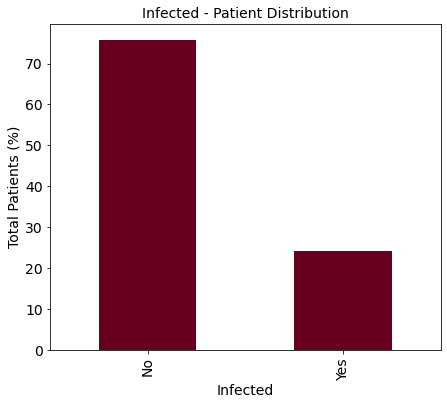

In [9]:
# Plot bar chart to compare Infected vs Non Infected patients

plt.figure(figsize = (7,6))
(data['infected'].value_counts(normalize = True)*100).plot.bar(colormap = 'RdBu')
plt.xticks((0,1),('No','Yes'),fontsize = 14) # Change labels for easier interpretation
plt.yticks(fontsize = 14)
plt.xlabel('Infected',fontsize = 14)
plt.ylabel('Total Patients (%)',fontsize = 14)
plt.title('Infected - Patient Distribution',fontsize = 14)
plt.show()

In [10]:
data.infected.value_counts(normalize = True)

0    0.7586
1    0.2414
Name: infected, dtype: float64

We can see from the above that the class distribution in our data is quite skewed towards non-infected patients. Prior to splitting the dataset to train the model, we will fix this class imbalance.

**Age: Univariate Analysis**

Now, we will take a look at the only numeric feature that is part of our data. We will use a seaborn based histogram to see how the age of our patients are spread out.

C:\Users\arvin\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Age - Density Plot')

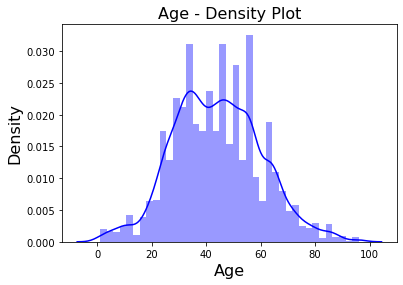

In [11]:
# Use seaborn to visualize distribution of patient age

age_plot = sns.distplot(data['age_year'], color = 'Blue')

age_plot.set_xlabel('Age', fontsize = 16)
age_plot.set_ylabel('Density', fontsize = 16)
age_plot.set_title('Age - Density Plot', fontsize = 16)

We can see that age follows a pattern close to normal distribution with middle age patients being at the higher end compared to others. We will try bucketing the data and see which age groups jump out more than others.

C:\Users\arvin\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='age_year', ylabel='Density'>

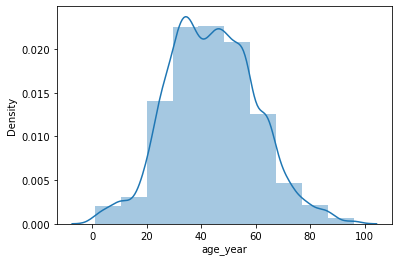

In [12]:
sns.distplot(data['age_year'], bins = 10)

We can see that the highest number of patients in our dataset fall between 20 and 60. We'll look at the percentage shares for different buckets.

In [13]:
# Create column age_group to bucket data

data['age_group'] = pd.cut(data['age_year'],[0,10,20,40,60,80,100], precision = 0, labels = ['0-10','10-20','20-40','40-60','60-80','80-100'])

In [14]:
# View sample 

data[['age_year','age_group']].head()

,age_year,age_group
0,89,80-100
1,68,60-80
2,68,60-80
3,68,60-80
4,50,40-60


In [15]:
# Check count for each age group

data['age_group'].value_counts()

40-60     2666
20-40     2458
60-80      912
10-20      248
0-10       123
80-100     105
Name: age_group, dtype: int64

In [16]:
# Check percentages for each age group

round(data['age_group'].value_counts(normalize = True)*100,1)

40-60     40.9
20-40     37.7
60-80     14.0
10-20      3.8
0-10       1.9
80-100     1.6
Name: age_group, dtype: float64

It is clear now that the patients of age between 40-60 and 20-40 are the highest and second highest respectively and cumulatively add up to nearly 80% of the dataset.

**Unvariate Analysis - Independent Binary Features**

We will now look at the other independent features which include gender, various symptoms, travel history and isolation treatment to understand their distribution within our dataset. We will interpret this by calculating % total of patients who fall into either of the binary categories.

In [17]:
# Create a list of all the binary columns necessary

binary_cols = data.drop(['age_year','age_group','infected'],1).columns

In [18]:
for i in enumerate(binary_cols):
    print(data[i[1]].value_counts())

1    3367
0    3145
Name: gender, dtype: int64
0    3837
1    2675
Name: fever, dtype: int64
0    4537
1    1975
Name: cough, dtype: int64
0    5963
1     549
Name: runny_nose, dtype: int64
0    6486
1      26
Name: muscle_soreness, dtype: int64
0    6025
1     487
Name: pneumonia, dtype: int64
0    6475
1      37
Name: diarrhea, dtype: int64
0    5657
1     855
Name: lung_infection, dtype: int64
1    4239
0    2273
Name: travel_history, dtype: int64
0    5099
1    1413
Name: isolation_treatment, dtype: int64


In [19]:
for i in enumerate(binary_cols):
    print(round(data[i[1]].value_counts(normalize = True)*100),2)

1    52.0
0    48.0
Name: gender, dtype: float64 2
0    59.0
1    41.0
Name: fever, dtype: float64 2
0    70.0
1    30.0
Name: cough, dtype: float64 2
0    92.0
1     8.0
Name: runny_nose, dtype: float64 2
0    100.0
1      0.0
Name: muscle_soreness, dtype: float64 2
0    93.0
1     7.0
Name: pneumonia, dtype: float64 2
0    99.0
1     1.0
Name: diarrhea, dtype: float64 2
0    87.0
1    13.0
Name: lung_infection, dtype: float64 2
1    65.0
0    35.0
Name: travel_history, dtype: float64 2
0    78.0
1    22.0
Name: isolation_treatment, dtype: float64 2


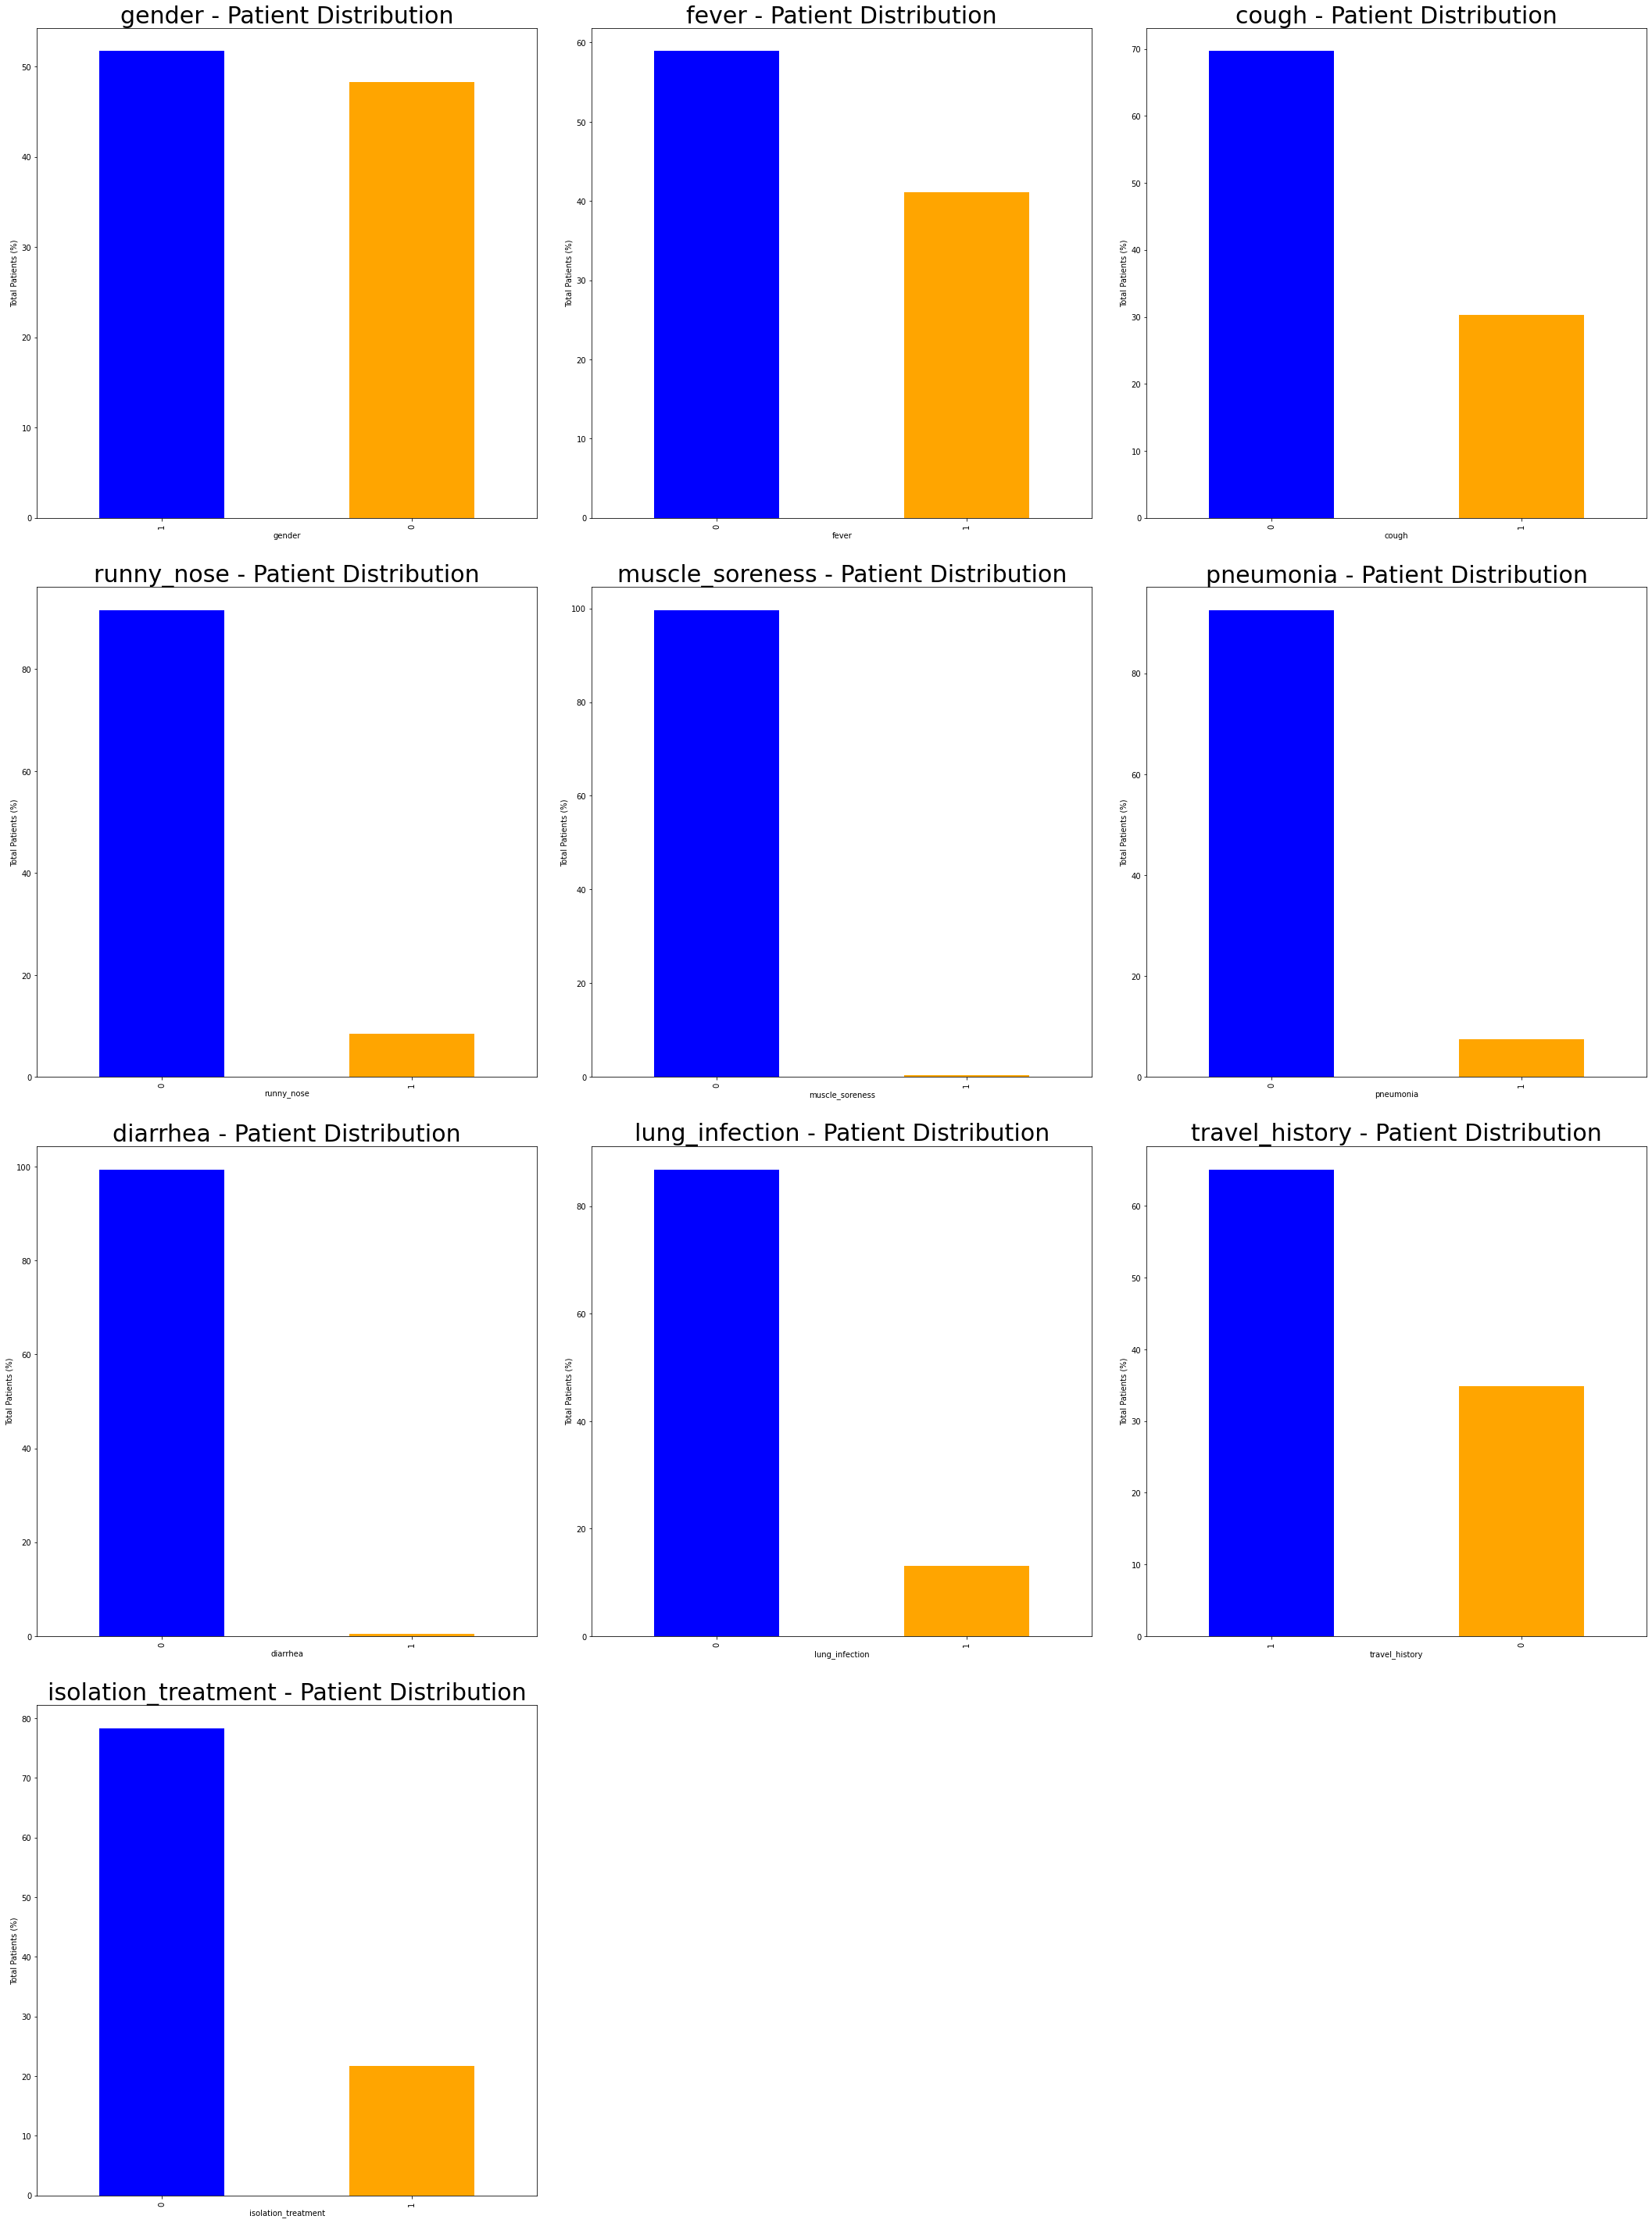

In [20]:
# Plot bar charts for each independent binary feature

plt.figure(figsize = (30,40))
for i in enumerate(binary_cols):
    plt.subplot(4,3,i[0]+1)
    plt.tight_layout(pad = 3) # Padding used to add space between boxplots
    (data[i[1]].value_counts(normalize = True)*100).plot.bar(color = ['blue','orange'])
    #if i[1] == 'gender':
     #   plt.xticks((0,1),('Female','Male'))
    #else:
     #   plt.xticks((0,1),('No','Yes'))
    plt.xlabel(i[1])
    plt.ylabel('Total Patients (%)')
    plt.title('{} - Patient Distribution'.format(i[1]),fontsize = 30)

From the above barcharts, we observe the following:-

* Ratio of male to female patients in our dataset is balanced with the female % being slightly higher.
* Fever and Cough are the most common symptoms among our patients with an approximately 40% and 30% share respectively.
* Data available on all other symptoms are highly skewed towards patients not exhibiting them. 
    * About 15% and 10% of patients show symptoms of lung infection and runny nose.
    * Penumonia patients are less than 10%.
    * Patients with Diarrhea and muscle soreness are of neglible numbers in our dataset.
    * Patie


**Bivariate Analysis - Infected vs Independent Binary Features**

Let us now look at our various patient attributes such as gender, symptoms, travel history and isolation treatment in comparison to the target variable - 'infected'. We will plot each of the binary variables using mean which would basically sum up the 1s and 0s and give us a percentage of total. For better readability, we will split the visualization into two in order to accomodate all binary features adequately.

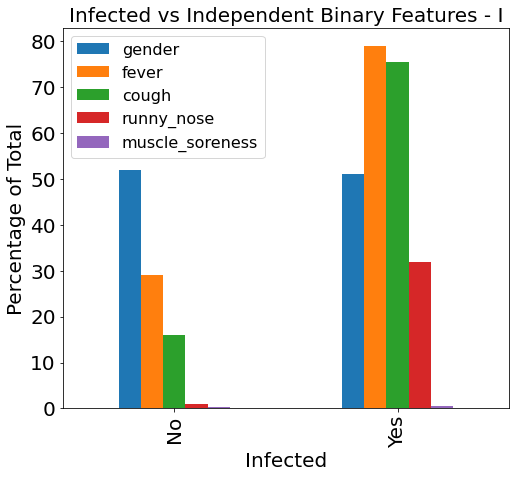

In [21]:
# Plot the bar graph for first set of binary attributes

(data[['gender', 'fever', 'cough', 'runny_nose', 'muscle_soreness','infected']].groupby('infected').mean()*100).plot.bar(figsize = (8,7))
plt.legend(fontsize=16)
plt.xticks((0,1),('No','Yes'),fontsize = 20)
plt.yticks(fontsize = 20)
plt.xlabel('Infected',fontsize = 20)
plt.ylabel('Percentage of Total',fontsize = 20)
plt.title('Infected vs Independent Binary Features - I',fontsize = 20)
plt.show()

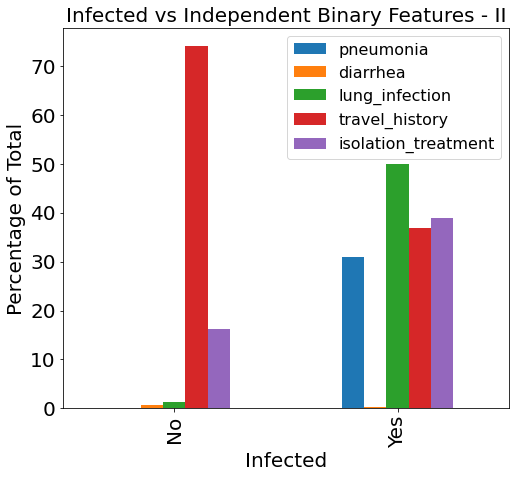

In [22]:
# Plot the bar graph for second set of binary attributes

(data[['pneumonia','diarrhea', 'lung_infection', 'travel_history',
       'isolation_treatment', 'infected']].groupby('infected').mean()*100).plot.bar(figsize = (8,7))
plt.legend(fontsize=16)
plt.xticks((0,1),('No','Yes'),fontsize = 20)
plt.yticks(fontsize = 20)
plt.xlabel('Infected',fontsize = 20)
plt.ylabel('Percentage of Total',fontsize = 20)
plt.title('Infected vs Independent Binary Features - II',fontsize = 20)
plt.show()

We will now look at all other features vs Age to get a perspective on the spread of patient age relative to symptoms, travel history, isolation treatment and even our target variable that indicates infection.

**Bivariate Analaysis -  Age vs Other Features**

Since all other features are binary in nature, we will plot Age against each of them using boxplots to view its spread.

In [23]:
# Create a list of all the binary columns necessary

data['disease'] = data['infected'].replace({1:'Infected',0:'Not Infected'})
binary_cols = data.drop(['age_year','age_group','infected'],1).columns

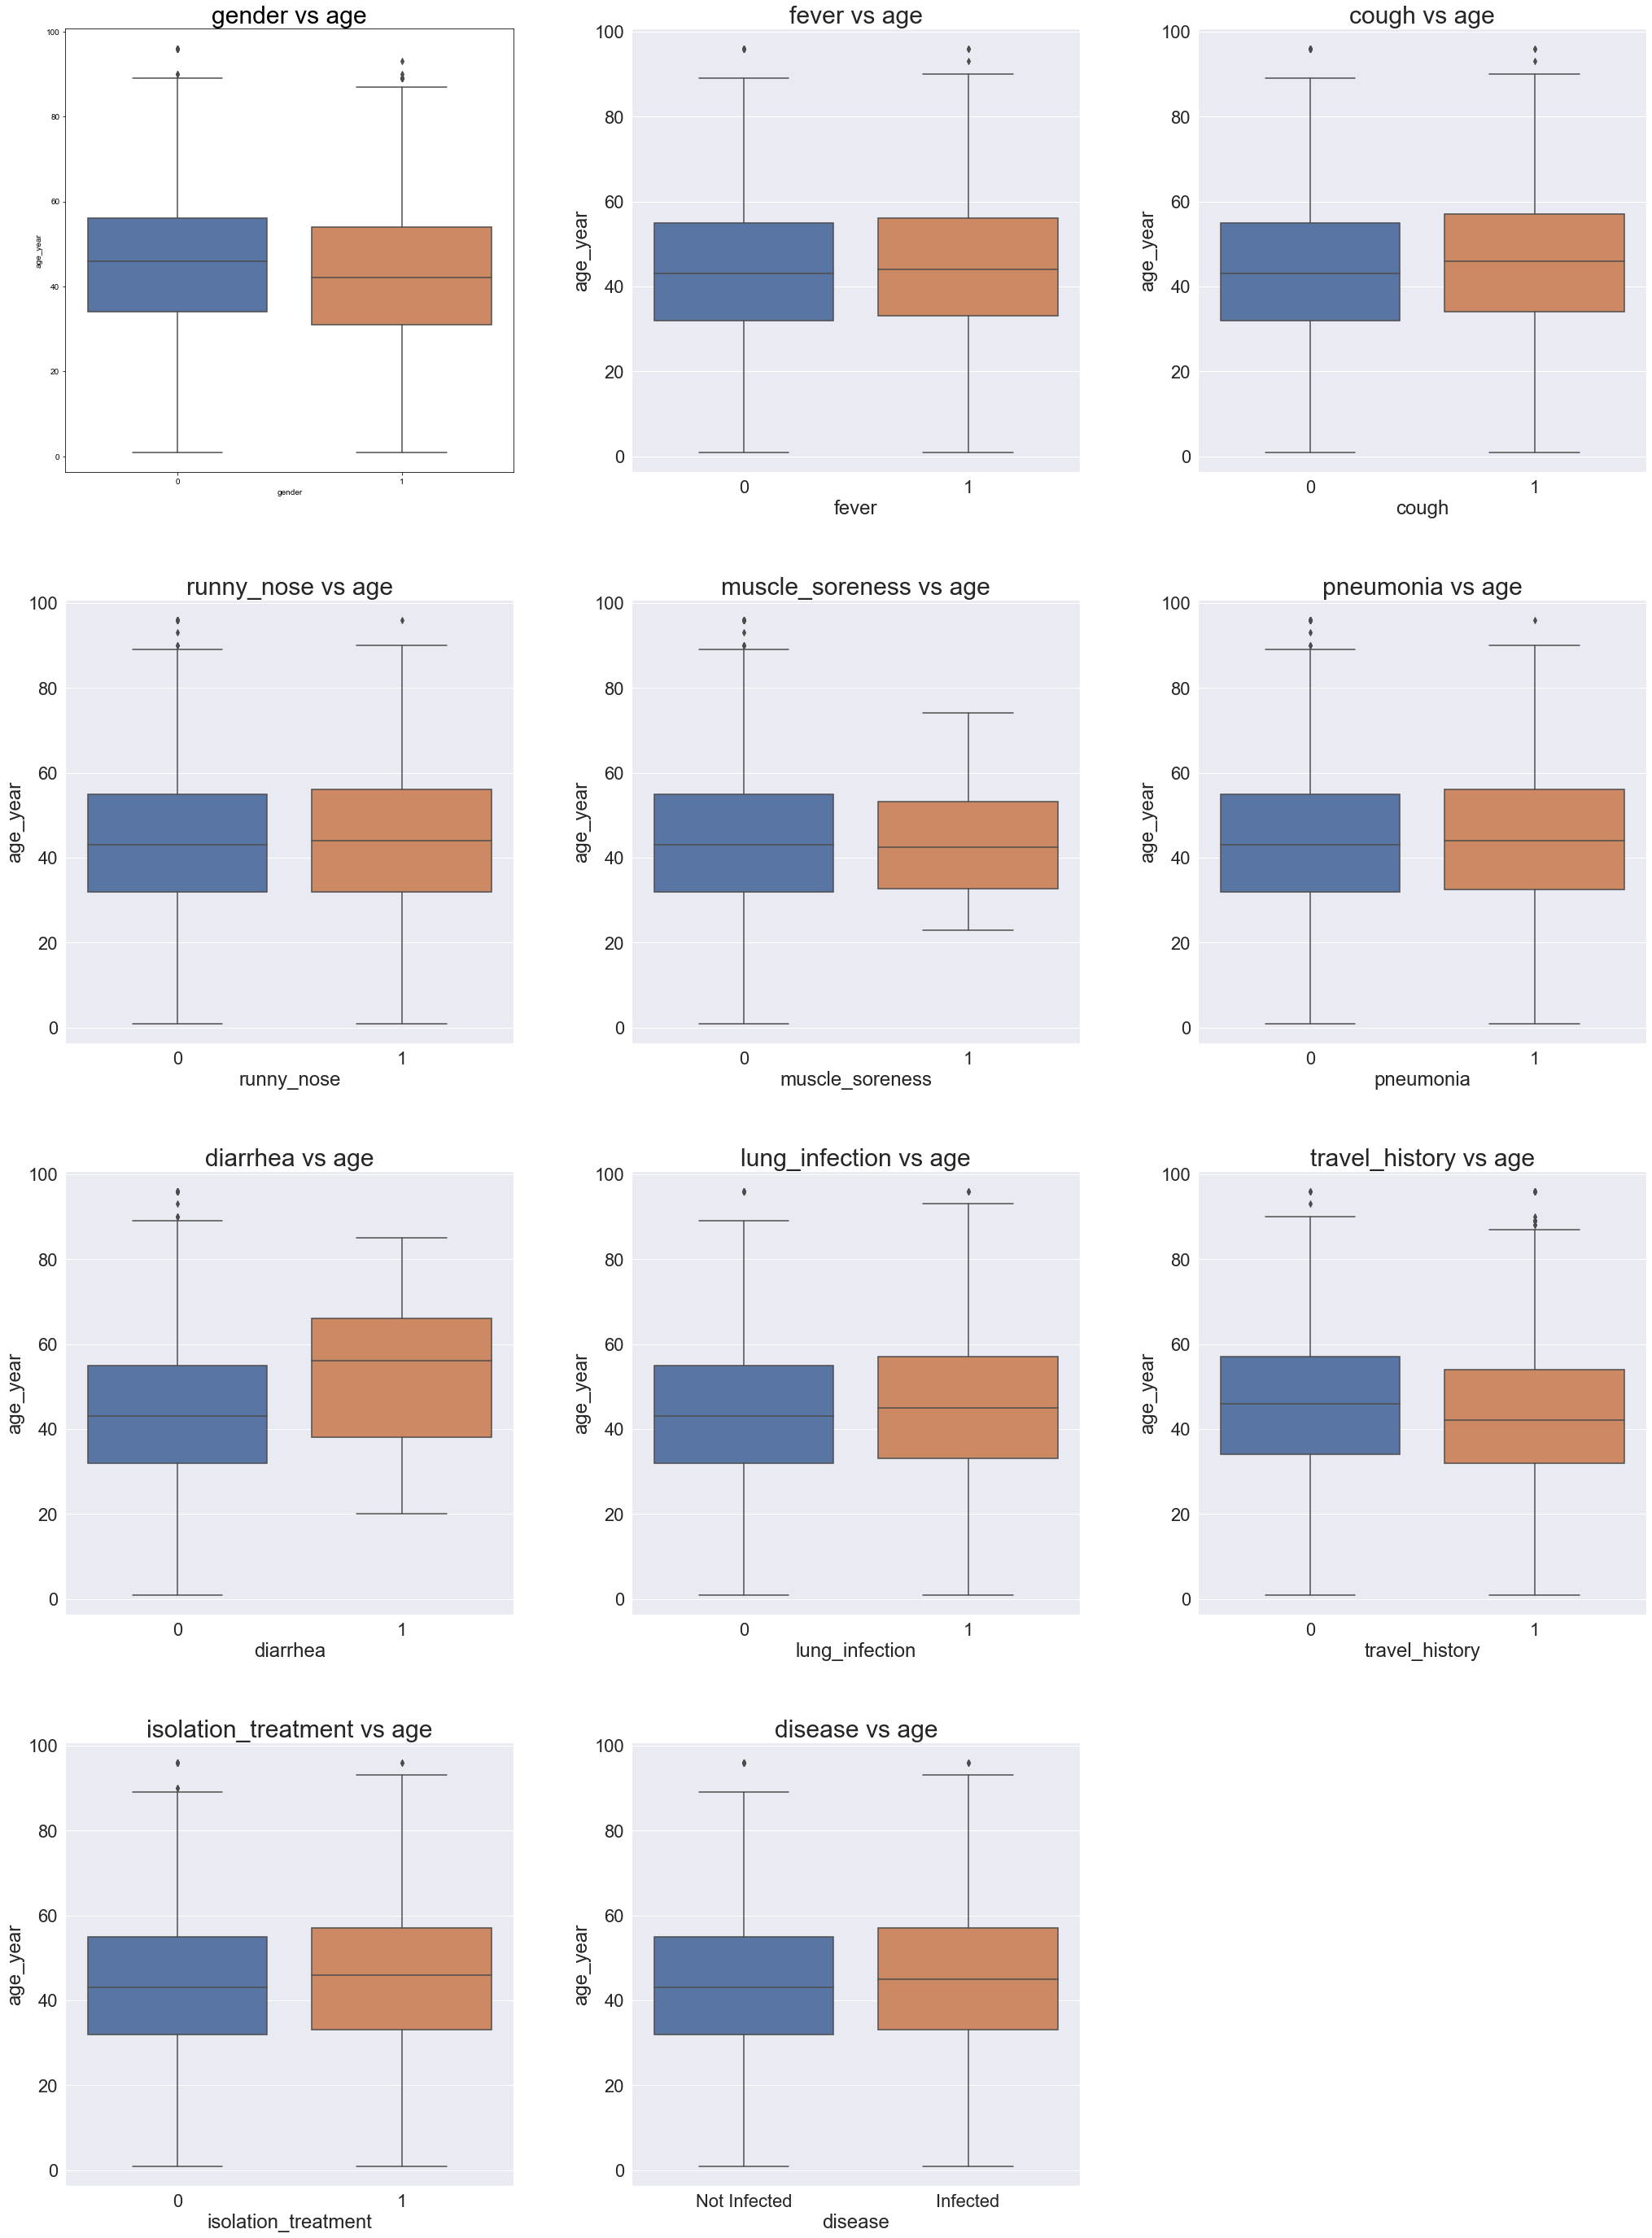

In [24]:
plt.figure(figsize = (30,40))

for i in enumerate(binary_cols):
    plt.subplot(4,3,i[0]+1)
    plt.tight_layout(pad = 3) # Padding used to add space between boxplots
    sns.set(font_scale = 2) # Changes font size for ticks, labels, titles
    sns.boxplot(x = data[i[1]], y = data['age_year'])
    plt.title('{} vs age'.format(i[1]),fontsize = 30)

From the above boxplots, we are able to note the following:-

* Median age of female patients is slightly higher in our dataset.
* Fever, runny nose and peumonia symptoms affect patients of different ages in the same manner, irrespective of whether they are infected with Covid-19 or not. The minimum, maximum and median ages of the patients hardly show any differences between infected vs non infected patients.
* 

**Bivariate Analysis -  Age Groups vs Binary Attributes**

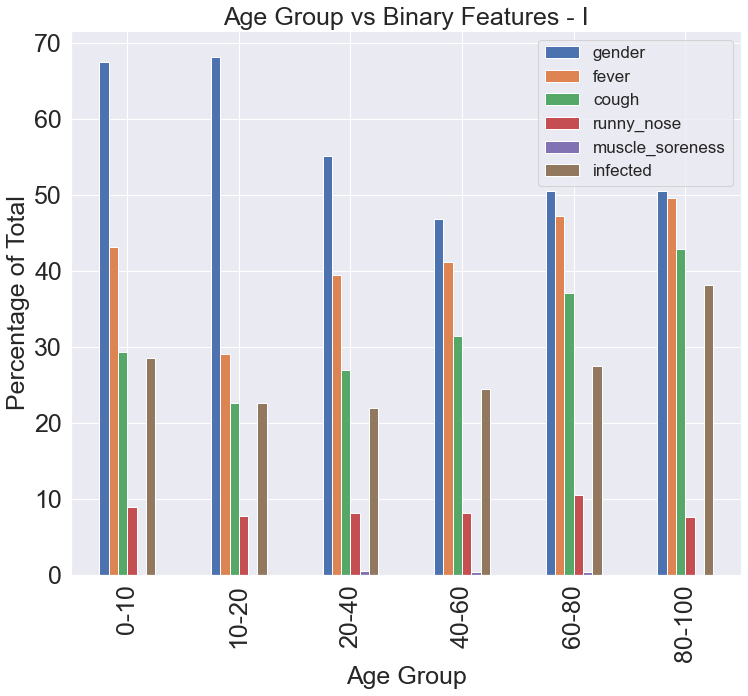

In [25]:
# Plot the bar graph for first set of binary attributes

(data[['gender', 'fever', 'cough', 'runny_nose', 'muscle_soreness','infected','age_group']].groupby('age_group').mean()*100).plot.bar(figsize = (12,10))
plt.legend(fontsize=17, loc = 'upper right')
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
plt.xlabel('Age Group',fontsize = 25)
plt.ylabel('Percentage of Total',fontsize = 25)
plt.title('Age Group vs Binary Features - I',fontsize = 25)
plt.show()

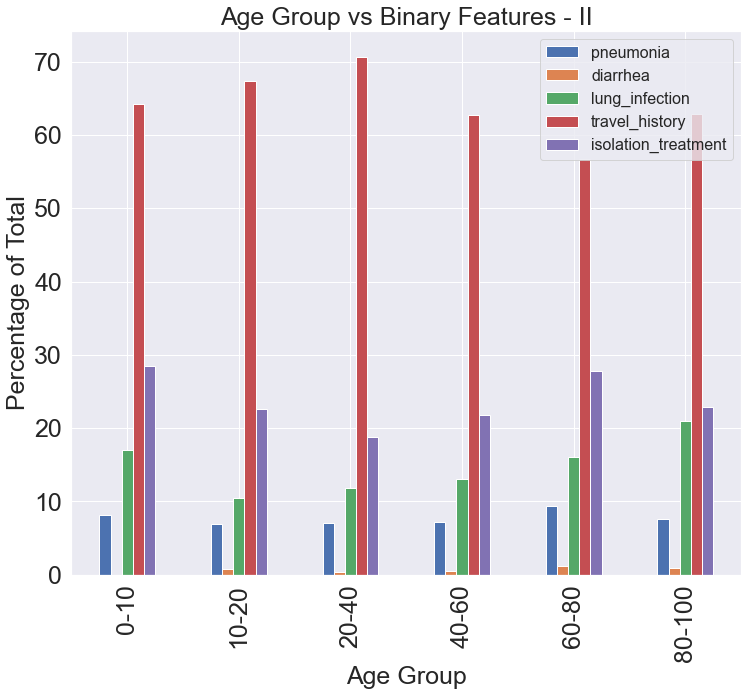

In [26]:
# Plot the bar graph for second set of binary attributes

(data[['pneumonia','diarrhea', 'lung_infection', 'travel_history',
       'isolation_treatment','age_group']].groupby('age_group').mean()*100).plot.bar(figsize = (12,10))
plt.legend(fontsize=16, loc = 'upper right')
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
plt.xlabel('Age Group',fontsize = 25)
plt.ylabel('Percentage of Total',fontsize = 25)
plt.title('Age Group vs Binary Features - II',fontsize = 25)
plt.show()

For the next steps, we will not be requiring the derived column 'age_group' since the data is already captured in 'age_year' and will result in multicollinearity.

In [27]:
# Drop age_group

data.drop(['age_group','disease'],1,inplace = True)

In [28]:
# View sample dataset

data.head()

,gender,age_year,fever,cough,runny_nose,muscle_soreness,pneumonia,diarrhea,lung_infection,travel_history,isolation_treatment,infected
0,1,89,1,1,0,0,0,0,0,1,0,0
1,1,68,1,0,0,0,0,0,0,0,0,0
2,1,68,0,0,0,0,0,0,0,1,0,0
3,1,68,1,1,0,0,0,0,0,1,1,1
4,1,50,1,1,1,0,1,0,0,1,0,1


## 2. Model Building

### Divide Dataset: Train-Test Split

In [29]:
# Assign all independent variables to X

X = data.drop('infected',axis = 1)
X.head()

,gender,age_year,fever,cough,runny_nose,muscle_soreness,pneumonia,diarrhea,lung_infection,travel_history,isolation_treatment
0,1,89,1,1,0,0,0,0,0,1,0
1,1,68,1,0,0,0,0,0,0,0,0
2,1,68,0,0,0,0,0,0,0,1,0
3,1,68,1,1,0,0,0,0,0,1,1
4,1,50,1,1,1,0,1,0,0,1,0


In [30]:
# Assign the dependent variable to y

y = data['infected']
y.head()

0    0
1    0
2    0
3    1
4    1
Name: infected, dtype: int64

In [31]:
# Split the data into train and test sets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,train_size = 0.7, random_state = 50)

In [32]:
data.shape

(6512, 12)

In [33]:
X_train.shape

(4558, 11)

In [34]:
X_test.shape

(1954, 11)

Now that we have split the data, normally we would perform feature scaling on numeric variables so as to bring them all on the same scale, making them useful for meaningful comparisons which also helps model building and interpretability. However, this is required only when several numeric variables are present in the dataset and ours only has one (age) while all others are binary variables. We will therefore skip this step and move on.

### Data Imbalance Treatment

We saw earlier during EDA that the target variable in our dataset is highly skewed towards patients without Covid-19 infection. This will affect model prediction capability as a skewed dependent variable can result in poor performance in the prediction of the minority class (positive infections). To tackle this problem, we will treat the imbalance issue using SMOTE (Synthetic Minority Oversampling Technique). 

SMOTE works by selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line.

Specifically, a random example from the minority class is first chosen. Then k of the nearest neighbors for that example are found (typically k=5). A randomly selected neighbor is chosen and a synthetic example is created at a randomly selected point between the two examples in feature space.

SMOTE will be applied only to the training set which will be used for model building.

In [35]:
# Import necessary library

from imblearn.over_sampling import SMOTE

In [36]:
# Check X_train and y_train dimensions for comparison

print(X_train.shape)
print(y_train.shape)

(4558, 11)
(4558,)


In [37]:
# Check y_train skewedness prior to treatment for comparison

round(y_train.value_counts(normalize = True),2)

0    0.76
1    0.24
Name: infected, dtype: float64

In [980]:
# Check y_test skewedness prior to treatment for comparison

round(y_test.value_counts(normalize = True),2)

0    0.75
1    0.25
Name: infected, dtype: float64

In [38]:
# Instantiate SMOTE followed by assigning balanced X_train and y_train to new variables

oversample = SMOTE(random_state = 50)

X_train_bal,y_train_bal = oversample.fit_resample(X_train,y_train)

In [39]:
# Check X_train_bal and y_train_bal dimensions for comparison

print(X_train_bal.shape)
print(y_train_bal.shape)

(6956, 11)
(6956,)


In [40]:
# Check y_train_bal to check for current variable skewdness

round(y_train_bal.value_counts(normalize = True),2)

0    0.5
1    0.5
Name: infected, dtype: float64

We can see that the newly created X_train_bal and y_train_bal have more datapoints and the skewdness towards the majority class is no longer present. Using the newly balanced training sets, we will now move on to the next phase - building a model using Logistic Regression.

In [41]:
# Create copy of X_train_bal, y_train_bal for use in Decision Tree, RF and XGBoost

X_train_bal_copy = X_train_bal.copy()
y_train_bal_copy =  y_train_bal.copy()

### Logistic Regression

We will first use StatsModels to check p-value of the remaining features to see if they are statistically significant and VIF to check for multicollinearity. This process may be iterated a few times to refine on our Logistic Regression based predictive model in case we find that we need to drop one or more variables.

We will not be using Recursive Feature Elimination (RFE) to reduce the number of features in our dataset since they are already a manageable number.

**Building First Iteration - StatsModel 1**

In [131]:
# Build model 1

lr1 = sm.GLM(y_train_bal,(sm.add_constant(X_train_bal)),family = sm.families.Binomial())
model1 = lr1.fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               infected   No. Observations:                 6956
Model:                            GLM   Df Residuals:                     6944
Model Family:                Binomial   Df Model:                           11
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2403.2
Date:                Wed, 08 Dec 2021   Deviance:                       4806.5
Time:                        17:49:37   Pearson chi2:                 7.20e+03
No. Iterations:                    26                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -1.0342      0.133     -7.759      0.000      -1.295      -0.773
gender                 -0.1642      0.074     -2.229      0.026      -0.309      -0.020
age_year               -0.0034      0.002     -1.538      0.124      -0.008       0.001
fever                   0.5895      0.119      4.957      0.000       0.356       0.823
cough                   1.9422      0.120     16.201      0.000       1.707       2.177
runny_nose             -2.0939      0.371     -5.651      0.000      -2.820      -1.368
muscle_soreness        -2.5272      0.912     -2.772      0.006      -4.314      -0.740
pneumonia              27.1009    1.5e+04      0.002      0.999   -2.95e+04    2.95e+04
diarrhea               -3.5312      0.737     -4.793      0.000      -4.975      -2.087
lung_infection          3.8253      0.163     23.507      0.000       3.506       4.144
travel_history         -1.1008      0.077    -14.316      0.000      -1.251      -0.950
isolation_treatment     0.1335      0.093      1.441      0.150      -0.048       0.315
=======================================================================================
"""

Three features have a p-value that is greater than the acceptable threshold of 0.05. Let us look at multicollinearity as well using Variance Inflation Factor (VIF) before deciding which feature to eliminate first.

In [132]:
#Calculate VIF for StatsModel 1

#Create a dataframe to insert VIF values and compare features

vif = pd.DataFrame()
vif['Features'] = X_train_bal.columns
vif['VIF'] = [variance_inflation_factor(X_train_bal.values,i) for i in range(X_train_bal.shape[1])]
vif['VIF'] = round(vif['VIF'],2)
vif.sort_values(by = 'VIF', ascending = False, inplace = True)

In [133]:
# View the vif dataframe

vif

,Features,VIF
4,runny_nose,20.11
6,pneumonia,19.95
3,cough,6.93
2,fever,6.89
1,age_year,3.62
9,travel_history,2.02
8,lung_infection,1.93
0,gender,1.73
10,isolation_treatment,1.48
5,muscle_soreness,1.01


We can see there are variables with high VIFs (Greater than or equal to 5). The priority we will follow to remove features is as follows:-

* High-High: High p-value, high VIF
* High-Low:
    * High p-value, low VIF
    * Low p-value, high VIF

Feature elimination will be only one at a time as p-value and VIF of other features may stabilize upon dropping a feature.

Going by the above process, we will first eliminate **pneumonia** since it has the highest p-value as well as VIF.

In [134]:
# Drop feature 'pneumonia'

X_train_bal.drop('pneumonia',axis = 1, inplace = True)

We will move to the next round of model building using Statsmodels to view the refreshed p-value and VIF. Before that, let us create functions for further use as this process is likely to be repetitive.

In [148]:
# Create statsmodels function

def statsmodels_func(X_train,y_train):
    X_train = sm.add_constant(X_train)
    lr = sm.GLM(y_train,X_train, family = sm.families.Binomial())
    global lr_model
    lr_model = lr.fit()
    print(lr_model.summary())
    
# Create VIF function

def vif_calc(X_train):

    #Create a dataframe to insert VIF values and compare features

    vif = pd.DataFrame()
    vif['Features'] = X_train.columns
    vif['VIF'] = [variance_inflation_factor(X_train.values,i) for i in range(X_train.shape[1])]
    vif['VIF'] = round(vif['VIF'],2)
    vif.sort_values(by = 'VIF', ascending = False, inplace = True)
    print(vif)

**Building Second Iteration - StatsModel 2**

We use statsmodels_func to create the next iteration of the model and generate model summary


In [136]:
# Build model 2 and generate model summary

statsmodels_func(X_train_bal,y_train_bal)

                 Generalized Linear Model Regression Results                  
Dep. Variable:               infected   No. Observations:                 6956
Model:                            GLM   Df Residuals:                     6945
Model Family:                Binomial   Df Model:                           10
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2481.6
Date:                Wed, 08 Dec 2021   Deviance:                       4963.3
Time:                        17:49:38   Pearson chi2:                 8.07e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -1.0716    

This time we have four features with high p-values. Let us look at VIF as well.

In [137]:
# Check vif values

vif_calc(X_train_bal)

              Features   VIF
3                cough  6.93
2                fever  6.89
1             age_year  3.62
8       travel_history  2.02
4           runny_nose  1.95
7       lung_infection  1.90
0               gender  1.73
9  isolation_treatment  1.47
5      muscle_soreness  1.01
6             diarrhea  1.01


Although there are features with high VIF, going by our defined priorities for feature elimination, we will remove the feature **isolation_treatment** which has the highest p-value of 0.35.

In [138]:
# Drop 'isolation_treatment'

X_train_bal.drop('isolation_treatment',axis = 1, inplace = True)

**Statsmodels 3**

In [139]:
# Build model 3 and generate model summary

statsmodels_func(X_train_bal,y_train_bal)

                 Generalized Linear Model Regression Results                  
Dep. Variable:               infected   No. Observations:                 6956
Model:                            GLM   Df Residuals:                     6946
Model Family:                Binomial   Df Model:                            9
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2482.1
Date:                Wed, 08 Dec 2021   Deviance:                       4964.1
Time:                        17:49:38   Pearson chi2:                 8.11e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -1.0694      0.132     

In [140]:
# Check vif values

vif_calc(X_train_bal)

          Features   VIF
3            cough  6.90
2            fever  6.87
1         age_year  3.60
8   travel_history  1.99
4       runny_nose  1.92
7   lung_infection  1.74
0           gender  1.73
5  muscle_soreness  1.01
6         diarrhea  1.01


In this iteration, we observe that there are two features with high p-values and a couple of others indicating high VIF. We will remove **age_year** which has the highest p-value.

In [141]:
# Drop 'age_year'

X_train_bal.drop('age_year',1,inplace = True)

**Statsmodel 4**

In [142]:
# Build model 4 and generate model summary

statsmodels_func(X_train_bal,y_train_bal)

                 Generalized Linear Model Regression Results                  
Dep. Variable:               infected   No. Observations:                 6956
Model:                            GLM   Df Residuals:                     6947
Model Family:                Binomial   Df Model:                            8
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2482.9
Date:                Wed, 08 Dec 2021   Deviance:                       4965.8
Time:                        17:49:38   Pearson chi2:                 8.09e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -1.2041      0.083    -

In [143]:
# Check vif values

vif_calc(X_train_bal)

          Features   VIF
1            fever  6.73
2            cough  6.69
3       runny_nose  1.89
6   lung_infection  1.60
0           gender  1.59
7   travel_history  1.43
4  muscle_soreness  1.01
5         diarrhea  1.00


With no other features present with high p-values, we will remove **gender**.

In [144]:
# Drop 'gender'

X_train_bal.drop('gender',1,inplace = True)

**Statsmodel 5**

In [145]:
# Build model 5 and generate model summary

statsmodels_func(X_train_bal,y_train_bal)

                 Generalized Linear Model Regression Results                  
Dep. Variable:               infected   No. Observations:                 6956
Model:                            GLM   Df Residuals:                     6948
Model Family:                Binomial   Df Model:                            7
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2484.4
Date:                Wed, 08 Dec 2021   Deviance:                       4968.8
Time:                        17:49:38   Pearson chi2:                 8.11e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -1.2696      0.075    -

In [146]:
# Check vif values

vif_calc(X_train_bal)

          Features   VIF
1            cough  6.68
0            fever  6.63
2       runny_nose  1.88
5   lung_infection  1.59
6   travel_history  1.19
3  muscle_soreness  1.01
4         diarrhea  1.00


We see that there are no features with high p-values, but there are a couple with high VIF. In this iteration, we will remove **cough** which has the highest VIF of 6.68.

In [147]:
# Drop 'cough'

X_train_bal.drop('cough',1,inplace = True)

**Statmodel 6**

In [148]:
# Build model 6 and generate model summary

statsmodels_func(X_train_bal,y_train_bal)

                 Generalized Linear Model Regression Results                  
Dep. Variable:               infected   No. Observations:                 6956
Model:                            GLM   Df Residuals:                     6949
Model Family:                Binomial   Df Model:                            6
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2640.1
Date:                Wed, 08 Dec 2021   Deviance:                       5280.1
Time:                        17:49:38   Pearson chi2:                 7.16e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -1.0387      0.070    -

In [149]:
# Check vif values

vif_calc(X_train_bal)

          Features   VIF
1       runny_nose  1.80
0            fever  1.66
4   lung_infection  1.58
5   travel_history  1.15
2  muscle_soreness  1.01
3         diarrhea  1.00


It seems that we have arrived at a logistic regression model that includes features with acceptable p-values and VIF. We will therefore use Statsmodel 6 to proceed with the next steps of model building.

We will start by predicting the probabilities of infection using Statmodel 6 and then add them to a dataframe for further processing.

In [150]:
# Predict probability of infection for train set

lr6 = sm.GLM(y_train_bal,(sm.add_constant(X_train_bal)),family = sm.families.Binomial())
lr_model6 = lr6.fit()
y_train_pred = lr_model6.predict(sm.add_constant(X_train_bal))

# View a sample of the predicted probabilities
y_train_pred[:5]

0    0.080006
1    0.080006
2    0.794608
3    0.080006
4    0.080006
dtype: float64

In [151]:
# Reshape y_train_pred into an array to add later in dataframe

y_train_pred = y_train_pred.values.reshape(-1)

In [152]:
# Create dataframe

y_train_pred_df = pd.DataFrame({'Infected':y_train_bal.values,'Infected_Prob':y_train_pred})
y_train_pred_df['PatientID'] = y_train_bal.index
y_train_pred_df.head()

,Infected,Infected_Prob,PatientID
0,0,0.080006,0
1,0,0.080006,1
2,1,0.794608,2
3,0,0.080006,3
4,0,0.080006,4


A Logistic Regression model is fine tuned by calculating the optimal probability threshold. The threshold will be used by the model to strike a balance between different performance metrics when predicting whether the patient has been infected or not. But before this, we will look at the ROC curve.

**ROC Curve**

We will now draw up the ROC cuve to understand the model's effectiveness in classification. An ROC curve is useful to understand the following:-

* It shows the tradeoff between the performance metrics, sensitivity and specificity (any increase in sensitivity will be accompanied by a decrease in specificity).
* The closer the curve follows the left-hand border and then the top border of the ROC space, the more accurate the test. A good model will tend to hug the Y Axis (True Positive Rate).
* The closer the curve comes to the 45-degree diagonal of the ROC space, the less accurate the test.  A less than good model tends to be closed to the X Axis (False Positive Rate or 1 - True Negative Rate (Specificity).

In [176]:
# Create a function to draw up the ROC curve

def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(8, 7))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]',fontsize = 14)
    plt.ylabel('True Positive Rate',fontsize = 14)
    plt.title('Receiver operating characteristic (ROC)',fontsize = 14)
    plt.legend(loc="lower right",fontsize = 14)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.show()

    return None

In [155]:
# Assign values to the axes in the ROC curve

fpr, tpr, thresholds = metrics.roc_curve(y_train_pred_df.Infected, y_train_pred_df.Infected_Prob, drop_intermediate = False )

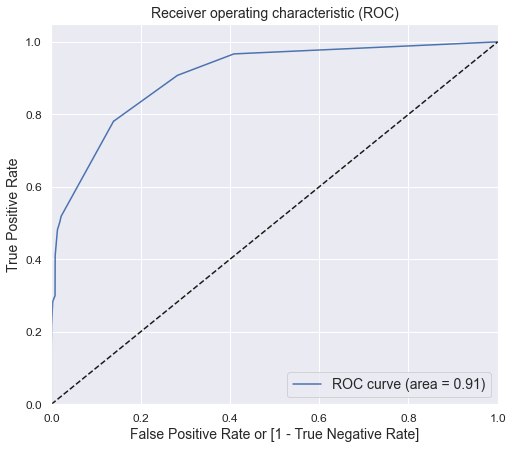

In [156]:
# Generate the ROC curve

draw_roc(y_train_pred_df.Infected, y_train_pred_df.Infected_Prob)

We see that our ROC curve has an area of 0.91 which is good. The next steps will be to find the optimal probability threshold.

**Find Optimal Cutoff Point**

In [157]:
# Add different possible thresholds to our dataframe

num = [float (i/10) for i in range(10)]
for i in num:
    y_train_pred_df[i] = y_train_pred_df.Infected_Prob.map(lambda x: 1 if x > i else 0)

In [158]:
# Print dataframe

y_train_pred_df.head()

,Infected,Infected_Prob,PatientID,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0,0.080006,0,1,0,0,0,0,0,0,0,0,0
1,0,0.080006,1,1,0,0,0,0,0,0,0,0,0
2,1,0.794608,2,1,1,1,1,1,1,1,1,0,0
3,0,0.080006,3,1,0,0,0,0,0,0,0,0,0
4,0,0.080006,4,1,0,0,0,0,0,0,0,0,0


In order to find the optimal threshold/cutoff point, we will need to calculate all the important metrics for these different thresholds - Sensitivity, Specificity & Accuracy - plot them and find the intersection where all of these metrics are balanced out in the model.

In [159]:
# Create a dataframe to store metrics for different thresholds

df_threshold = pd.DataFrame(columns = ['prob','accuracy','sensitivity','specificity'])

for i in num:
    cm = metrics.confusion_matrix(y_train_pred_df.Infected,y_train_pred_df[i])
    accuracy = metrics.accuracy_score(y_train_pred_df.Infected,y_train_pred_df[i])
    sensitivity = cm[1,1]/(cm[1,1]+cm[1,0])
    specificity = cm[0,0]/(cm[0,0]+cm[0,1])
    df_threshold.loc[i] = [i,accuracy,sensitivity,specificity]

    
df_threshold

,prob,accuracy,sensitivity,specificity
0.0,0.0,0.500000,1.000000,0.000000
0.1,0.1,0.778608,0.966935,0.590282
0.2,0.2,0.778896,0.966935,0.590857
0.3,0.3,0.812392,0.908281,0.716504
0.4,0.4,0.820730,0.781484,0.859977
0.5,0.5,0.820730,0.781196,0.860265
0.6,0.6,0.820730,0.781196,0.860265
0.7,0.7,0.820874,0.781196,0.860552
0.8,0.8,0.733611,0.480736,0.986486
0.9,0.9,0.732749,0.479011,0.986486


We will now plot the different values of each of the metrics to find the intersection where all them are balanced for our model.

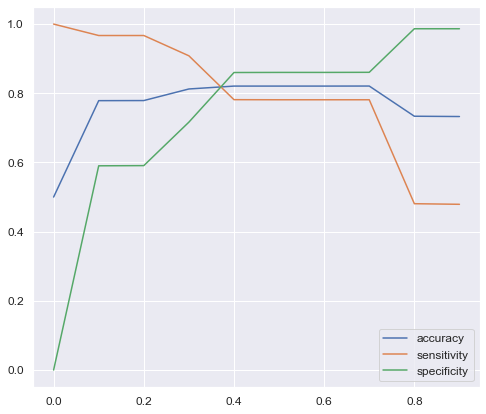

In [160]:
# Plot line graphs

df_threshold[['accuracy','sensitivity','specificity']].plot(figsize = (8,7))
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.legend(fontsize = 12)

The optimal threshold seems to lie somewhere between 0.35 and 0.4. Let us calculate the metrics for this range of values as well.

In [161]:
# Update the dataframe to store metrics for the new thresholds

new_num = [0.35,0.36,0.37,0.375,0.38,0.385,0.39,0.395,0.3975]

for i in new_num:
    y_train_pred_df[i] = y_train_pred_df.Infected_Prob.map(lambda x: 1 if x > i else 0)

y_train_pred_df.head()

,Infected,Infected_Prob,PatientID,0.0,0.1,0.2,0.3,0.4,0.5,0.6,...,0.9,0.35,0.36,0.37,0.375,0.38,0.385,0.39,0.395,0.3975
0,0,0.080006,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0.080006,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0.794608,2,1,1,1,1,1,1,1,...,0,1,1,1,1,1,1,1,1,1
3,0,0.080006,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0.080006,4,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [162]:
# Update df_threshold

for i in new_num:
    cm = metrics.confusion_matrix(y_train_pred_df.Infected,y_train_pred_df[i])
    accuracy = metrics.accuracy_score(y_train_pred_df.Infected,y_train_pred_df[i])
    sensitivity = cm[1,1]/(cm[1,1]+cm[1,0])
    specificity = cm[0,0]/(cm[0,0]+cm[0,1])
    df_threshold.loc[i] = [i,accuracy,sensitivity,specificity]

# sort the thresholds in ascending order for plotting

df_threshold.sort_values(by = 'prob', ascending = True, inplace = True)

df_threshold

,prob,accuracy,sensitivity,specificity
0.0000,0.0000,0.500000,1.000000,0.000000
0.1000,0.1000,0.778608,0.966935,0.590282
0.2000,0.2000,0.778896,0.966935,0.590857
0.3000,0.3000,0.812392,0.908281,0.716504
0.3500,0.3500,0.812536,0.908281,0.716791
0.3600,0.3600,0.812536,0.908281,0.716791
0.3700,0.3700,0.812536,0.908281,0.716791
0.3750,0.3750,0.812536,0.908281,0.716791
0.3800,0.3800,0.812536,0.908281,0.716791
0.3850,0.3850,0.812536,0.908281,0.716791


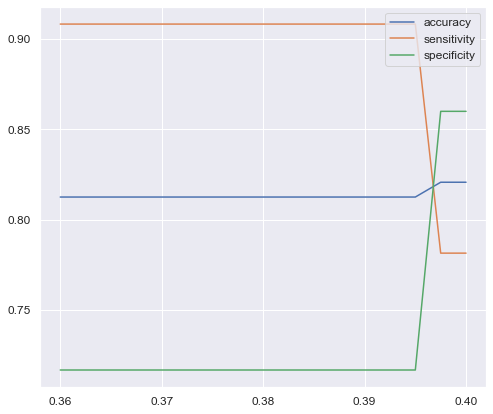

In [163]:
# Plot the graph only for probabilities between 0.35 and 0.4

df_threshold.loc[(df_threshold.prob > 0.35) & (df_threshold.prob <= 0.4),['accuracy','sensitivity','specificity']].plot(figsize = (8,7))
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.legend(fontsize = 12)

Let's fine tune the X-axis values in order to visualize the optimal threshold better.

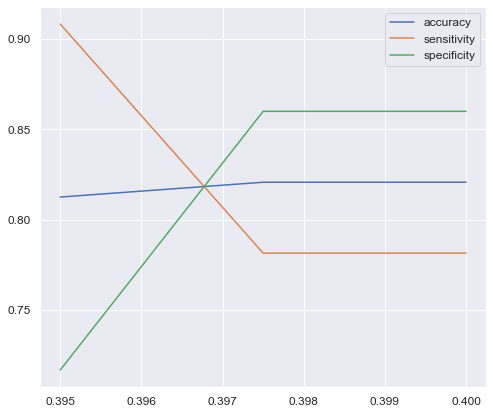

In [164]:
# Plot the graph only for probabilities between 0.39 and 0.4

df_threshold.loc[(df_threshold.prob > 0.39) & (df_threshold.prob <= 0.4),['accuracy','sensitivity','specificity']].plot(figsize = (8,7))
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.legend(fontsize = 12)

From the above graph, we see that the optimal probability threshold lies between 0.3965 and 0.397. Since the graph indicates that it is in the middle of these two values, we will take it as **0.39655**. We will use this value to map the final predictions of our statsmodel 6 in our table **y_train_pred_df**.

In [165]:
# Map the final predictions into our table based on the calculated probability threshold

y_train_pred_df['prediction'] = y_train_pred_df['Infected_Prob'].map(lambda x: 1 if x > 0.39655 else 0)

In [166]:
# View a sample

y_train_pred_df.head()

,Infected,Infected_Prob,PatientID,0.0,0.1,0.2,0.3,0.4,0.5,0.6,...,0.35,0.36,0.37,0.375,0.38,0.385,0.39,0.395,0.3975,prediction
0,0,0.080006,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0.080006,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0.794608,2,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,0,0.080006,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0.080006,4,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [167]:
# Keep only necessary columns for better readability

y_train_pred_df = y_train_pred_df[['Infected','Infected_Prob','PatientID','prediction']]

In [168]:
# View sample

y_train_pred_df.head()

,Infected,Infected_Prob,PatientID,prediction
0,0,0.080006,0,0
1,0,0.080006,1,0
2,1,0.794608,2,1
3,0,0.080006,3,0
4,0,0.080006,4,0


Let us evaluate the performance of the model based on the four performance metrics of our choice - Accuracy, Precision, Recall, F1 Score.

In [169]:
# Calculate accuracy

accuracy_train_LR = metrics.accuracy_score(y_train_pred_df.Infected,y_train_pred_df.prediction)
accuracy_train_LR

0.8207303047728579

We will create a confusion matrix to aid in calculating Precision and Recall.

In [170]:
# Create confusion matrix

confusion_train_LR = metrics.confusion_matrix(y_train_pred_df.Infected,y_train_pred_df.prediction)
confusion_train_LR

array([[2991,  487],
       [ 760, 2718]], dtype=int64)

In [171]:
# Calculate Precision (TP /TP + FP)

precision_train_LR = confusion_train_LR[1,1]/(confusion_train_LR[1,1] + confusion_train_LR[0,1])
precision_train_LR

0.8480499219968799

In [172]:
# Calculate Recall (TP /TP + FN)

recall_train_LR = confusion_train_LR[1,1]/(confusion_train_LR[1,1] + confusion_train_LR[1,0])
recall_train_LR

0.7814836112708453

In [173]:
# Calculate F1 Score

f1_score_train_LR = 2 * (recall_train_LR * precision_train_LR)/(recall_train_LR + precision_train_LR)
f1_score_train_LR

0.8134071524764328

**Test Set Performance**

In [174]:
# Set same columns for X_test

X_test_bal = X_test[X_train_bal.columns]

In [175]:
# Predict probability of infection for test set

y_test_pred = lr_model6.predict(sm.add_constant(X_test_bal))

# View a sample of the predicted probabilities
y_test_pred[:5]

1696    0.080006
880     0.080006
4555    0.080006
4121    0.396000
829     0.080006
dtype: float64

In [176]:
# Create dataframe

y_test_pred_df = pd.DataFrame({'Infected':y_test.values,'Infected_Prob':y_test_pred})
y_test_pred_df['PatientID'] = y_test.index
y_test_pred_df.head()

,Infected,Infected_Prob,PatientID
1696,0,0.080006,1696
880,0,0.080006,880
4555,0,0.080006,4555
4121,0,0.396000,4121
829,0,0.080006,829


In [177]:
# Add test prediction to dataframe

y_test_pred_df['test_prediction'] = y_test_pred_df.Infected_Prob.map(lambda x: 1 if x >0.39655 else 0)

In [178]:
y_test_pred_df.head()

,Infected,Infected_Prob,PatientID,test_prediction
1696,0,0.080006,1696,0
880,0,0.080006,880,0
4555,0,0.080006,4555,0
4121,0,0.396000,4121,0
829,0,0.080006,829,0


In [179]:
# Calculate test accuracy

accuracy_test_LR = metrics.accuracy_score(y_test_pred_df.Infected,y_test_pred_df.test_prediction)
accuracy_test_LR

0.8326509723643808

We will create a confusion matrix to aid in calculating Precision and Recall.

In [180]:
# Create confusion matrix

confusion_test_LR = metrics.confusion_matrix(y_test_pred_df.Infected,y_test_pred_df.test_prediction)
confusion_test_LR

array([[1248,  214],
       [ 113,  379]], dtype=int64)

In [181]:
# Calculate Precision (TP /TP + FP)

precision_test_LR = confusion_test_LR[1,1]/(confusion_test_LR[1,1] + confusion_test_LR[0,1])
precision_test_LR

0.6391231028667791

In [182]:
# Calculate Recall (TP /TP + FN)

recall_test_LR = confusion_test_LR[1,1]/(confusion_test_LR[1,1] + confusion_test_LR[1,0])
recall_test_LR

0.7703252032520326

In [183]:
# Calculate F1 Score

f1_score_test_LR = 2 * (recall_test_LR * precision_test_LR)/(recall_test_LR + precision_test_LR)
f1_score_test_LR

0.6986175115207374

### Decision Trees

In [339]:
# Instantiate Decision Tree

dt_balanced = DecisionTreeClassifier(random_state = 50, class_weight = 'balanced')
#dt_smote = DecisionTreeClassifier(random_state = 50)

Try using class_weight='balanced' above as an experiment.

In [340]:
# Parameters for DT

params = {'max_depth':[2,4,6,8,10,12,15,18,20,22,25,28,30,32,36,40],
          'min_samples_split':[10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100],
          'min_samples_leaf': [10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100]
         }

In [341]:
# Instantiate GridSearchCV - basis f1 score - dt_balanced

grid_search_f1_balanced = GridSearchCV(estimator = dt_balanced,
                           cv = 4,
                          param_grid = params,
                          n_jobs = -1,
                          verbose = 1,
                          scoring = 'f1')

In [343]:
%%time

# Fit data - f1 score -dt_balanced

grid_search_f1_balanced.fit(X_train,y_train)

Fitting 4 folds for each of 5776 candidates, totalling 23104 fits
Wall time: 1min 30s


GridSearchCV(cv=4,
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=50),
             n_jobs=-1,
             param_grid={'max_depth': [2, 4, 6, 8, 10, 12, 15, 18, 20, 22, 25,
                                       28, 30, 32, 36, 40],
                         'min_samples_leaf': [10, 15, 20, 25, 30, 35, 40, 45,
                                              50, 55, 60, 65, 70, 75, 80, 85,
                                              90, 95, 100],
                         'min_samples_split': [10, 15, 20, 25, 30, 35, 40, 45,
                                               50, 55, 60, 65, 70, 75, 80, 85,
                                               90, 95, 100]},
             scoring='f1', verbose=1)

In [345]:
grid_search_f1_balanced.best_params_

{'max_depth': 8, 'min_samples_leaf': 15, 'min_samples_split': 100}

In [374]:
# Next Parameters for DT

params1 = {'max_depth':[8],
          'min_samples_leaf':[15],
          'min_samples_split': [100,110,120,130,140,150,160,170,180,190,200]
         }

In [375]:
# Instantiate GridSearchCV - basis f1 score - dt_balanced

grid_search_f1_balanced1 = GridSearchCV(estimator = dt_balanced,
                           cv = 4,
                          param_grid = params1,
                          n_jobs = -1,
                          verbose = 1,
                          scoring = 'f1')

In [376]:
%%time

# Fit data - f1 score -dt_balanced

grid_search_f1_balanced1.fit(X_train,y_train)

Fitting 4 folds for each of 11 candidates, totalling 44 fits
Wall time: 301 ms


GridSearchCV(cv=4,
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=50),
             n_jobs=-1,
             param_grid={'max_depth': [8], 'min_samples_leaf': [15],
                         'min_samples_split': [100, 110, 120, 130, 140, 150,
                                               160, 170, 180, 190, 200]},
             scoring='f1', verbose=1)

In [377]:
grid_search_f1_balanced1.best_params_

{'max_depth': 8, 'min_samples_leaf': 15, 'min_samples_split': 120}

In [353]:
# Save the best performing model - balanced - f1 score

dt_best_f1_balanced = grid_search_f1_balanced1.best_estimator_

In [354]:
dt_best_f1_balanced

DecisionTreeClassifier(class_weight='balanced', max_depth=8,
                       min_samples_leaf=15, min_samples_split=120,
                       random_state=50)

In [50]:
# Function to evaluate model

def evaluate_model(classifier,X_train,X_test,y_train,y_test):
    
    cm_train = confusion_matrix(y_train, classifier.predict(X_train))
    precision_train = cm_train[1,1]/(cm_train[1,1] + cm_train[0,1])
    recall_train = cm_train[1,1]/(cm_train[1,1] + cm_train[1,0])
    f1_score_train = 2 *(precision_train * recall_train)/ (precision_train + recall_train)
    
    cm_test = confusion_matrix(y_test, classifier.predict(X_test))
    precision_test = cm_test[1,1]/(cm_test[1,1] + cm_test[0,1])
    recall_test = cm_test[1,1]/(cm_test[1,1] + cm_test[1,0])
    f1_score_test = 2 *(precision_test * recall_test)/ (precision_test + recall_test)
    
    print("Train Confusion Matrix: \n",cm_train)
    print("Train Accuracy :", accuracy_score(y_train, classifier.predict(X_train)))
    print('Train Precision: ',precision_train)
    print('Train Recall: ',recall_train)
    print('Train F1 Score: ',f1_score_train)
    print("-"*50)
    print("Test Confusion Matrix: \n", cm_test)
    print("Test Accuracy :", accuracy_score(y_test, classifier.predict(X_test)))
    print('Test Precision: ',precision_test)
    print('Test Recall: ',recall_test)
    print('Test F1 Score: ',f1_score_test)


In [193]:
#gph = get_dt_graph(dt_best_f1)
#Image(gph.create_png())

In [968]:
# DT Model Evaluation - balanced - f1 score

dt_f1_eval_balanced = evaluate_model(dt_best_f1_balanced,X_train,X_test,y_train,y_test)
dt_f1_eval_balanced

Train Confusion Matrix: 
 [[3058  420]
 [ 109  971]]
Train Accuracy : 0.8839403247038174
Train Precision:  0.698058950395399
Train Recall:  0.899074074074074
Train F1 Score:  0.7859166329421287
--------------------------------------------------
Test Confusion Matrix: 
 [[1285  177]
 [  63  429]]
Test Accuracy : 0.8771750255885363
Test Precision:  0.7079207920792079
Test Recall:  0.8719512195121951
Test F1 Score:  0.7814207650273225


The model built based on the f1 scoring parameter is a better choice due to all the performance metrics being either equal to or better than model built on accuracy score param.

### Random Forest

In [196]:
# Import necessary packages

from sklearn.ensemble import RandomForestClassifier

In [411]:
# Instantiate Random Forest

rf_balanced = RandomForestClassifier(random_state =50, class_weight = 'balanced')
#rf_smote = RandomForestClassifier(random_state =50)

In [412]:
# CV parameters

params = {'max_depth':[8,10,15,20,25],
          'min_samples_split':[15,20,30,40,50,60,80,100],
          'min_samples_leaf': [10,20,40,60,80,90,100],
          'n_estimators':[10, 30, 50, 100]
         }

In [413]:
# Instantiate GridSearchCV - basis f1 score - rf_balanced

grid_search_f1_balanced = GridSearchCV(estimator = rf_balanced,
                           cv = 4,
                          param_grid = params,
                          n_jobs = -1,
                          verbose = 1,
                          scoring = 'f1')

In [504]:
%%time

# Fit data - f1 score - rf_balanced

grid_search_f1_balanced.fit(X_train,y_train)

Fitting 4 folds for each of 1120 candidates, totalling 4480 fits
Wall time: 3min 54s


GridSearchCV(cv=4,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=50),
             n_jobs=-1,
             param_grid={'max_depth': [8, 10, 15, 20, 25],
                         'min_samples_leaf': [10, 20, 40, 60, 80, 90, 100],
                         'min_samples_split': [15, 20, 30, 40, 50, 60, 80, 100],
                         'n_estimators': [10, 30, 50, 100]},
             scoring='f1', verbose=1)

In [505]:
grid_search_f1_balanced.best_params_

{'max_depth': 15,
 'min_samples_leaf': 10,
 'min_samples_split': 30,
 'n_estimators': 10}

In [515]:
# CV parameters

params1 = {'max_depth':[12,14,15,18],
          'min_samples_split':[25,28,30,32,36],
          'min_samples_leaf': [6,8,10],
          'n_estimators':[10,12,13,14]
         }

In [516]:
# Instantiate GridSearchCV - basis f1 score - rf_balanced

grid_search_f1_balanced1 = GridSearchCV(estimator = rf_balanced,
                           cv = 4,
                          param_grid = params1,
                          n_jobs = -1,
                          verbose = 1,
                          scoring = 'f1')

In [517]:
%%time

# Fit data - f1 score - rf_balanced

grid_search_f1_balanced1.fit(X_train,y_train)

Fitting 4 folds for each of 240 candidates, totalling 960 fits
Wall time: 20.9 s


GridSearchCV(cv=4,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=50),
             n_jobs=-1,
             param_grid={'max_depth': [12, 14, 15, 18],
                         'min_samples_leaf': [6, 8, 10],
                         'min_samples_split': [25, 28, 30, 32, 36],
                         'n_estimators': [10, 12, 13, 14]},
             scoring='f1', verbose=1)

In [518]:
grid_search_f1_balanced1.best_params_

{'max_depth': 15,
 'min_samples_leaf': 8,
 'min_samples_split': 28,
 'n_estimators': 10}

In [519]:
# Save the best performing model - smote - f1 score

rf_best_f1_balanced = grid_search_f1_balanced1.best_estimator_

In [969]:
# RF Model Evaluation - balanced - f1 score

rf_f1_eval_balanced = evaluate_model(rf_best_f1_balanced,X_train,X_test,y_train,y_test)
rf_f1_eval_balanced

Train Confusion Matrix: 
 [[2981  497]
 [  98  982]]
Train Accuracy : 0.8694602896007021
Train Precision:  0.6639621365787695
Train Recall:  0.9092592592592592
Train F1 Score:  0.7674872997264557
--------------------------------------------------
Test Confusion Matrix: 
 [[1254  208]
 [  55  437]]
Test Accuracy : 0.8654042988741044
Test Precision:  0.6775193798449612
Test Recall:  0.8882113821138211
Test F1 Score:  0.7686895338610379


### XGBoost

In [2173]:
#! pip install xgboost

In [521]:
# Import necessary packages

from xgboost import XGBClassifier

In [814]:
# Instantiate XGBoost


xgb_balanced = XGBClassifier(objective = 'binary:logistic',subsample = 0.9,colsample_bytree = 0.5,random_state =50)

In [815]:
# CV parameters

params = {'max_depth':[3,4,5,6],
          'learning_rate': [0.1,0.01,0.05],
          'gamma': [0,0.25,0.5],
          'reg_lambda': [0,1.0,3.0,5.0],
          'scale_pos_weight': [1,3,5]
         }

In [816]:
# Instantiate GridSearchCV - basis auc score - xgb_balanced

grid_search_auc_balanced = GridSearchCV(estimator = xgb_balanced,
                           cv = 4,
                          param_grid = params,
                          n_jobs = -1,
                          verbose = 1,
                          scoring = 'f1')

In [817]:
%%time

# Fit data - auc score - xgb_balanced

grid_search_auc_balanced.fit(X_train,y_train, 
                            early_stopping_rounds = 20,
                            eval_metric = 'auc',
                           eval_set = [(X_test,y_test)])
                                      

Fitting 4 folds for each of 432 candidates, totalling 1728 fits
[0]	validation_0-auc:0.80665
[1]	validation_0-auc:0.89067
[2]	validation_0-auc:0.85842
[3]	validation_0-auc:0.91115
[4]	validation_0-auc:0.89828
[5]	validation_0-auc:0.91736
[6]	validation_0-auc:0.91561
[7]	validation_0-auc:0.91993
[8]	validation_0-auc:0.92088
[9]	validation_0-auc:0.92267
[10]	validation_0-auc:0.92333
[11]	validation_0-auc:0.92309
[12]	validation_0-auc:0.92397
[13]	validation_0-auc:0.92475
[14]	validation_0-auc:0.92648
[15]	validation_0-auc:0.92617
[16]	validation_0-auc:0.93010
[17]	validation_0-auc:0.93036
[18]	validation_0-auc:0.93024


C:\Users\arvin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19]	validation_0-auc:0.92989
[20]	validation_0-auc:0.93008
[21]	validation_0-auc:0.93067
[22]	validation_0-auc:0.93077
[23]	validation_0-auc:0.93144
[24]	validation_0-auc:0.93137
[25]	validation_0-auc:0.93065
[26]	validation_0-auc:0.93016
[27]	validation_0-auc:0.93079
[28]	validation_0-auc:0.93279
[29]	validation_0-auc:0.93300
[30]	validation_0-auc:0.93300
[31]	validation_0-auc:0.93285
[32]	validation_0-auc:0.93339
[33]	validation_0-auc:0.93339
[34]	validation_0-auc:0.93313
[35]	validation_0-auc:0.93237
[36]	validation_0-auc:0.93194
[37]	validation_0-auc:0.93103
[38]	validation_0-auc:0.93175
[39]	validation_0-auc:0.93198
[40]	validation_0-auc:0.93173
[41]	validation_0-auc:0.93214
[42]	validation_0-auc:0.93219
[43]	validation_0-auc:0.93214
[44]	validation_0-auc:0.93236
[45]	validation_0-auc:0.93244
[46]	validation_0-auc:0.93258
[47]	validation_0-auc:0.93269
[48]	validation_0-auc:0.93282
[49]	validation_0-auc:0.93278
[50]	validation_0-auc:0.93386
[51]	validation_0-auc:0.93420
[52]	valid

GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.5,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n...
                                     num_parallel_tree=None, predictor=None,
                                     random_state=50, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                      

In [819]:
# Best params

grid_search_auc_balanced.best_params_

{'gamma': 0.5,
 'learning_rate': 0.1,
 'max_depth': 5,
 'reg_lambda': 1.0,
 'scale_pos_weight': 3}

In [824]:
# CV parameters

params1 = {'max_depth':[3,4,5],
          'learning_rate': [0.08,0.1,0.15],
          'gamma': [0.5],
          'reg_lambda': [0.35,0.5],
          'scale_pos_weight': [2,3,4,5]
         }

In [825]:
# Instantiate GridSearchCV - basis auc score - xgb_balanced

grid_search_auc_balanced1 = GridSearchCV(estimator = xgb_balanced,
                           cv = 4,
                          param_grid = params1,
                          n_jobs = -1,
                          verbose = 1,
                          scoring = 'f1')

In [826]:
%%time

# Fit data - auc score - xgb_balanced

grid_search_auc_balanced1.fit(X_train,y_train, 
                            early_stopping_rounds = 20,
                            eval_metric = 'auc',
                           eval_set = [(X_test,y_test)])
                                      

Fitting 4 folds for each of 72 candidates, totalling 288 fits
[0]	validation_0-auc:0.80665
[1]	validation_0-auc:0.89287
[2]	validation_0-auc:0.87866
[3]	validation_0-auc:0.91286
[4]	validation_0-auc:0.89924
[5]	validation_0-auc:0.91880
[6]	validation_0-auc:0.91764
[7]	validation_0-auc:0.92068
[8]	validation_0-auc:0.92026
[9]	validation_0-auc:0.92322
[10]	validation_0-auc:0.92370
[11]	validation_0-auc:0.92314
[12]	validation_0-auc:0.92384
[13]	validation_0-auc:0.92444
[14]	validation_0-auc:0.92645
[15]	validation_0-auc:0.92551
[16]	validation_0-auc:0.92904
[17]	validation_0-auc:0.92903
[18]	validation_0-auc:0.92905
[19]	validation_0-auc:0.92898
[20]	validation_0-auc:0.92957
[21]	validation_0-auc:0.93006
[22]	validation_0-auc:0.93008
[23]	validation_0-auc:0.93188
[24]	validation_0-auc:0.93179
[25]	validation_0-auc:0.93085
[26]	validation_0-auc:0.92986
[27]	validation_0-auc:0.93065
[28]	validation_0-auc:0.93205
[29]	validation_0-auc:0.93200
[30]	validation_0-auc:0.93245
[31]	validation_0-

C:\Users\arvin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[37]	validation_0-auc:0.93210
[38]	validation_0-auc:0.93297
[39]	validation_0-auc:0.93318
[40]	validation_0-auc:0.93290
[41]	validation_0-auc:0.93361
[42]	validation_0-auc:0.93366
[43]	validation_0-auc:0.93344
[44]	validation_0-auc:0.93299
[45]	validation_0-auc:0.93305
[46]	validation_0-auc:0.93302
[47]	validation_0-auc:0.93337
[48]	validation_0-auc:0.93342
[49]	validation_0-auc:0.93351
[50]	validation_0-auc:0.93418
[51]	validation_0-auc:0.93475
[52]	validation_0-auc:0.93478
[53]	validation_0-auc:0.93483
[54]	validation_0-auc:0.93490
[55]	validation_0-auc:0.93531
[56]	validation_0-auc:0.93550
[57]	validation_0-auc:0.93543
[58]	validation_0-auc:0.93556
[59]	validation_0-auc:0.93551
[60]	validation_0-auc:0.93574
[61]	validation_0-auc:0.93552
[62]	validation_0-auc:0.93568
[63]	validation_0-auc:0.93580
[64]	validation_0-auc:0.93583
[65]	validation_0-auc:0.93596
[66]	validation_0-auc:0.93604
[67]	validation_0-auc:0.93603
[68]	validation_0-auc:0.93598
[69]	validation_0-auc:0.93612
[70]	valid

GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.5,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n...=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=50, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                

In [829]:
# Best params

grid_search_auc_balanced1.best_params_

{'gamma': 0.5,
 'learning_rate': 0.1,
 'max_depth': 4,
 'reg_lambda': 0.5,
 'scale_pos_weight': 2}

In [831]:
# Final model

xgb_balanced_final = grid_search_auc_balanced1.best_estimator_

In [832]:
best_iteration = xgb_balanced_final.get_booster().best_iteration
best_iteration

76

In [536]:
# Function to evaluate model

def evaluate_model_xgboost(classifier,X_train,X_test,y_train,y_test,best_iteration):
    
    cm_train = confusion_matrix(y_train, classifier.predict(X_train,ntree_limit=best_iteration))
    precision_train = cm_train[1,1]/(cm_train[1,1] + cm_train[0,1])
    recall_train = cm_train[1,1]/(cm_train[1,1] + cm_train[1,0])
    f1_score_train = 2 *(precision_train * recall_train)/ (precision_train + recall_train)
    
    cm_test = confusion_matrix(y_test, classifier.predict(X_test,ntree_limit=best_iteration))
    precision_test = cm_test[1,1]/(cm_test[1,1] + cm_test[0,1])
    recall_test = cm_test[1,1]/(cm_test[1,1] + cm_test[1,0])
    f1_score_test = 2 *(precision_test * recall_test)/ (precision_test + recall_test)
    
    print("Train Confusion Matrix: \n",cm_train)
    print("Train Accuracy :", accuracy_score(y_train, classifier.predict(X_train,ntree_limit=best_iteration)))
    print('Train Precision: ',precision_train)
    print('Train Recall: ',recall_train)
    print('Train F1 Score: ',f1_score_train)
    print("-"*50)
    print("Test Confusion Matrix: \n", cm_test)
    print("Test Accuracy :", accuracy_score(y_test, classifier.predict(X_test,ntree_limit=best_iteration)))
    print('Test Precision: ',precision_test)
    print('Test Recall: ',recall_test)
    print('Test F1 Score: ',f1_score_test)


In [976]:
evaluate_model_xgboost(xgb_balanced_final,X_train,X_test,y_train,y_test,best_iteration)

Train Confusion Matrix: 
 [[3074  404]
 [ 108  972]]
Train Accuracy : 0.887670030715226
Train Precision:  0.7063953488372093
Train Recall:  0.9
Train F1 Score:  0.7915309446254073
--------------------------------------------------
Test Confusion Matrix: 
 [[1284  178]
 [  62  430]]
Test Accuracy : 0.8771750255885363
Test Precision:  0.7072368421052632
Test Recall:  0.8739837398373984
Test F1 Score:  0.7818181818181817


C:\Users\arvin\anaconda3\lib\site-packages\xgboost\core.py:108: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
C:\Users\arvin\anaconda3\lib\site-packages\xgboost\core.py:108: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
C:\Users\arvin\anaconda3\lib\site-packages\xgboost\core.py:108: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
C:\Users\arvin\anaconda3\lib\site-packages\xgboost\core.py:108: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


### Support Vector Machines

In [854]:
# Import necessary package

from sklearn.svm import SVC

In [856]:
# Instantiate SVC

svm_balanced = SVC(class_weight = 'balanced',random_state = 50)

In [853]:
# CV parameters

params = {'C':[0.5,1,3,5,10],
          'gamma': ['scale',0,0.25,0.5,1,0.1,0.01],
          'kernel': ['rbf'] 
        }

kernel set to rbf as our data is non linear.

In [45]:
# Fit the data

grid_search_svm_balanced = GridSearchCV(estimator = svm_balanced,
                                        cv = 4,
                                       param_grid = params,
                                       n_jobs = -1,
                                       verbose = 1,
                                       scoring = 'f1')

In [46]:
%%time

grid_search_svm_balanced.fit(X_train,y_train)

Fitting 4 folds for each of 35 candidates, totalling 140 fits
Wall time: 1min 3s


GridSearchCV(cv=4, estimator=SVC(class_weight='balanced', random_state=50),
             n_jobs=-1,
             param_grid={'C': [0.5, 1, 3, 5, 10],
                         'gamma': ['scale', 0, 0.25, 0.5, 1, 0.1, 0.01],
                         'kernel': ['rbf']},
             scoring='f1', verbose=1)

In [857]:
# View best params

grid_search_svm_balanced.best_params_

{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}

In [58]:
# CV parameters

params1 = {'C':[6,7,8,9,10],
          'gamma': [0.1],
          'kernel': ['rbf'] 
        }

In [59]:
# Fit the data

grid_search_svm_balanced1 = GridSearchCV(estimator = svm_balanced,
                                        cv = 4,
                                       param_grid = params1,
                                       n_jobs = -1,
                                       verbose = 1,
                                       scoring = 'f1')

In [60]:
%%time

grid_search_svm_balanced1.fit(X_train,y_train)

Fitting 4 folds for each of 5 candidates, totalling 20 fits
Wall time: 8.81 s


GridSearchCV(cv=4, estimator=SVC(class_weight='balanced', random_state=50),
             n_jobs=-1,
             param_grid={'C': [6, 7, 8, 9, 10], 'gamma': [0.1],
                         'kernel': ['rbf']},
             scoring='f1', verbose=1)

In [858]:
# View best params

grid_search_svm_balanced1.best_params_

{'C': 8, 'gamma': 0.1, 'kernel': 'rbf'}

In [62]:
# Save the best performing model - balanced - f1 score

svm_best_f1_balanced = grid_search_svm_balanced1.best_evaluator_


In [977]:
# SVM Model Evaluation - balanced - f1 score

svm_f1_eval_balanced = evaluate_model(svm_best_f1_balanced,X_train,X_test,y_train,y_test)
svm_f1_eval_balanced

Train Confusion Matrix: 
 [[3023  455]
 [  88  992]]
Train Accuracy : 0.8808688021061869
Train Precision:  0.6855563234277816
Train Recall:  0.9185185185185185
Train F1 Score:  0.7851206964780373
--------------------------------------------------
Test Confusion Matrix: 
 [[1253  209]
 [  62  430]]
Test Accuracy : 0.861310133060389
Test Precision:  0.672926447574335
Test Recall:  0.8739837398373984
Test F1 Score:  0.7603890362511053


## 3. Anomaly Detection Module (AD)

### 3.1 Isolation Forest (IF)

In [632]:
# Import necessary library

from sklearn.ensemble import IsolationForest

Add comments here on the hyperparameters chosen -  contamination, n_estimators, boostrap (Check links in onenote). Consider other options for some of them - though trying more than one set may be impractical given time constraints.

In [633]:
# Instantiate Isolation Forest

iforest = IsolationForest(n_estimators = 100, max_samples = 'auto' ,max_features = 1.0,
                         contamination = 0.05,n_jobs = -1,verbose = 1,bootstrap = False, random_state = 50)

In [634]:
# Fit the data and label the anomalies

pred = iforest.fit_predict(X_train)

X_train_IF = X_train.copy() # Create a copy of X_train to add score and anomaly labels

X_train_IF['scores'] = iforest.decision_function(X_train)
X_train_IF['anomaly_label'] = pred


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.2s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
C:\Users\arvin\anaconda3\lib\site-packages\sklearn\base.py:446: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"


In [635]:
# View a sample of the data

X_train_IF.head(10)

,gender,age_year,fever,cough,runny_nose,muscle_soreness,pneumonia,diarrhea,lung_infection,travel_history,isolation_treatment,scores,anomaly_label
5004,0,55,0,0,0,0,0,0,0,1,0,0.245986,1
463,0,63,0,0,0,0,0,0,0,1,1,0.103572,1
5057,1,31,1,1,1,0,1,0,0,1,0,-0.016637,-1
1949,1,26,0,0,0,0,0,0,0,1,0,0.239665,1
24,1,39,0,0,0,0,0,0,0,1,0,0.255912,1
1327,1,42,0,0,0,0,0,0,0,1,0,0.256907,1
4900,1,49,1,1,0,0,0,0,0,0,0,0.181099,1
2278,0,31,1,1,0,0,0,0,0,1,0,0.124308,1
2044,1,17,0,0,0,0,0,0,0,1,0,0.199331,1
5743,1,85,0,0,0,0,0,0,0,1,0,0.134375,1


C:\Users\arvin\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'IF - Anomaly scores')

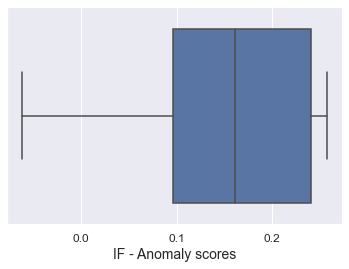

In [636]:
# View the distribution of anomaly scores the train set

sns.boxplot(X_train_IF['scores'])
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel('IF - Anomaly scores',fontsize = 14)

C:\Users\arvin\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'Anomaly scores of Outliers')

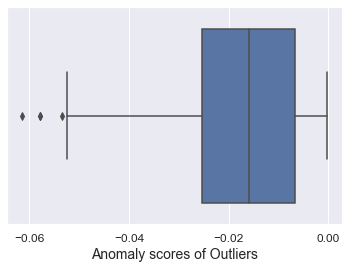

In [637]:
# View the distribution of instances labelled as anomalies

sns.boxplot(X_train_IF['scores'][(X_train_IF.anomaly_label == -1)])
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel('Anomaly scores of Outliers',fontsize = 14)

In [638]:
X_train_IF.scores.quantile(0.01) 

-0.027304251540292496

In [639]:
# View share of datapoints labelled as anomalies

X_train_IF.anomaly_label.value_counts()

 1    4330
-1     228
Name: anomaly_label, dtype: int64

In [640]:
# View share of datapoints labelled as anomalies

round(X_train_IF.anomaly_label.value_counts(normalize = True),2)

 1    0.95
-1    0.05
Name: anomaly_label, dtype: float64

In [641]:
# Check dimensions of the df

X_train_IF.shape

(4558, 13)

In [642]:
# Store index of datapoints not labelled as anomalies

keep_index = X_train_IF[(X_train_IF.anomaly_label == 1)].index

In [643]:
# Remove datapoints labelled as anomalies from X_train and y_train

X_train_IF = X_train_IF[(X_train_IF.anomaly_label == 1)]
y_train_IF = y_train[keep_index]

In [644]:
# Remove columns 'anomaly_label' and 'scores'

X_train_IF.drop(['anomaly_label','scores'],1,inplace = True)

In [645]:
# Print dimensions of the updated train set

print(X_train_IF.shape)
print(y_train_IF.shape)

(4330, 11)
(4330,)


In [646]:
# Check for data imbalance in y_train_IF

round(y_train_IF.value_counts(normalize = True),2)

0    0.8
1    0.2
Name: infected, dtype: float64

#### 3.1.1 Data Imbalance Treatment (Post IF)

In [647]:
# Instantiate SMOTE followed by assigning balanced X_train_IF and y_train_IF to new variables

oversample = SMOTE(random_state = 50)

X_train_bal_IF,y_train_bal_IF = oversample.fit_resample(X_train_IF,y_train_IF)

In [648]:
# Check X_train_IF and y_train_bal_IF dimensions

print(X_train_bal_IF.shape)
print(y_train_bal_IF.shape)

(6928, 11)
(6928,)


In [649]:
# Check y_train_bal_IF to for skewdness

round(y_train_bal_IF.value_counts(normalize = True),2)

0    0.5
1    0.5
Name: infected, dtype: float64

In [650]:
# Create copies of X_train_bal_IF and y_train_bal_IF for DT, RF, XGBoost

X_train_bal_IF_copy = X_train_bal_IF.copy()
y_train_bal_IF_copy = y_train_bal_IF.copy()

### 3.2 Extended Isolation Forest (EIF)

In [651]:
# Install necessary packages

#! pip install requests
#! pip install tabulate
#! pip install future
#! pip install "colorama >= 0.3.8"
#! pip uninstall h2o
#! pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o


# Import necessary package

import h2o
from h2o.estimators import H2OExtendedIsolationForestEstimator

In [653]:
# Initialize h2o

h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ... connected.


H2O_cluster_uptime:,1 day 15 hours 26 mins
H2O_cluster_timezone:,Asia/Kolkata
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.34.0.3
H2O_cluster_version_age:,2 months and 3 days
H2O_cluster_name:,H2O_from_python_arvin_0drbtm
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,69.3 Mb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [654]:
# h2o demo from documentation (https://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/eif.html)

# Import the prostate dataset
h2o_df = h2o.import_file("https://raw.github.com/h2oai/h2o/master/smalldata/logreg/prostate.csv")

# Set the predictors
predictors = ["AGE","RACE","DPROS","DCAPS","PSA","VOL","GLEASON"]

# Define an Extended Isolation forest model
eif = H2OExtendedIsolationForestEstimator(model_id = "eif.hex",
                                          ntrees = 100,
                                          sample_size = 256,
                                          extension_level = len(predictors) - 1)

# Train Extended Isolation Forest
eif.train(x = predictors,
          training_frame = h2o_df)

# Calculate score
eif_result = eif.predict(h2o_df)

# Number in [0, 1] explicitly defined in Equation (1) from Extended Isolation Forest paper
# or in paragraph '2 Isolation and Isolation Trees' of Isolation Forest paper
anomaly_score = eif_result["anomaly_score"]

# Average path length  of the point in Isolation Trees from root to the leaf
mean_length = eif_result["mean_length"]

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
extendedisolationforest Model Build progress: |██████████████████████████████████| (done) 100%
extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%


In [655]:
type(h2o_df)

h2o.frame.H2OFrame

In [656]:
eif_result

anomaly_score,mean_length
0.37405,14.5342
0.364249,14.9266
0.36006,15.0976
0.495088,10.3907
0.452939,11.7058
0.36817,14.7684
0.412173,13.0998
0.508206,10.0042
0.375844,14.4635
0.362396,15.002


In [657]:
list(X_train.columns)

['gender',
 'age_year',
 'fever',
 'cough',
 'runny_nose',
 'muscle_soreness',
 'pneumonia',
 'diarrhea',
 'lung_infection',
 'travel_history',
 'isolation_treatment']

In [658]:
X_train.head()

,gender,age_year,fever,cough,runny_nose,muscle_soreness,pneumonia,diarrhea,lung_infection,travel_history,isolation_treatment
5004,0,55,0,0,0,0,0,0,0,1,0
463,0,63,0,0,0,0,0,0,0,1,1
5057,1,31,1,1,1,0,1,0,0,1,0
1949,1,26,0,0,0,0,0,0,0,1,0
24,1,39,0,0,0,0,0,0,0,1,0


Requires H2o object and not dataframe which is created reading a csv file. Convert trainset to csv and read in.

In [659]:
# Convert trainset to csv for next steps

X_train.to_csv('h2o_EIF.csv')

In [660]:
# Import the trainset as h2o object

h2o_df = h2o.import_file('h2o_EIF.csv')

# Set the predictors

predictors = list(X_train.columns)

# Define an Extended Isolation forest model

eif = H2OExtendedIsolationForestEstimator(ntrees = 100,
                                          sample_size = 256,
                                          extension_level = len(predictors) - 1,
                                          seed = 50)

# Train Extended Isolation Forest
eif.train(x = predictors,
          training_frame = h2o_df)

# Calculate score
eif_result = eif.predict(h2o_df)


# Store anomaly score generated by EIF
anomaly_score = eif_result["anomaly_score"]

# Average path length  of the point in Isolation Trees from root to the leaf
mean_length = eif_result["mean_length"]

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
extendedisolationforest Model Build progress: |██████████████████████████████████| (done) 100%
extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%


In [661]:
# View results

eif_result.head()

anomaly_score,mean_length
0.410866,13.1467
0.451939,11.7385
0.451037,11.768
0.44226,12.0584
0.397503,13.6354
0.39903,13.5787
0.407068,13.284
0.425442,12.6315
0.541748,9.05952
0.658941,6.16508


In [662]:
# Convert h2o object to pandas dataframe

eif_result_df = eif_result.as_data_frame()

In [663]:
# View sample

eif_result_df.head()

,anomaly_score,mean_length
0,0.410866,13.146699
1,0.451939,11.738453
2,0.451037,11.767977
3,0.442260,12.058429
4,0.397503,13.635402


In [664]:
# Create a new dataframe 

eif_df = pd.DataFrame(index = X_train.index, data = {'anomaly_score':eif_result_df['anomaly_score'].values,
                                             'mean_length':eif_result_df['mean_length'].values})


In [665]:
eif_df.head()

,anomaly_score,mean_length
5004,0.410866,13.146699
463,0.451939,11.738453
5057,0.451037,11.767977
1949,0.442260,12.058429
24,0.397503,13.635402


In [666]:
#del X_train_EIF
#del y_train_EIF

# Merge dataframes using index to create X_train_EIF

X_train_EIF = pd.merge(X_train,eif_df, left_index = True, right_index = True)

In [667]:
X_train_EIF.head()

,gender,age_year,fever,cough,runny_nose,muscle_soreness,pneumonia,diarrhea,lung_infection,travel_history,isolation_treatment,anomaly_score,mean_length
5004,0,55,0,0,0,0,0,0,0,1,0,0.410866,13.146699
463,0,63,0,0,0,0,0,0,0,1,1,0.451939,11.738453
5057,1,31,1,1,1,0,1,0,0,1,0,0.451037,11.767977
1949,1,26,0,0,0,0,0,0,0,1,0,0.442260,12.058429
24,1,39,0,0,0,0,0,0,0,1,0,0.397503,13.635402


C:\Users\arvin\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'EIF - Anomaly scores')

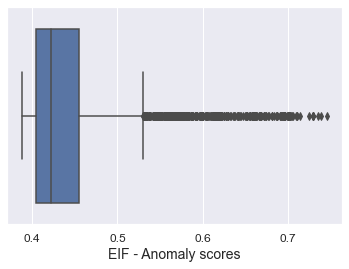

In [668]:
sns.boxplot(X_train_EIF.anomaly_score)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel('EIF - Anomaly scores',fontsize = 14)

C:\Users\arvin\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'Mean Length')

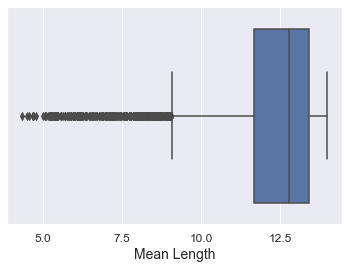

In [669]:
sns.boxplot(X_train_EIF.mean_length)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel('Mean Length',fontsize = 14)

In [670]:
# Points greater than 0.5 anomaly score

len(X_train_EIF.loc[(X_train_EIF.anomaly_score > 0.5)])/len(X_train_EIF)

0.1421676173760421

Over 14% of datapoints have anomaly score > 0.5 in trainset. Excluding that many datapoints may compromise model building effectiveness. Let's calculate the upper fence of the anomaly score boxplot. Taking a conservative approach, Datapoints with >= upper fence will be considered as anomalies since the boxplot itself depicts them as outlier scores in the spectrum.

In [671]:
# Calculate upper fence of the anomaly score boxplot

Q1 = X_train_EIF["anomaly_score"].quantile(0.25)

Q3 = X_train_EIF["anomaly_score"].quantile(0.75)

IQR = Q3 - Q1

Lower_Fence_score = Q1 - (1.5 * IQR)

Upper_Fence_score = Q3 + (1.5 * IQR)

In [672]:
Upper_Fence_score

0.5299900396075115

In [673]:
anomaly_threshold = X_train_EIF["anomaly_score"].quantile(0.95)

In [674]:
#len(X_train_EIF.loc[(X_train_EIF.anomaly_score > 0.529)])/len(X_train_EIF)

In [675]:
anomaly_threshold

0.5913060560936372

In [676]:
len(X_train_EIF.loc[(X_train_EIF.anomaly_score > anomaly_threshold)])/len(X_train_EIF)

0.050021939447125935

In [677]:
# Calculate lower fence of the mean_length boxplot

Q1 = X_train_EIF["mean_length"].quantile(0.25)

Q3 = X_train_EIF["mean_length"].quantile(0.75)

IQR = Q3 - Q1

Lower_Fence_mean_length = Q1 - (1.5 * IQR)

Upper_Fence_mean_length = Q3 + (1.5 * IQR)

In [678]:
Lower_Fence_mean_length

9.05280365172425

In [679]:
# Dimensions of X_train and y_train for comparison

print(X_train.shape)
print(y_train.shape)

(4558, 11)
(4558,)


In [680]:
# Store index of datapoints with anomaly score <= threshold

keep_index_EIF = X_train_EIF[(X_train_EIF.anomaly_score <=anomaly_threshold)].index

In [681]:
# # Removing all datapoints with anomaly score > than threshold from X_train and y_train

X_train_EIF = X_train_EIF[(X_train_EIF.anomaly_score <= anomaly_threshold)]
y_train_EIF = y_train[keep_index_EIF]

In [682]:
# Print dimensions of the updated train set

print(X_train_EIF.shape)
print(y_train_EIF.shape)

(4330, 13)
(4330,)


In [683]:
# Drop unnecessary columns 

X_train_EIF.drop(['anomaly_score','mean_length'],1, inplace = True)

In [684]:
# Print dimensions again

print(X_train_EIF.shape)
print(y_train_EIF.shape)

(4330, 11)
(4330,)


In [685]:
# Check for data imbalance in y_train_EIF

round(y_train_EIF.value_counts(normalize = True),2)

0    0.77
1    0.23
Name: infected, dtype: float64

#### 3.2.1 Data Imbalance Treatment (Post EIF)

In [686]:
# Instantiate SMOTE followed by assigning balanced X_train_EIF and y_train_EIF to new variables

oversample = SMOTE(random_state = 50)

X_train_bal_EIF,y_train_bal_EIF = oversample.fit_resample(X_train_EIF,y_train_EIF)

In [687]:
# Check X_train_EIF and y_train_bal_EIF dimensions

print(X_train_bal_EIF.shape)
print(y_train_bal_EIF.shape)

(6662, 11)
(6662,)


In [688]:
# Check y_train_bal_EIF to for skewdness

round(y_train_bal_EIF.value_counts(normalize = True),2)

0    0.5
1    0.5
Name: infected, dtype: float64

In [689]:
# Create copies of X_train_bal_EIF and y_train_bal_EIF for DT, RF, XGBoost

X_train_bal_EIF_copy = X_train_bal_EIF.copy()
y_train_bal_EIF_copy = y_train_bal_EIF.copy()

### PyOD - HBOS

In [690]:
# Install necessary packages

#! pip install pyod
#! pip install pycaret

In [691]:
# Import HBOS

from pyod.models.hbos import HBOS

In [692]:
# Create df_train by combining X_train and y_train as HBOS takes only one input

df_train = X_train.copy()
df_train['infected'] = y_train

In [693]:
# View sample

df_train.head()

,gender,age_year,fever,cough,runny_nose,muscle_soreness,pneumonia,diarrhea,lung_infection,travel_history,isolation_treatment,infected
5004,0,55,0,0,0,0,0,0,0,1,0,0
463,0,63,0,0,0,0,0,0,0,1,1,0
5057,1,31,1,1,1,0,1,0,0,1,0,1
1949,1,26,0,0,0,0,0,0,0,1,0,0
24,1,39,0,0,0,0,0,0,0,1,0,0


In [694]:
# Check dimensions of df_train

df_train.shape

(4558, 12)

When using HBOS, we calculate the number of bins as the squareroot of the total samples. Here, the number of samples is 4558 and squareoot is 67.51 so the number of bins would be = 68.

Automatic number of bins: every feature uses a number of bins deemed to be optimal according to the Birge-Rozenblac method ([BBirgeR06]).

In [695]:
# Instantiate HBOS

hbos = HBOS(n_bins = 'auto', contamination = 0.05)
#hbos = HBOS(n_bins = 68)

In [696]:
# Fit the data (note the hyperparams)

hbos.fit(df_train)

HBOS(alpha=0.1, contamination=0.05, n_bins='auto', tol=0.5)

In [697]:
# Store predictions of HBOS

hbos_pred= hbos.predict(df_train)

In [698]:
# Check percentage of anomalies predicted

round(pd.Series(hbos_pred).value_counts(normalize = True),2)

0    0.95
1    0.05
dtype: float64

In [699]:
# Store anomaly scores

output = hbos.decision_function(df_train)

C:\Users\arvin\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'HBOS - Anomaly Scores')

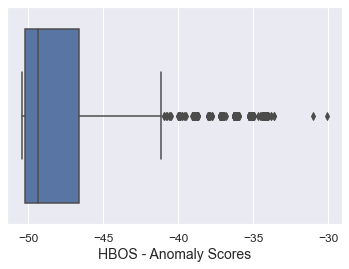

In [700]:
# Check how the scores are spread out using boxplot

sns.boxplot(output)
plt.xticks(fontsize = 12)
plt.xlabel('HBOS - Anomaly Scores',fontsize = 14)

In [701]:
print(output)

[-50.29278235 -48.24816777 -39.87730472 ... -48.68434576 -49.55744113
 -50.25070128]


In [702]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4558 entries, 5004 to 5808
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   gender               4558 non-null   int64
 1   age_year             4558 non-null   int64
 2   fever                4558 non-null   int64
 3   cough                4558 non-null   int64
 4   runny_nose           4558 non-null   int64
 5   muscle_soreness      4558 non-null   int64
 6   pneumonia            4558 non-null   int64
 7   diarrhea             4558 non-null   int64
 8   lung_infection       4558 non-null   int64
 9   travel_history       4558 non-null   int64
 10  isolation_treatment  4558 non-null   int64
 11  infected             4558 non-null   int64
dtypes: int64(12)
memory usage: 592.0 KB


In [703]:
df_train['anomaly_label'] = hbos_pred

In [704]:
df_train.head()

,gender,age_year,fever,cough,runny_nose,muscle_soreness,pneumonia,diarrhea,lung_infection,travel_history,isolation_treatment,infected,anomaly_label
5004,0,55,0,0,0,0,0,0,0,1,0,0,0
463,0,63,0,0,0,0,0,0,0,1,1,0,0
5057,1,31,1,1,1,0,1,0,0,1,0,1,0
1949,1,26,0,0,0,0,0,0,0,1,0,0,0
24,1,39,0,0,0,0,0,0,0,1,0,0,0


In [705]:
# Remove anomalies

df_train = df_train[(df_train.anomaly_label == 0)]

In [706]:
df_train.shape

(4331, 13)

In [707]:
# Split the data into X_train_HBOS and y_train_HBOS

X_train_HBOS = df_train.drop(['infected','anomaly_label'],1)
y_train_HBOS = df_train['infected']

In [708]:
# Check y_train_HBOS to for skewdness

round(y_train_HBOS.value_counts(normalize = True),2)

0    0.8
1    0.2
Name: infected, dtype: float64

In [709]:
# Instantiate SMOTE followed by assigning balanced X_train_HBOS and y_train_HBOS to new variables

oversample = SMOTE(random_state = 50)

X_train_bal_HBOS,y_train_bal_HBOS = oversample.fit_resample(X_train_HBOS,y_train_HBOS)

In [710]:
# Check X_train_bal_HBOS and y_train_bal_HBOS dimensions

print(X_train_bal_HBOS.shape)
print(y_train_bal_HBOS.shape)

(6954, 11)
(6954,)


In [711]:
# Check y_train_bal_HBOS to for skewdness

round(y_train_bal_HBOS.value_counts(normalize = True),2)

0    0.5
1    0.5
Name: infected, dtype: float64

In [712]:
# Create copies of X_train_bal_HBOS and y_train_bal_HBOS for DT, RF, XGBoost

X_train_bal_HBOS_copy = X_train_bal_HBOS.copy()
y_train_bal_HBOS_copy = y_train_bal_HBOS.copy()

## 4. Prediction Module - Post Anomaly Removal

### 4.1 Logistic Regression - Isolation Forest

**Statsmodel 1**

In [1759]:
# Build model 1 and generate model summary

statsmodels_func(X_train_bal_IF,y_train_bal_IF)

                 Generalized Linear Model Regression Results                  
Dep. Variable:               infected   No. Observations:                 6928
Model:                            GLM   Df Residuals:                     6916
Model Family:                Binomial   Df Model:                           11
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2649.7
Date:                Wed, 01 Dec 2021   Deviance:                       5299.4
Time:                        20:47:26   Pearson chi2:                 7.52e+03
No. Iterations:                    25                                         
Covariance Type:            nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.6944    

This time we have four features with high p-values. Let us look at VIF as well.

In [1760]:
# Check vif values

vif_calc(X_train_bal_IF)

               Features    VIF
6             pneumonia  18.24
4            runny_nose  18.21
2                 fever   6.99
3                 cough   6.92
1              age_year   3.70
9        travel_history   2.17
0                gender   1.75
8        lung_infection   1.68
10  isolation_treatment   1.42
5       muscle_soreness   1.01
7              diarrhea   1.00


In [1761]:
# Drop 'pneumonia'

X_train_bal_IF.drop('pneumonia',axis = 1, inplace = True)

**Statsmodel 2**

In [1762]:
# Build model 2 and generate model summary

statsmodels_func(X_train_bal_IF,y_train_bal_IF)

                 Generalized Linear Model Regression Results                  
Dep. Variable:               infected   No. Observations:                 6928
Model:                            GLM   Df Residuals:                     6917
Model Family:                Binomial   Df Model:                           10
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2714.9
Date:                Wed, 01 Dec 2021   Deviance:                       5429.8
Time:                        20:47:28   Pearson chi2:                 7.80e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.6762    

In [1763]:
# Check vif values

vif_calc(X_train_bal_IF)

              Features   VIF
2                fever  6.99
3                cough  6.92
1             age_year  3.70
8       travel_history  2.17
0               gender  1.75
7       lung_infection  1.65
4           runny_nose  1.61
9  isolation_treatment  1.41
5      muscle_soreness  1.01
6             diarrhea  1.00


In [1764]:
# Drop 'isolation_treatment'

X_train_bal_IF.drop('isolation_treatment',axis = 1, inplace = True)

**Statsmodel 3**

In [1765]:
# Build model 3 and generate model summary

statsmodels_func(X_train_bal_IF,y_train_bal_IF)

                 Generalized Linear Model Regression Results                  
Dep. Variable:               infected   No. Observations:                 6928
Model:                            GLM   Df Residuals:                     6918
Model Family:                Binomial   Df Model:                            9
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2715.1
Date:                Wed, 01 Dec 2021   Deviance:                       5430.2
Time:                        20:47:40   Pearson chi2:                 7.79e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.6745      0.128     

In [1766]:
# Check vif values

vif_calc(X_train_bal_IF)

          Features   VIF
2            fever  6.96
3            cough  6.86
1         age_year  3.70
8   travel_history  2.11
0           gender  1.75
4       runny_nose  1.58
7   lung_infection  1.54
5  muscle_soreness  1.01
6         diarrhea  1.00


In [1767]:
# Drop 'fever'

X_train_bal_IF.drop('fever',axis = 1, inplace = True)

**Statsmodel 4**

In [1768]:
# Build model 4 and generate model summary

statsmodels_func(X_train_bal_IF,y_train_bal_IF)

                 Generalized Linear Model Regression Results                  
Dep. Variable:               infected   No. Observations:                 6928
Model:                            GLM   Df Residuals:                     6919
Model Family:                Binomial   Df Model:                            8
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2721.6
Date:                Wed, 01 Dec 2021   Deviance:                       5443.1
Time:                        20:48:05   Pearson chi2:                 7.78e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.6018      0.125     

In [1769]:
# Check vif values

vif_calc(X_train_bal_IF)

          Features   VIF
1         age_year  3.64
2            cough  2.19
7   travel_history  2.08
0           gender  1.74
3       runny_nose  1.57
6   lung_infection  1.54
4  muscle_soreness  1.01
5         diarrhea  1.00


**Probability threshold**

In [1770]:
# Predict probability of infection for train set

lr4_IF = sm.GLM(y_train_bal_IF,(sm.add_constant(X_train_bal_IF)),family = sm.families.Binomial())
lr_model_IF_4 = lr4_IF.fit()
y_train_pred_IF = lr_model_IF_4.predict(sm.add_constant(X_train_bal_IF))

# View a sample of the predicted probabilities
y_train_pred_IF[:5]

0    0.122038
1    0.118324
2    0.109022
3    0.103599
4    0.102382
dtype: float64

In [1771]:
# Reshape y_train_pred into an array to add later in dataframe

y_train_pred_IF = y_train_pred_IF.values.reshape(-1)

In [1783]:
# Create dataframe

y_train_pred_df_IF = pd.DataFrame({'Infected':y_train_bal_IF.values,'Infected_Prob':y_train_pred_IF})
y_train_pred_df_IF['PatientID'] = y_train_bal_IF.index
y_train_pred_df_IF.head()

,Infected,Infected_Prob,PatientID
0,0,0.122038,0
1,0,0.118324,1
2,0,0.109022,2
3,0,0.103599,3
4,0,0.102382,4


A Logistic Regression model is fine tuned by calculating the optimal probability threshold. The threshold will be used by the model to strike a balance between different performance metrics when predicting whether the patient has been infected or not. But before this, we will look at the ROC curve.

**ROC Curve**

We will now draw up the ROC cuve to understand the model's effectiveness in classification. An ROC curve is useful to understand the following:-

* It shows the tradeoff between the performance metrics, sensitivity and specificity (any increase in sensitivity will be accompanied by a decrease in specificity).
* The closer the curve follows the left-hand border and then the top border of the ROC space, the more accurate the test. A good model will tend to hug the Y Axis (True Positive Rate).
* The closer the curve comes to the 45-degree diagonal of the ROC space, the less accurate the test.  A less than good model tends to be closed to the X Axis (False Positive Rate or 1 - True Negative Rate (Specificity).

In [1773]:
# Assign values to the axes in the ROC curve

fpr, tpr, thresholds = metrics.roc_curve(y_train_pred_df_IF.Infected, y_train_pred_df_IF.Infected_Prob, drop_intermediate = False )

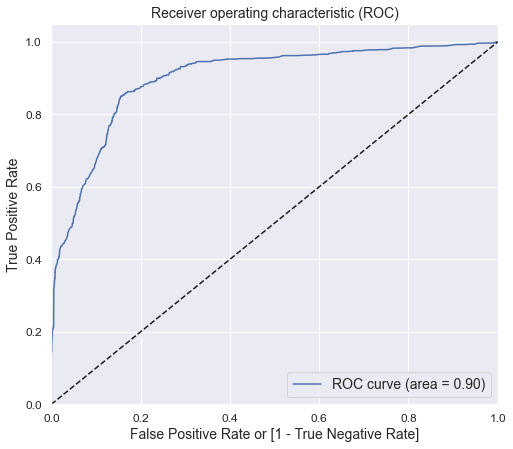

In [1774]:
# Generate the ROC curve

draw_roc(y_train_pred_df_IF.Infected, y_train_pred_df_IF.Infected_Prob)

In [1784]:
# Add different possible thresholds to our dataframe

num = [float (i/10) for i in range(10)]
for i in num:
    y_train_pred_df_IF[i] = y_train_pred_df_IF.Infected_Prob.map(lambda x: 1 if x > i else 0)

In [1785]:
# Print dataframe
y_train_pred_df_IF.head()

,Infected,Infected_Prob,PatientID,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0,0.122038,0,1,1,0,0,0,0,0,0,0,0
1,0,0.118324,1,1,1,0,0,0,0,0,0,0,0
2,0,0.109022,2,1,1,0,0,0,0,0,0,0,0
3,0,0.103599,3,1,1,0,0,0,0,0,0,0,0
4,0,0.102382,4,1,1,0,0,0,0,0,0,0,0


In order to find the optimal threshold/cutoff point, we will need to calculate all the important metrics for these different thresholds - Sensitivity, Specificity & Accuracy - plot them and find the intersection where all of these metrics are balanced out in the model.

In [1786]:
# Create a dataframe to store metrics for different thresholds

df_threshold = pd.DataFrame(columns = ['prob','accuracy','sensitivity','specificity'])

for i in num:
    cm = metrics.confusion_matrix(y_train_pred_df_IF.Infected,y_train_pred_df_IF[i])
    accuracy = metrics.accuracy_score(y_train_pred_df_IF.Infected,y_train_pred_df_IF[i])
    sensitivity = cm[1,1]/(cm[1,1]+cm[1,0])
    specificity = cm[0,0]/(cm[0,0]+cm[0,1])
    df_threshold.loc[i] = [i,accuracy,sensitivity,specificity]

    
df_threshold

,prob,accuracy,sensitivity,specificity
0.0,0.0,0.500000,1.000000,0.000000
0.1,0.1,0.554273,0.989319,0.119226
0.2,0.2,0.815820,0.937067,0.694573
0.3,0.3,0.836028,0.883083,0.788972
0.4,0.4,0.845987,0.852194,0.839781
0.5,0.5,0.846132,0.852194,0.840069
0.6,0.6,0.827079,0.792725,0.861432
0.7,0.7,0.795901,0.710739,0.881062
0.8,0.8,0.776992,0.648383,0.905600
0.9,0.9,0.670468,0.349307,0.991628


We will now plot the different values of each of the metrics to find the intersection where all them are balanced for our model.

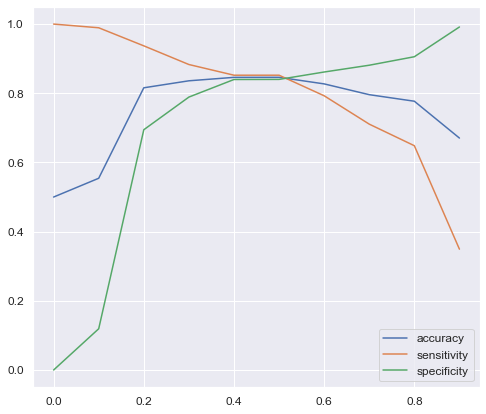

In [1787]:
# Plot line graphs

df_threshold[['accuracy','sensitivity','specificity']].plot(figsize = (8,7))
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.legend(fontsize = 12)

The optimal threshold seems to lie somewhere between 0.5 and 0.6. Let us calculate the metrics for this range of values as well.

In [1788]:
# Update the dataframe to store metrics for the new thresholds

#new_num = [0.51,0.52,0.53,0.54,0.541,0.542,0.543,0.544,0.545,0.56,0.57,0.58,0.59]
new_num = [0.51,0.52,0.53,0.54,0.5,0.551,0.552,0.553,0.554,0.555,0.556,0.557,0.558,0.559,0.56,0.57,0.58,0.59]

for i in new_num:
    y_train_pred_df_IF[i] = y_train_pred_df_IF.Infected_Prob.map(lambda x: 1 if x > i else 0)

y_train_pred_df_IF.head()

,Infected,Infected_Prob,PatientID,0.0,0.1,0.2,0.3,0.4,0.5,0.6,...,0.554,0.555,0.556,0.557,0.558,0.559,0.56,0.57,0.58,0.59
0,0,0.122038,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0.118324,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0.109022,2,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0.103599,3,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0.102382,4,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [1789]:
# Update df_threshold

for i in new_num:
    cm = metrics.confusion_matrix(y_train_pred_df_IF.Infected,y_train_pred_df_IF[i])
    accuracy = metrics.accuracy_score(y_train_pred_df_IF.Infected,y_train_pred_df_IF[i])
    sensitivity = cm[1,1]/(cm[1,1]+cm[1,0])
    specificity = cm[0,0]/(cm[0,0]+cm[0,1])
    df_threshold.loc[i] = [i,accuracy,sensitivity,specificity]

# sort the thresholds in ascending order for plotting

df_threshold.sort_values(by = 'prob', ascending = True, inplace = True)

df_threshold

,prob,accuracy,sensitivity,specificity
0.000,0.000,0.500000,1.000000,0.000000
0.100,0.100,0.554273,0.989319,0.119226
0.200,0.200,0.815820,0.937067,0.694573
0.300,0.300,0.836028,0.883083,0.788972
0.400,0.400,0.845987,0.852194,0.839781
0.500,0.500,0.846132,0.852194,0.840069
0.510,0.510,0.846132,0.852194,0.840069
0.520,0.520,0.846132,0.852194,0.840069
0.530,0.530,0.846132,0.851905,0.840358
0.540,0.540,0.846565,0.851905,0.841224


Let us fine tune the X-axis values in order to visualize the optimal threshold better.

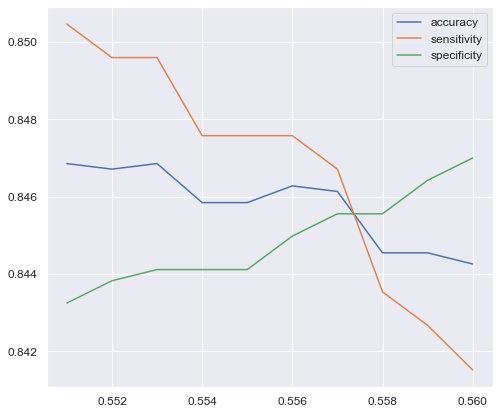

In [1792]:
# Plot the graph only for probabilities between 0.54 and 0.545

df_threshold.loc[(df_threshold.prob >= 0.55) & (df_threshold.prob <= 0.56),['accuracy','sensitivity','specificity']].plot(figsize = (8,7))
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.legend(fontsize = 12)

The probability threshold value lies between 0.54 and 0.541. We will take the middle value of **0.5575** as getting anymore granular does not improve the performance metrics significantly.

In [1793]:
# Map the final predictions into our table based on the calculated probability threshold

y_train_pred_df_IF['prediction'] = y_train_pred_df_IF['Infected_Prob'].map(lambda x: 1 if x > 0.5575 else 0)

In [1794]:
# View a sample

y_train_pred_df_IF.head()

,Infected,Infected_Prob,PatientID,0.0,0.1,0.2,0.3,0.4,0.5,0.6,...,0.555,0.556,0.557,0.558,0.559,0.56,0.57,0.58,0.59,prediction
0,0,0.122038,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0.118324,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0.109022,2,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0.103599,3,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0.102382,4,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [1795]:
# Keep only necessary columns for better readability

y_train_pred_df_IF = y_train_pred_df_IF[['Infected','Infected_Prob','PatientID','prediction']]

In [1796]:
# View sample

y_train_pred_df_IF.head()

,Infected,Infected_Prob,PatientID,prediction
0,0,0.122038,0,0
1,0,0.118324,1,0
2,0,0.109022,2,0
3,0,0.103599,3,0
4,0,0.102382,4,0


Let us evaluate the performance of the model based on the four performance metrics of our choice - Accuracy, Precision, Recall, F1 Score.

In [1797]:
# Calculate accuracy

accuracy_train_LR_IF = metrics.accuracy_score(y_train_pred_df_IF.Infected,y_train_pred_df_IF.prediction)
accuracy_train_LR_IF

0.8461316397228638

We will create a confusion matrix to aid in calculating Precision and Recall.

In [1798]:
# Create confusion matrix and print it

confusion_train_LR_IF = metrics.confusion_matrix(y_train_pred_df_IF.Infected,y_train_pred_df_IF.prediction)
confusion_train_LR_IF

array([[2929,  535],
       [ 531, 2933]], dtype=int64)

In [1799]:
# Calculate Precision (TP /TP + FP)

precision_train_LR_IF = confusion_train_LR_IF[1,1]/(confusion_train_LR_IF[1,1] + confusion_train_LR_IF[0,1])
precision_train_LR_IF

0.8457324106113033

In [1800]:
# Calculate Recall (TP /TP + FN)

recall_train_LR_IF = confusion_train_LR_IF[1,1]/(confusion_train_LR_IF[1,1] + confusion_train_LR_IF[1,0])
recall_train_LR_IF

0.8467090069284064

In [1801]:
# Calculate F1 Score

f1_score_train_LR_IF = 2 * (recall_train_LR_IF * precision_train_LR_IF)/(recall_train_LR_IF + precision_train_LR_IF)
f1_score_train_LR_IF

0.8462204270051933

**Test Set Performance**

In [1802]:
# Set same columns for X_test

X_test_bal_IF = X_test[X_train_bal_IF.columns]

In [1803]:
# Predict probability of infection for test set

y_test_pred_IF = lr_model_IF_4.predict(sm.add_constant(X_test_bal_IF))

# View a sample of the predicted probabilities
y_test_pred_IF[:5]

1696    0.125853
880     0.094588
4555    0.104829
4121    0.124890
829     0.122038
dtype: float64

In [1804]:
# Create dataframe

y_test_pred_df_IF = pd.DataFrame({'Infected':y_test.values,'Infected_Prob':y_test_pred_IF})
y_test_pred_df_IF['PatientID'] = y_test.index
y_test_pred_df_IF.head()

,Infected,Infected_Prob,PatientID
1696,0,0.125853,1696
880,0,0.094588,880
4555,0,0.104829,4555
4121,0,0.124890,4121
829,0,0.122038,829


In [1805]:
# Add test prediction to dataframe

y_test_pred_df_IF['test_prediction'] = y_test_pred_df_IF.Infected_Prob.map(lambda x: 1 if x > 0.5575 else 0)

In [1806]:
y_test_pred_df_IF.head()

,Infected,Infected_Prob,PatientID,test_prediction
1696,0,0.125853,1696,0
880,0,0.094588,880,0
4555,0,0.104829,4555,0
4121,0,0.124890,4121,0
829,0,0.122038,829,0


In [1807]:
# Calculate test accuracy

accuracy_test_LR_IF = metrics.accuracy_score(y_test_pred_df_IF.Infected,y_test_pred_df_IF.test_prediction)
accuracy_test_LR_IF

0.8582395087001023

We will create a confusion matrix to aid in calculating Precision and Recall.

In [1808]:
# Create confusion matrix

confusion_test_LR_IF = metrics.confusion_matrix(y_test_pred_df_IF.Infected,y_test_pred_df_IF.test_prediction)
confusion_test_LR_IF

array([[1240,  222],
       [  55,  437]], dtype=int64)

In [1809]:
# Calculate Precision (TP /TP + FP)

precision_test_LR_IF = confusion_test_LR_IF[1,1]/(confusion_test_LR_IF[1,1] + confusion_test_LR_IF[0,1])
precision_test_LR_IF

0.6631259484066768

In [1810]:
# Calculate Recall (TP /TP + FN)

recall_test_LR_IF = confusion_test_LR_IF[1,1]/(confusion_test_LR_IF[1,1] + confusion_test_LR_IF[1,0])
recall_test_LR_IF

0.8882113821138211

In [1811]:
# Calculate F1 Score

f1_score_test_LR_IF = 2 * (recall_test_LR_IF * precision_test_LR_IF)/(recall_test_LR_IF + precision_test_LR_IF)
f1_score_test_LR_IF

0.7593397046046917

### 4.2 Logistic Regression - Extended Isolation Forest

**Statsmodel 1**

In [2002]:
# Build model 1 and generate model summary

statsmodels_func(X_train_bal_EIF,y_train_bal_EIF)

                 Generalized Linear Model Regression Results                  
Dep. Variable:               infected   No. Observations:                 6662
Model:                            GLM   Df Residuals:                     6650
Model Family:                Binomial   Df Model:                           11
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2235.8
Date:                Mon, 06 Dec 2021   Deviance:                       4471.5
Time:                        00:18:48   Pearson chi2:                 7.38e+03
No. Iterations:                    26                                         
Covariance Type:            nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -1.1959    

This time we have four features with high p-values. Let us look at VIF as well.

In [2003]:
# Check vif values

vif_calc(X_train_bal_EIF)

               Features    VIF
4            runny_nose  19.53
6             pneumonia  19.32
2                 fever   7.10
3                 cough   7.09
1              age_year   4.03
9        travel_history   2.10
8        lung_infection   1.95
0                gender   1.78
10  isolation_treatment   1.49
5       muscle_soreness   1.01
7              diarrhea   1.01


In [2004]:
# Drop 'pneumonia'

X_train_bal_EIF.drop('pneumonia',axis = 1, inplace = True)

**Statsmodel 2**

In [2005]:
# Build model 2 and generate model summary

statsmodels_func(X_train_bal_EIF,y_train_bal_EIF)

                 Generalized Linear Model Regression Results                  
Dep. Variable:               infected   No. Observations:                 6662
Model:                            GLM   Df Residuals:                     6651
Model Family:                Binomial   Df Model:                           10
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2310.1
Date:                Mon, 06 Dec 2021   Deviance:                       4620.1
Time:                        00:19:18   Pearson chi2:                 8.36e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -1.2306    

In [2006]:
# Check vif values

vif_calc(X_train_bal_EIF)

              Features   VIF
2                fever  7.10
3                cough  7.09
1             age_year  4.02
8       travel_history  2.09
4           runny_nose  1.94
7       lung_infection  1.92
0               gender  1.78
9  isolation_treatment  1.48
5      muscle_soreness  1.01
6             diarrhea  1.01


In [2007]:
# Drop 'isolation_treatment'

X_train_bal_EIF.drop('isolation_treatment',axis = 1, inplace = True)

**Statsmodel 3**

In [2008]:
# Build model 3 and generate model summary

statsmodels_func(X_train_bal_EIF,y_train_bal_EIF)

                 Generalized Linear Model Regression Results                  
Dep. Variable:               infected   No. Observations:                 6662
Model:                            GLM   Df Residuals:                     6652
Model Family:                Binomial   Df Model:                            9
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2310.1
Date:                Mon, 06 Dec 2021   Deviance:                       4620.1
Time:                        00:19:58   Pearson chi2:                 8.35e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -1.2301      0.154     

In [2009]:
# Check vif values

vif_calc(X_train_bal_EIF)

          Features   VIF
2            fever  7.06
3            cough  7.06
1         age_year  4.01
8   travel_history  2.07
4       runny_nose  1.92
0           gender  1.78
7   lung_infection  1.77
5  muscle_soreness  1.01
6         diarrhea  1.01


In [2010]:
# Drop 'age_year'

X_train_bal_EIF.drop('age_year',axis = 1, inplace = True)

**Statsmodel 4**

In [2012]:
# Build model 4 and generate model summary

statsmodels_func(X_train_bal_EIF,y_train_bal_EIF)

                 Generalized Linear Model Regression Results                  
Dep. Variable:               infected   No. Observations:                 6662
Model:                            GLM   Df Residuals:                     6653
Model Family:                Binomial   Df Model:                            8
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2310.4
Date:                Mon, 06 Dec 2021   Deviance:                       4620.7
Time:                        00:20:46   Pearson chi2:                 8.34e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -1.3295      0.087    -

In [2013]:
# Check vif values

vif_calc(X_train_bal_EIF)

          Features   VIF
1            fever  6.90
2            cough  6.84
3       runny_nose  1.87
0           gender  1.61
6   lung_infection  1.58
7   travel_history  1.43
4  muscle_soreness  1.01
5         diarrhea  1.00


In [2014]:
# Drop 'fever'

X_train_bal_EIF.drop('fever',axis = 1, inplace = True)

**Statsmodel 5**

In [2015]:
# Build model 5 and generate model summary

statsmodels_func(X_train_bal_EIF,y_train_bal_EIF)

                 Generalized Linear Model Regression Results                  
Dep. Variable:               infected   No. Observations:                 6662
Model:                            GLM   Df Residuals:                     6654
Model Family:                Binomial   Df Model:                            7
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2322.5
Date:                Mon, 06 Dec 2021   Deviance:                       4644.9
Time:                        00:21:41   Pearson chi2:                 8.43e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -1.2204      0.083    -

In [2017]:
# Check vif values

vif_calc(X_train_bal_EIF)

          Features   VIF
2       runny_nose  1.87
1            cough  1.84
0           gender  1.59
5   lung_infection  1.58
6   travel_history  1.35
3  muscle_soreness  1.01
4         diarrhea  1.00


**Probability threshold**

In [2018]:
# Predict probability of infection for train set

lr5_EIF = sm.GLM(y_train_bal_EIF,(sm.add_constant(X_train_bal_EIF)),family = sm.families.Binomial())
lr_model_EIF_5 = lr5_EIF.fit()
y_train_pred_EIF = lr_model_EIF_5.predict(sm.add_constant(X_train_bal_EIF))

# View a sample of the predicted probabilities
y_train_pred_EIF[:5]

0    0.100390
1    0.100390
2    0.826868
3    0.083764
4    0.083764
dtype: float64

In [2019]:
# Reshape y_train_pred_EIF into an array to add later in dataframe

y_train_pred_EIF = y_train_pred_EIF.values.reshape(-1)

In [2031]:
# Create dataframe

y_train_pred_df_EIF = pd.DataFrame({'Infected':y_train_bal_EIF.values,'Infected_Prob':y_train_pred_EIF})
y_train_pred_df_EIF['PatientID'] = y_train_bal_EIF.index
y_train_pred_df_EIF.head()

,Infected,Infected_Prob,PatientID
0,0,0.100390,0
1,0,0.100390,1
2,1,0.826868,2
3,0,0.083764,3
4,0,0.083764,4


**ROC Curve**

We will now draw up the ROC cuve to understand the model's effectiveness in classification. An ROC curve is useful to understand the following:-

* It shows the tradeoff between the performance metrics, sensitivity and specificity (any increase in sensitivity will be accompanied by a decrease in specificity).
* The closer the curve follows the left-hand border and then the top border of the ROC space, the more accurate the test. A good model will tend to hug the Y Axis (True Positive Rate).
* The closer the curve comes to the 45-degree diagonal of the ROC space, the less accurate the test.  A less than good model tends to be closed to the X Axis (False Positive Rate or 1 - True Negative Rate (Specificity).

In [2021]:
# Assign values to the axes in the ROC curve

fpr, tpr, thresholds = metrics.roc_curve(y_train_pred_df_EIF.Infected, y_train_pred_df_EIF.Infected_Prob, drop_intermediate = False )

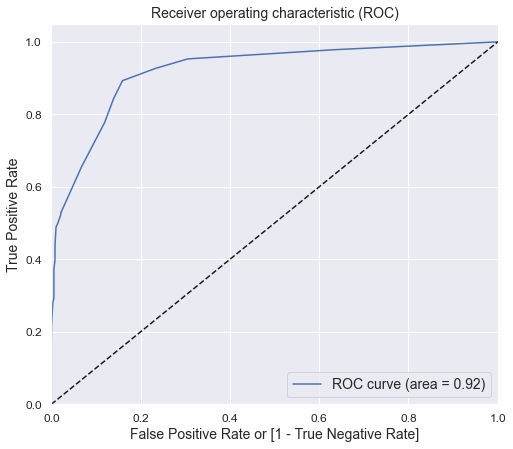

In [2022]:
# Generate the ROC curve

draw_roc(y_train_pred_df_EIF.Infected, y_train_pred_df_EIF.Infected_Prob)

In [2032]:
# Add different possible thresholds to our dataframe

num = [float (i/10) for i in range(10)]
for i in num:
    y_train_pred_df_EIF[i] = y_train_pred_df_EIF.Infected_Prob.map(lambda x: 1 if x > i else 0)

In [2033]:
# Print dataframe
y_train_pred_df_EIF.head()

,Infected,Infected_Prob,PatientID,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0,0.100390,0,1,1,0,0,0,0,0,0,0,0
1,0,0.100390,1,1,1,0,0,0,0,0,0,0,0
2,1,0.826868,2,1,1,1,1,1,1,1,1,1,0
3,0,0.083764,3,1,0,0,0,0,0,0,0,0,0
4,0,0.083764,4,1,0,0,0,0,0,0,0,0,0


In order to find the optimal threshold/cutoff point, we will need to calculate all the important metrics for these different thresholds - Sensitivity, Specificity & Accuracy - plot them and find the intersection where all of these metrics are balanced out in the model.

In [2034]:
# Create a dataframe to store metrics for different thresholds

df_threshold = pd.DataFrame(columns = ['prob','accuracy','sensitivity','specificity'])

for i in num:
    cm = metrics.confusion_matrix(y_train_pred_df_EIF.Infected,y_train_pred_df_EIF[i])
    accuracy = metrics.accuracy_score(y_train_pred_df_EIF.Infected,y_train_pred_df_EIF[i])
    sensitivity = cm[1,1]/(cm[1,1]+cm[1,0])
    specificity = cm[0,0]/(cm[0,0]+cm[0,1])
    df_threshold.loc[i] = [i,accuracy,sensitivity,specificity]

    
df_threshold

,prob,accuracy,sensitivity,specificity
0.0,0.0,0.500000,1.000000,0.000000
0.1,0.1,0.672771,0.978385,0.367157
0.2,0.2,0.846292,0.927349,0.765236
0.3,0.3,0.866557,0.893726,0.839388
0.4,0.4,0.866857,0.893726,0.839988
0.5,0.5,0.867007,0.893726,0.840288
0.6,0.6,0.829180,0.777844,0.880516
0.7,0.7,0.829030,0.777544,0.880516
0.8,0.8,0.753978,0.529871,0.978085
0.9,0.9,0.738367,0.487241,0.989493


We will now plot the different values of each of the metrics to find the intersection where all them are balanced for our model.

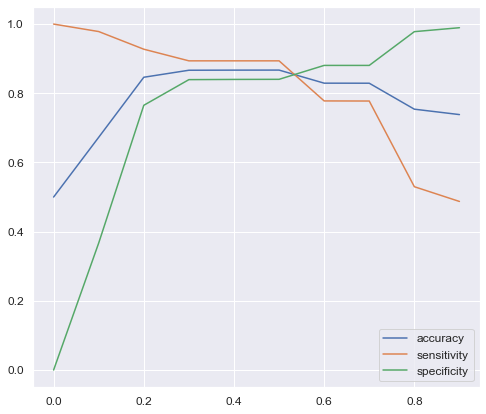

In [2035]:
# Plot line graphs

df_threshold[['accuracy','sensitivity','specificity']].plot(figsize = (8,7))
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.legend(fontsize = 12)

The optimal threshold seems to lie somewhere between 0.5 and 0.6. Let us calculate the metrics for this range of values as well.

In [2036]:
# Update the dataframe to store metrics for the new thresholds

new_num = [0.51,0.52,0.53,0.54,0.55,0.551,0.552,0.553,0.554,0.555,0.556,0.557,0.558,0.559,0.56,0.57,0.58]

for i in new_num:
    y_train_pred_df_EIF[i] = y_train_pred_df_EIF.Infected_Prob.map(lambda x: 1 if x > i else 0)

y_train_pred_df_EIF.head()

,Infected,Infected_Prob,PatientID,0.0,0.1,0.2,0.3,0.4,0.5,0.6,...,0.553,0.554,0.555,0.556,0.557,0.558,0.559,0.56,0.57,0.58
0,0,0.100390,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0.100390,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0.826868,2,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,0,0.083764,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0.083764,4,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [2037]:
# Update df_threshold

for i in new_num:
    cm = metrics.confusion_matrix(y_train_pred_df_EIF.Infected,y_train_pred_df_EIF[i])
    accuracy = metrics.accuracy_score(y_train_pred_df_EIF.Infected,y_train_pred_df_EIF[i])
    sensitivity = cm[1,1]/(cm[1,1]+cm[1,0])
    specificity = cm[0,0]/(cm[0,0]+cm[0,1])
    df_threshold.loc[i] = [i,accuracy,sensitivity,specificity]

# sort the thresholds in ascending order for plotting

df_threshold.sort_values(by = 'prob', ascending = True, inplace = True)

df_threshold

,prob,accuracy,sensitivity,specificity
0.000,0.000,0.500000,1.000000,0.000000
0.100,0.100,0.672771,0.978385,0.367157
0.200,0.200,0.846292,0.927349,0.765236
0.300,0.300,0.866557,0.893726,0.839388
0.400,0.400,0.866857,0.893726,0.839988
0.500,0.500,0.867007,0.893726,0.840288
0.510,0.510,0.867007,0.893726,0.840288
0.520,0.520,0.867007,0.893726,0.840288
0.530,0.530,0.867007,0.893726,0.840288
0.540,0.540,0.867007,0.893726,0.840288


Let us fine tune the X-axis values in order to visualize the optimal threshold better.

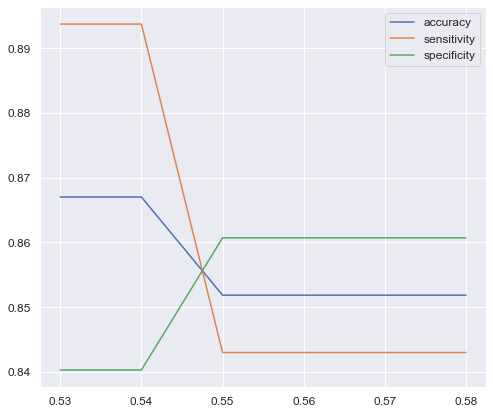

In [2040]:
# Plot the graph only for probabilities between 0.58 and 0.59

df_threshold.loc[(df_threshold.prob >0.52) & (df_threshold.prob <= 0.587),['accuracy','sensitivity','specificity']].plot(figsize = (8,7))
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.legend(fontsize = 12)

The probability threshold value lies between 0.545 and 0.55. We will take the middle value of **0.5475** as getting anymore granular does not improve the performance metrics significantly.

In [2041]:
# Map the final predictions into our table based on the calculated probability threshold

y_train_pred_df_EIF['prediction'] = y_train_pred_df_EIF['Infected_Prob'].map(lambda x: 1 if x > 0.5475 else 0)

In [2042]:
# View a sample

y_train_pred_df_EIF.head()

,Infected,Infected_Prob,PatientID,0.0,0.1,0.2,0.3,0.4,0.5,0.6,...,0.554,0.555,0.556,0.557,0.558,0.559,0.56,0.57,0.58,prediction
0,0,0.100390,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0.100390,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0.826868,2,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,0,0.083764,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0.083764,4,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [2043]:
# Keep only necessary columns for better readability

y_train_pred_df_EIF = y_train_pred_df_EIF[['Infected','Infected_Prob','PatientID','prediction']]

In [2044]:
# View sample

y_train_pred_df_EIF.head()

,Infected,Infected_Prob,PatientID,prediction
0,0,0.100390,0,0
1,0,0.100390,1,0
2,1,0.826868,2,1
3,0,0.083764,3,0
4,0,0.083764,4,0


Let us evaluate the performance of the model based on the four performance metrics of our choice - Accuracy, Precision, Recall, F1 Score.

In [2045]:
# Calculate accuracy

accuracy_train_LR_EIF = metrics.accuracy_score(y_train_pred_df_EIF.Infected,y_train_pred_df_EIF.prediction)
accuracy_train_LR_EIF

0.8670069048333834

We will create a confusion matrix to aid in calculating Precision and Recall.

In [2046]:
# Create confusion matrix and print it

confusion_train_LR_EIF = metrics.confusion_matrix(y_train_pred_df_EIF.Infected,y_train_pred_df_EIF.prediction)
confusion_train_LR_EIF

array([[2799,  532],
       [ 354, 2977]], dtype=int64)

In [2047]:
# Calculate Precision (TP /TP + FP)

precision_train_LR_EIF = confusion_train_LR_EIF[1,1]/(confusion_train_LR_EIF[1,1] + confusion_train_LR_EIF[0,1])
precision_train_LR_EIF

0.8483898546594472

In [2048]:
# Calculate Recall (TP /TP + FN)

recall_train_LR_EIF = confusion_train_LR_EIF[1,1]/(confusion_train_LR_EIF[1,1] + confusion_train_LR_EIF[1,0])
recall_train_LR_EIF

0.8937256079255479

In [2049]:
# Calculate F1 Score

f1_score_train_LR_EIF = 2 * (recall_train_LR_EIF * precision_train_LR_EIF)/(recall_train_LR_EIF + precision_train_LR_EIF)
f1_score_train_LR_EIF

0.87046783625731

**Test Set Performance**

In [2057]:
# Set same columns for X_test

X_test_bal_EIF = X_test[X_train_bal_EIF.columns]

In [2058]:
# Predict probability of infection for test set

y_test_pred_EIF = lr_model_EIF_5.predict(sm.add_constant(X_test_bal_EIF))

# View a sample of the predicted probabilities
y_test_pred_EIF[:5]

1696    0.100390
880     0.083764
4555    0.083764
4121    0.100390
829     0.100390
dtype: float64

In [2059]:
# Create dataframe

y_test_pred_df_EIF = pd.DataFrame({'Infected':y_test.values,'Infected_Prob':y_test_pred_EIF})
y_test_pred_df_EIF['PatientID'] = y_test.index
y_test_pred_df_EIF.head()

,Infected,Infected_Prob,PatientID
1696,0,0.100390,1696
880,0,0.083764,880
4555,0,0.083764,4555
4121,0,0.100390,4121
829,0,0.100390,829


In [2060]:
# Add test prediction to dataframe

y_test_pred_df_EIF['test_prediction'] = y_test_pred_df_EIF.Infected_Prob.map(lambda x: 1 if x > 0.5475 else 0)

In [2061]:
y_test_pred_df_EIF.head()

,Infected,Infected_Prob,PatientID,test_prediction
1696,0,0.100390,1696,0
880,0,0.083764,880,0
4555,0,0.083764,4555,0
4121,0,0.100390,4121,0
829,0,0.100390,829,0


In [2062]:
# Calculate test accuracy

accuracy_test_LR_EIF = metrics.accuracy_score(y_test_pred_df_EIF.Infected,y_test_pred_df_EIF.test_prediction)
accuracy_test_LR_EIF

0.8536335721596725

We will create a confusion matrix to aid in calculating Precision and Recall.

In [2063]:
# Create confusion matrix

confusion_test_LR_EIF = metrics.confusion_matrix(y_test_pred_df_EIF.Infected,y_test_pred_df_EIF.test_prediction)
confusion_test_LR_EIF

array([[1227,  235],
       [  51,  441]], dtype=int64)

In [2064]:
# Calculate Precision (TP /TP + FP)

precision_test_LR_EIF = confusion_test_LR_EIF[1,1]/(confusion_test_LR_EIF[1,1] + confusion_test_LR_EIF[0,1])
precision_test_LR_EIF

0.6523668639053254

In [2065]:
# Calculate Recall (TP /TP + FN)

recall_test_LR_EIF = confusion_test_LR_EIF[1,1]/(confusion_test_LR_EIF[1,1] + confusion_test_LR_EIF[1,0])
recall_test_LR_EIF

0.8963414634146342

In [2066]:
# Calculate F1 Score

f1_score_test_LR_EIF = 2 * (recall_test_LR_EIF * precision_test_LR_EIF)/(recall_test_LR_EIF + precision_test_LR_EIF)
f1_score_test_LR_EIF

0.7551369863013699

### 4.1 Logistic Regression - HBOS

**Statsmodel 1**

In [149]:
# Build model 1 and generate model summary

statsmodels_func(X_train_bal_HBOS,y_train_bal_HBOS)

                 Generalized Linear Model Regression Results                  
Dep. Variable:               infected   No. Observations:                 6954
Model:                            GLM   Df Residuals:                     6942
Model Family:                Binomial   Df Model:                           11
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2744.6
Date:                Thu, 09 Dec 2021   Deviance:                       5489.1
Time:                        13:35:01   Pearson chi2:                 8.64e+03
No. Iterations:                    25                                         
Covariance Type:            nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.4935    

In [1760]:
# Check vif values

vif_calc(X_train_bal_HBOS)

               Features    VIF
6             pneumonia  18.24
4            runny_nose  18.21
2                 fever   6.99
3                 cough   6.92
1              age_year   3.70
9        travel_history   2.17
0                gender   1.75
8        lung_infection   1.68
10  isolation_treatment   1.42
5       muscle_soreness   1.01
7              diarrhea   1.00


In [153]:
# Drop 'pneumonia'

X_train_bal_HBOS.drop('pneumonia',axis = 1, inplace = True)

**Statsmodel 2**

In [156]:
# Build model 2 and generate model summary

statsmodels_func(X_train_bal_HBOS,y_train_bal_HBOS)

                 Generalized Linear Model Regression Results                  
Dep. Variable:               infected   No. Observations:                 6954
Model:                            GLM   Df Residuals:                     6943
Model Family:                Binomial   Df Model:                           10
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2809.9
Date:                Thu, 09 Dec 2021   Deviance:                       5619.8
Time:                        13:39:14   Pearson chi2:                 9.27e+03
No. Iterations:                    20                                         
Covariance Type:            nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.5113    

In [157]:
# Check vif values

vif_calc(X_train_bal_HBOS)

              Features   VIF
2                fever  6.12
3                cough  5.84
1             age_year  3.46
8       travel_history  1.98
0               gender  1.75
9  isolation_treatment  1.41
7       lung_infection  1.32
4           runny_nose  1.20
6             diarrhea  1.01
5      muscle_soreness  1.00


In [160]:
# Drop 'muscle_soreness'

X_train_bal_HBOS.drop('muscle_soreness',axis = 1, inplace = True)

**Statsmodel 3**

In [161]:
# Build model 3 and generate model summary

statsmodels_func(X_train_bal_HBOS,y_train_bal_HBOS)

                 Generalized Linear Model Regression Results                  
Dep. Variable:               infected   No. Observations:                 6954
Model:                            GLM   Df Residuals:                     6944
Model Family:                Binomial   Df Model:                            9
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2816.3
Date:                Thu, 09 Dec 2021   Deviance:                       5632.6
Time:                        13:41:10   Pearson chi2:                 9.24e+03
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.5141    

In [162]:
# Check vif values

vif_calc(X_train_bal_HBOS)

              Features   VIF
2                fever  6.12
3                cough  5.83
1             age_year  3.45
7       travel_history  1.98
0               gender  1.75
8  isolation_treatment  1.41
6       lung_infection  1.32
4           runny_nose  1.20
5             diarrhea  1.01


In [163]:
# Drop 'isolation_treatment'

X_train_bal_HBOS.drop('isolation_treatment',axis = 1, inplace = True)

**Statsmodel 4**

In [164]:
# Build model 4 and generate model summary

statsmodels_func(X_train_bal_HBOS,y_train_bal_HBOS)

                 Generalized Linear Model Regression Results                  
Dep. Variable:               infected   No. Observations:                 6954
Model:                            GLM   Df Residuals:                     6945
Model Family:                Binomial   Df Model:                            8
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2816.5
Date:                Thu, 09 Dec 2021   Deviance:                       5633.0
Time:                        13:42:07   Pearson chi2:                 9.22e+03
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.5144      0.121     -4.

In [165]:
# Check vif values

vif_calc(X_train_bal_HBOS)

         Features   VIF
2           fever  6.10
3           cough  5.81
1        age_year  3.43
7  travel_history  1.95
0          gender  1.75
6  lung_infection  1.22
4      runny_nose  1.18
5        diarrhea  1.01


In [166]:
# Drop 'fever'

X_train_bal_HBOS.drop('fever',axis = 1, inplace = True)

**Statsmodel 5**

In [167]:
# Build model 5 and generate model summary

statsmodels_func(X_train_bal_HBOS,y_train_bal_HBOS)

                 Generalized Linear Model Regression Results                  
Dep. Variable:               infected   No. Observations:                 6954
Model:                            GLM   Df Residuals:                     6946
Model Family:                Binomial   Df Model:                            7
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2829.8
Date:                Thu, 09 Dec 2021   Deviance:                       5659.6
Time:                        13:43:33   Pearson chi2:                 9.34e+03
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.4101      0.118     -3.

In [168]:
# Check vif values

vif_calc(X_train_bal_HBOS)

         Features   VIF
1        age_year  3.37
6  travel_history  1.92
2           cough  1.91
0          gender  1.74
5  lung_infection  1.22
3      runny_nose  1.18
4        diarrhea  1.01


**Probability threshold**

In [182]:
# Predict probability of infection for train set

lr5_HBOS = sm.GLM(y_train_bal_HBOS,(sm.add_constant(X_train_bal_HBOS)),family = sm.families.Binomial())
lr_model_HBOS_5 = lr5_HBOS.fit()
y_train_pred_HBOS = lr_model_HBOS_5.predict(sm.add_constant(X_train_bal_HBOS))

# View a sample of the predicted probabilities
y_train_pred_HBOS[:5]

0    0.122501
1    0.116660
2    0.793873
3    0.117082
4    0.108078
dtype: float64

In [183]:
# Reshape y_train_pred into an array to add later in dataframe

y_train_pred_HBOS = y_train_pred_HBOS.values.reshape(-1)

In [184]:
# Create dataframe

y_train_pred_df_HBOS = pd.DataFrame({'Infected':y_train_bal_HBOS.values,'Infected_Prob':y_train_pred_HBOS})
y_train_pred_df_HBOS['PatientID'] = y_train_bal_HBOS.index
y_train_pred_df_HBOS.head()

,Infected,Infected_Prob,PatientID
0,0,0.122501,0
1,0,0.116660,1
2,1,0.793873,2
3,0,0.117082,3
4,0,0.108078,4


A Logistic Regression model is fine tuned by calculating the optimal probability threshold. The threshold will be used by the model to strike a balance between different performance metrics when predicting whether the patient has been infected or not. But before this, we will look at the ROC curve.

**ROC Curve**

We will now draw up the ROC cuve to understand the model's effectiveness in classification. An ROC curve is useful to understand the following:-

* It shows the tradeoff between the performance metrics, sensitivity and specificity (any increase in sensitivity will be accompanied by a decrease in specificity).
* The closer the curve follows the left-hand border and then the top border of the ROC space, the more accurate the test. A good model will tend to hug the Y Axis (True Positive Rate).
* The closer the curve comes to the 45-degree diagonal of the ROC space, the less accurate the test.  A less than good model tends to be closed to the X Axis (False Positive Rate or 1 - True Negative Rate (Specificity).

In [185]:
# Assign values to the axes in the ROC curve

fpr, tpr, thresholds = metrics.roc_curve(y_train_pred_df_HBOS.Infected, y_train_pred_df_HBOS.Infected_Prob, drop_intermediate = False )

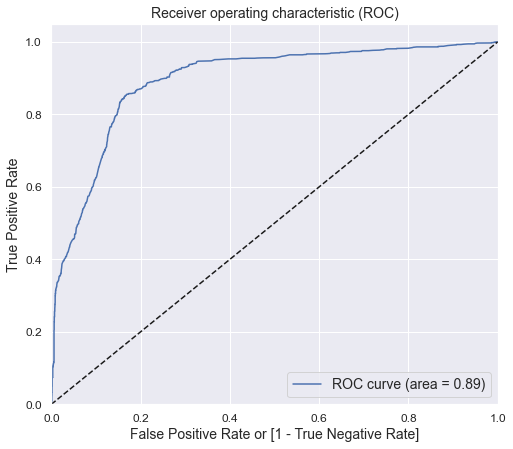

In [186]:
# Generate the ROC curve

draw_roc(y_train_pred_df_HBOS.Infected, y_train_pred_df_HBOS.Infected_Prob)

In [187]:
# Add different possible thresholds to our dataframe

num = [float (i/10) for i in range(10)]
for i in num:
    y_train_pred_df_HBOS[i] = y_train_pred_df_HBOS.Infected_Prob.map(lambda x: 1 if x > i else 0)

In [188]:
# Print dataframe
y_train_pred_df_HBOS.head()

,Infected,Infected_Prob,PatientID,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0,0.122501,0,1,1,0,0,0,0,0,0,0,0
1,0,0.116660,1,1,1,0,0,0,0,0,0,0,0
2,1,0.793873,2,1,1,1,1,1,1,1,1,0,0
3,0,0.117082,3,1,1,0,0,0,0,0,0,0,0
4,0,0.108078,4,1,1,0,0,0,0,0,0,0,0


In order to find the optimal threshold/cutoff point, we will need to calculate all the important metrics for these different thresholds - Sensitivity, Specificity & Accuracy - plot them and find the intersection where all of these metrics are balanced out in the model.

In [189]:
# Create a dataframe to store metrics for different thresholds

df_threshold = pd.DataFrame(columns = ['prob','accuracy','sensitivity','specificity'])

for i in num:
    cm = metrics.confusion_matrix(y_train_pred_df_HBOS.Infected,y_train_pred_df_HBOS[i])
    accuracy = metrics.accuracy_score(y_train_pred_df_HBOS.Infected,y_train_pred_df_HBOS[i])
    sensitivity = cm[1,1]/(cm[1,1]+cm[1,0])
    specificity = cm[0,0]/(cm[0,0]+cm[0,1])
    df_threshold.loc[i] = [i,accuracy,sensitivity,specificity]

    
df_threshold

,prob,accuracy,sensitivity,specificity
0.0,0.0,0.500000,1.000000,0.000000
0.1,0.1,0.543860,0.991659,0.096060
0.2,0.2,0.814064,0.936152,0.691976
0.3,0.3,0.827150,0.893299,0.761001
0.4,0.4,0.840811,0.844406,0.837216
0.5,0.5,0.840667,0.844118,0.837216
0.6,0.6,0.825856,0.795226,0.856485
0.7,0.7,0.790768,0.702042,0.879494
0.8,0.8,0.774374,0.655162,0.893586
0.9,0.9,0.655882,0.322980,0.988783


We will now plot the different values of each of the metrics to find the intersection where all them are balanced for our model.

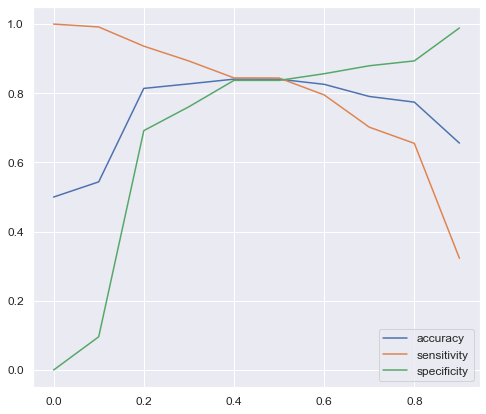

In [190]:
# Plot line graphs

df_threshold[['accuracy','sensitivity','specificity']].plot(figsize = (8,7))
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.legend(fontsize = 12)

The optimal threshold seems to lie somewhere between 0.5 and 0.6. Let us calculate the metrics for this range of values as well.

In [193]:
# Update the dataframe to store metrics for the new thresholds

#new_num = [0.51,0.52,0.53,0.54,0.541,0.542,0.543,0.544,0.545,0.56,0.57,0.58,0.59]
new_num = [0.51,0.52,0.53,0.54,0.55,0.551,0.552,0.553,0.554,0.555,0.556,0.557,0.558,0.559,0.56,0.57,0.58,0.59]

for i in new_num:
    y_train_pred_df_HBOS[i] = y_train_pred_df_HBOS.Infected_Prob.map(lambda x: 1 if x > i else 0)

y_train_pred_df_HBOS.head()

,Infected,Infected_Prob,PatientID,0.0,0.1,0.2,0.3,0.4,0.5,0.6,...,0.554,0.555,0.556,0.557,0.558,0.559,0.56,0.57,0.58,0.59
0,0,0.122501,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0.116660,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0.793873,2,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,0,0.117082,3,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0.108078,4,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [194]:
# Update df_threshold

for i in new_num:
    cm = metrics.confusion_matrix(y_train_pred_df_HBOS.Infected,y_train_pred_df_HBOS[i])
    accuracy = metrics.accuracy_score(y_train_pred_df_HBOS.Infected,y_train_pred_df_HBOS[i])
    sensitivity = cm[1,1]/(cm[1,1]+cm[1,0])
    specificity = cm[0,0]/(cm[0,0]+cm[0,1])
    df_threshold.loc[i] = [i,accuracy,sensitivity,specificity]

# sort the thresholds in ascending order for plotting

df_threshold.sort_values(by = 'prob', ascending = True, inplace = True)

df_threshold

,prob,accuracy,sensitivity,specificity
0.000,0.000,0.500000,1.000000,0.000000
0.100,0.100,0.543860,0.991659,0.096060
0.200,0.200,0.814064,0.936152,0.691976
0.300,0.300,0.827150,0.893299,0.761001
0.400,0.400,0.840811,0.844406,0.837216
0.500,0.500,0.840667,0.844118,0.837216
0.510,0.510,0.840667,0.843831,0.837504
0.520,0.520,0.841242,0.843831,0.838654
0.530,0.530,0.841099,0.843543,0.838654
0.540,0.540,0.841242,0.842680,0.839804


Let us fine tune the X-axis values in order to visualize the optimal threshold better.

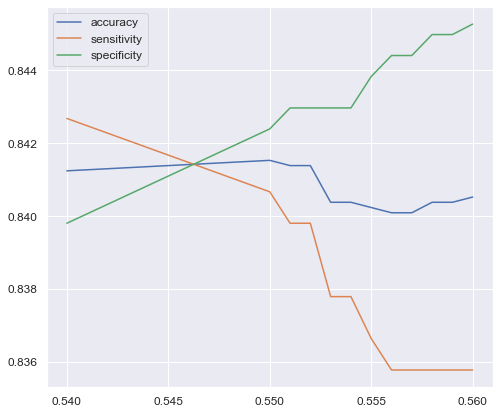

In [197]:
# Plot the graph only for probabilities between 0.54 and 0.545

df_threshold.loc[(df_threshold.prob >= 0.54) & (df_threshold.prob <= 0.56),['accuracy','sensitivity','specificity']].plot(figsize = (8,7))
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.legend(fontsize = 12)

The probability threshold value lies between 0.5450 and 0.5455. We will take the middle value of **0.54525** as getting anymore granular does not improve the performance metrics significantly.

In [199]:
# Map the final predictions into our table based on the calculated probability threshold

y_train_pred_df_HBOS['prediction'] = y_train_pred_df_HBOS['Infected_Prob'].map(lambda x: 1 if x > 0.54525 else 0)

In [200]:
# View a sample

y_train_pred_df_HBOS.head()

,Infected,Infected_Prob,PatientID,0.0,0.1,0.2,0.3,0.4,0.5,0.6,...,0.555,0.556,0.557,0.558,0.559,0.56,0.57,0.58,0.59,prediction
0,0,0.122501,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0.116660,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0.793873,2,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,0,0.117082,3,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0.108078,4,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [201]:
# Keep only necessary columns for better readability

y_train_pred_df_HBOS = y_train_pred_df_HBOS[['Infected','Infected_Prob','PatientID','prediction']]

In [202]:
# View sample

y_train_pred_df_HBOS.head()

,Infected,Infected_Prob,PatientID,prediction
0,0,0.122501,0,0
1,0,0.116660,1,0
2,1,0.793873,2,1
3,0,0.117082,3,0
4,0,0.108078,4,0


Let us evaluate the performance of the model based on the four performance metrics of our choice - Accuracy, Precision, Recall, F1 Score.

In [203]:
# Calculate accuracy

accuracy_train_LR_HBOS = metrics.accuracy_score(y_train_pred_df_HBOS.Infected,y_train_pred_df_HBOS.prediction)
accuracy_train_LR_HBOS

0.8418176589013517

We will create a confusion matrix to aid in calculating Precision and Recall.

In [204]:
# Create confusion matrix and print it

confusion_train_LR_HBOS = metrics.confusion_matrix(y_train_pred_df_HBOS.Infected,y_train_pred_df_HBOS.prediction)
confusion_train_LR_HBOS

array([[2926,  551],
       [ 549, 2928]], dtype=int64)

In [205]:
# Calculate Precision (TP /TP + FP)

precision_train_LR_HBOS = confusion_train_LR_HBOS[1,1]/(confusion_train_LR_HBOS[1,1] + confusion_train_LR_HBOS[0,1])
precision_train_LR_HBOS

0.8416211555044553

In [206]:
# Calculate Recall (TP /TP + FN)

recall_train_LR_HBOS = confusion_train_LR_HBOS[1,1]/(confusion_train_LR_HBOS[1,1] + confusion_train_LR_HBOS[1,0])
recall_train_LR_HBOS

0.8421052631578947

In [207]:
# Calculate F1 Score

f1_score_train_LR_HBOS = 2 * (recall_train_LR_HBOS * precision_train_LR_HBOS)/(recall_train_LR_HBOS + precision_train_LR_HBOS)
f1_score_train_LR_HBOS

0.8418631397354802

**Test Set Performance**

In [208]:
# Set same columns for X_test

X_test_bal_HBOS = X_test[X_train_bal_HBOS.columns]

In [209]:
# Predict probability of infection for test set

y_test_pred_HBOS = lr_model_HBOS_5.predict(sm.add_constant(X_test_bal_HBOS))

# View a sample of the predicted probabilities
y_test_pred_HBOS[:5]

1696    0.128591
880     0.093634
4555    0.110100
4121    0.127045
829     0.122501
dtype: float64

In [210]:
# Create dataframe

y_test_pred_df_HBOS = pd.DataFrame({'Infected':y_test.values,'Infected_Prob':y_test_pred_HBOS})
y_test_pred_df_HBOS['PatientID'] = y_test.index
y_test_pred_df_HBOS.head()

,Infected,Infected_Prob,PatientID
1696,0,0.128591,1696
880,0,0.093634,880
4555,0,0.110100,4555
4121,0,0.127045,4121
829,0,0.122501,829


In [211]:
# Add test prediction to dataframe

y_test_pred_df_HBOS['test_prediction'] = y_test_pred_df_HBOS.Infected_Prob.map(lambda x: 1 if x > 0.54525 else 0)

In [212]:
y_test_pred_df_HBOS.head()

,Infected,Infected_Prob,PatientID,test_prediction
1696,0,0.128591,1696,0
880,0,0.093634,880,0
4555,0,0.110100,4555,0
4121,0,0.127045,4121,0
829,0,0.122501,829,0


In [213]:
# Calculate test accuracy

accuracy_test_LR_HBOS = metrics.accuracy_score(y_test_pred_df_HBOS.Infected,y_test_pred_df_HBOS.test_prediction)
accuracy_test_LR_HBOS

0.8526100307062436

We will create a confusion matrix to aid in calculating Precision and Recall.

In [214]:
# Create confusion matrix

confusion_test_LR_HBOS = metrics.confusion_matrix(y_test_pred_df_HBOS.Infected,y_test_pred_df_HBOS.test_prediction)
confusion_test_LR_HBOS

array([[1229,  233],
       [  55,  437]], dtype=int64)

In [215]:
# Calculate Precision (TP /TP + FP)

precision_test_LR_HBOS = confusion_test_LR_HBOS[1,1]/(confusion_test_LR_HBOS[1,1] + confusion_test_LR_HBOS[0,1])
precision_test_LR_HBOS

0.6522388059701493

In [216]:
# Calculate Recall (TP /TP + FN)

recall_test_LR_HBOS = confusion_test_LR_HBOS[1,1]/(confusion_test_LR_HBOS[1,1] + confusion_test_LR_HBOS[1,0])
recall_test_LR_HBOS

0.8882113821138211

In [217]:
# Calculate F1 Score

f1_score_test_LR_HBOS = 2 * (recall_test_LR_HBOS * precision_test_LR_HBOS)/(recall_test_LR_HBOS + precision_test_LR_HBOS)
f1_score_test_LR_HBOS

0.7521514629948364

### Decision Tree - Isolation Forest

In [360]:
# Instantiate Decision Tree

dt_balanced_IF = DecisionTreeClassifier(random_state = 50, class_weight = 'balanced')
#dt_smote_IF = DecisionTreeClassifier(random_state = 50)

In [955]:
# Parameters for DT

params = {'max_depth':[2,4,6,8,10,12,15,18,20,22,25,28,30,32,36,40],
          'min_samples_split':[10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100],
          'min_samples_leaf': [10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100]
         }

In [956]:
# Instantiate GridSearchCV - basis f1 score - dt_balanced

grid_search_f1_balanced_IF = GridSearchCV(estimator = dt_balanced_IF,
                           cv = 4,
                          param_grid = params,
                          n_jobs = -1,
                          verbose = 1,
                          scoring = 'f1')

In [957]:
%%time

# Fit data - f1 score - dt_balanced

grid_search_f1_balanced_IF.fit(X_train_IF,y_train_IF)

Fitting 4 folds for each of 5776 candidates, totalling 23104 fits


KeyboardInterrupt: 

In [958]:
grid_search_f1_balanced_IF.best_params_

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [959]:
# Parameters for DT

params1 = {'max_depth':[8],
          'min_samples_split':[100,110,120,130,140,150,160,170,180,190,200],
          'min_samples_leaf': [15]
         }

In [960]:
# Instantiate GridSearchCV - basis f1 score - dt_balanced

grid_search_f1_balanced_IF1 = GridSearchCV(estimator = dt_balanced_IF,
                           cv = 4,
                          param_grid = params1,
                          n_jobs = -1,
                          verbose = 1,
                          scoring = 'f1')

In [961]:
%%time

# Fit data - f1 score - dt_balanced

grid_search_f1_balanced_IF1.fit(X_train_IF,y_train_IF)

Fitting 4 folds for each of 11 candidates, totalling 44 fits
Wall time: 4.04 s


GridSearchCV(cv=4,
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=50),
             n_jobs=-1,
             param_grid={'max_depth': [8], 'min_samples_leaf': [15],
                         'min_samples_split': [100, 110, 120, 130, 140, 150,
                                               160, 170, 180, 190, 200]},
             scoring='f1', verbose=1)

In [962]:
grid_search_f1_balanced_IF1.best_params_

{'max_depth': 8, 'min_samples_leaf': 15, 'min_samples_split': 160}

In [963]:
# Save the best performing model - balanced - f1 score

dt_best_f1_balanced_IF = grid_search_f1_balanced_IF1.best_estimator_

In [964]:
dt_best_f1_balanced_IF

DecisionTreeClassifier(class_weight='balanced', max_depth=8,
                       min_samples_leaf=15, min_samples_split=160,
                       random_state=50)

In [965]:
# DT Model Evaluation - balanced - f1 score

dt_f1_eval_balanced_IF = evaluate_model(dt_best_f1_balanced_IF,X_train_IF,X_test,y_train_IF,y_test)
dt_f1_eval_balanced_IF

Train Confusion Matrix: 
 [[3072  392]
 [ 120  746]]
Train Accuracy : 0.8817551963048499
Train Precision:  0.655536028119508
Train Recall:  0.8614318706697459
Train F1 Score:  0.7445109780439122
--------------------------------------------------
Test Confusion Matrix: 
 [[1302  160]
 [  65  427]]
Test Accuracy : 0.8848515864892528
Test Precision:  0.727427597955707
Test Recall:  0.8678861788617886
Test F1 Score:  0.7914735866543096


### Decision Tree - Extended Isolation Forest

In [387]:
# Instantiate Decision Tree

dt_balanced_EIF = DecisionTreeClassifier(random_state = 50, class_weight = 'balanced')
#dt_smote_EIF = DecisionTreeClassifier(random_state = 50)

In [388]:
# Parameters for DT

params = {'max_depth':[2,4,6,8,10,12,15,18,20,22,25,28,30,32,36,40],
          'min_samples_split':[10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100],
          'min_samples_leaf': [10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100]
         }

In [389]:
# Instantiate GridSearchCV - basis f1 score - dt_balanced

grid_search_f1_balanced_EIF = GridSearchCV(estimator = dt_balanced_EIF,
                           cv = 4,
                          param_grid = params,
                          n_jobs = -1,
                          verbose = 1,
                          scoring = 'f1')

In [390]:
%%time

# Fit data - f1 score - dt_BALANCED

grid_search_f1_balanced_EIF.fit(X_train_EIF,y_train_EIF)

Fitting 4 folds for each of 5776 candidates, totalling 23104 fits
Wall time: 1min 42s


GridSearchCV(cv=4,
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=50),
             n_jobs=-1,
             param_grid={'max_depth': [2, 4, 6, 8, 10, 12, 15, 18, 20, 22, 25,
                                       28, 30, 32, 36, 40],
                         'min_samples_leaf': [10, 15, 20, 25, 30, 35, 40, 45,
                                              50, 55, 60, 65, 70, 75, 80, 85,
                                              90, 95, 100],
                         'min_samples_split': [10, 15, 20, 25, 30, 35, 40, 45,
                                               50, 55, 60, 65, 70, 75, 80, 85,
                                               90, 95, 100]},
             scoring='f1', verbose=1)

In [391]:
grid_search_f1_balanced_EIF.best_params_

{'max_depth': 8, 'min_samples_leaf': 10, 'min_samples_split': 100}

In [392]:
# Parameters for DT

params1 = {'max_depth':[8],
          'min_samples_split':[100,110,120,130,140,150,160,170,180,190,200],
          'min_samples_leaf': [4,6,8,10,11,12,13,14]
         }

In [393]:
# Instantiate GridSearchCV - basis f1 score - dt_balanced

grid_search_f1_balanced_EIF1 = GridSearchCV(estimator = dt_balanced_EIF,
                           cv = 4,
                          param_grid = params1,
                          n_jobs = -1,
                          verbose = 1,
                          scoring = 'f1')

In [394]:
%%time

# Fit data - f1 score - dt_BALANCED

grid_search_f1_balanced_EIF1.fit(X_train_EIF,y_train_EIF)

Fitting 4 folds for each of 88 candidates, totalling 352 fits
Wall time: 1.6 s


GridSearchCV(cv=4,
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=50),
             n_jobs=-1,
             param_grid={'max_depth': [8],
                         'min_samples_leaf': [4, 6, 8, 10, 11, 12, 13, 14],
                         'min_samples_split': [100, 110, 120, 130, 140, 150,
                                               160, 170, 180, 190, 200]},
             scoring='f1', verbose=1)

In [395]:
grid_search_f1_balanced_EIF1.best_params_

{'max_depth': 8, 'min_samples_leaf': 13, 'min_samples_split': 160}

In [396]:
# Save the best performing model - balanced - f1 score

dt_best_f1_balanced_EIF = grid_search_f1_balanced_EIF1.best_estimator_

In [966]:
# DT Model Evaluation - balanced - f1 score

dt_f1_eval_balanced_EIF = evaluate_model(dt_best_f1_balanced_EIF,X_train_EIF,X_test,y_train_EIF,y_test)
dt_f1_eval_balanced_EIF

Train Confusion Matrix: 
 [[2932  399]
 [ 108  891]]
Train Accuracy : 0.8829099307159354
Train Precision:  0.6906976744186046
Train Recall:  0.8918918918918919
Train F1 Score:  0.7785058977719528
--------------------------------------------------
Test Confusion Matrix: 
 [[1290  172]
 [  63  429]]
Test Accuracy : 0.8797338792221086
Test Precision:  0.7138103161397671
Test Recall:  0.8719512195121951
Test F1 Score:  0.7849954254345838


### Decision Tree - HBOS

In [400]:
# Instantiate Decision Tree

dt_balanced_HBOS = DecisionTreeClassifier(class_weight = 'balanced',random_state = 50)

In [401]:
# Parameters for DT

params = {'max_depth':[2,4,6,8,10,12,15,18,20,22,25,28,30,32,36,40],
          'min_samples_split':[10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100],
          'min_samples_leaf': [10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100]
         }

In [402]:
# Instantiate GridSearchCV - basis f1 score - dt_balanced

grid_search_f1_balanced_HBOS = GridSearchCV(estimator = dt_balanced_HBOS,
                           cv = 4,
                          param_grid = params,
                          n_jobs = -1,
                          verbose = 1,
                          scoring = 'f1')

In [403]:
%%time

# Fit data - f1 score - dt_balanced

grid_search_f1_balanced_HBOS.fit(X_train_HBOS,y_train_HBOS)

Fitting 4 folds for each of 5776 candidates, totalling 23104 fits
Wall time: 1min 40s


GridSearchCV(cv=4,
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=50),
             n_jobs=-1,
             param_grid={'max_depth': [2, 4, 6, 8, 10, 12, 15, 18, 20, 22, 25,
                                       28, 30, 32, 36, 40],
                         'min_samples_leaf': [10, 15, 20, 25, 30, 35, 40, 45,
                                              50, 55, 60, 65, 70, 75, 80, 85,
                                              90, 95, 100],
                         'min_samples_split': [10, 15, 20, 25, 30, 35, 40, 45,
                                               50, 55, 60, 65, 70, 75, 80, 85,
                                               90, 95, 100]},
             scoring='f1', verbose=1)

In [404]:
grid_search_f1_balanced_HBOS.best_params_

{'max_depth': 8, 'min_samples_leaf': 15, 'min_samples_split': 100}

In [405]:
# Parameters for DT

params1 = {'max_depth':[8],
          'min_samples_split':[100,110,120,130,140,150,160,170,180,190,200],
          'min_samples_leaf': [15,16,17,18,19]
         }

In [406]:
# Instantiate GridSearchCV - basis f1 score - dt_balanced

grid_search_f1_balanced_HBOS1 = GridSearchCV(estimator = dt_balanced_HBOS,
                           cv = 4,
                          param_grid = params1,
                          n_jobs = -1,
                          verbose = 1,
                          scoring = 'f1')

In [407]:
%%time

# Fit data - f1 score - dt_balanced

grid_search_f1_balanced_HBOS1.fit(X_train_HBOS,y_train_HBOS)

Fitting 4 folds for each of 55 candidates, totalling 220 fits
Wall time: 1.17 s


GridSearchCV(cv=4,
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=50),
             n_jobs=-1,
             param_grid={'max_depth': [8],
                         'min_samples_leaf': [15, 16, 17, 18, 19],
                         'min_samples_split': [100, 110, 120, 130, 140, 150,
                                               160, 170, 180, 190, 200]},
             scoring='f1', verbose=1)

In [408]:
grid_search_f1_balanced_HBOS1.best_params_

{'max_depth': 8, 'min_samples_leaf': 15, 'min_samples_split': 160}

In [409]:
# Save the best performing model - smote - f1 score

dt_best_f1_balanced_HBOS = grid_search_f1_balanced_HBOS1.best_estimator_

In [967]:
# DT Model Evaluation - smote - f1 score

dt_f1_eval_balanced_HBOS = evaluate_model(dt_best_f1_balanced_HBOS,X_train_HBOS,X_test,y_train_HBOS,y_test)
dt_f1_eval_balanced_HBOS

Train Confusion Matrix: 
 [[3079  398]
 [ 120  734]]
Train Accuracy : 0.88039713691988
Train Precision:  0.6484098939929329
Train Recall:  0.8594847775175644
Train F1 Score:  0.7391742195367573
--------------------------------------------------
Test Confusion Matrix: 
 [[1302  160]
 [  65  427]]
Test Accuracy : 0.8848515864892528
Test Precision:  0.727427597955707
Test Recall:  0.8678861788617886
Test F1 Score:  0.7914735866543096


### Random Forest - Isolation Forest

In [437]:
# Import necessary packages

from sklearn.ensemble import RandomForestClassifier

In [438]:
# Instantiate Random Forest

rf_balanced_IF = RandomForestClassifier(random_state =50, class_weight = 'balanced')
#rf_smote_IF = RandomForestClassifier(random_state =50)

In [439]:
# CV parameters

params = {'max_depth':[8,10,15,20,25],
          'min_samples_split':[15,20,30,40,50,60,80,100],
          'min_samples_leaf': [10,20,40,60,80,90,100],
          'n_estimators':[10, 30, 50, 100]
         }

In [440]:
# Instantiate GridSearchCV - basis f1 score - rf_balanced

grid_search_f1_balanced_IF = GridSearchCV(estimator = rf_balanced_IF,
                           cv = 4,
                          param_grid = params,
                          n_jobs = -1,
                          verbose = 1,
                          scoring = 'f1')

In [441]:
%%time

# Fit data - f1 score - rf_balanced

grid_search_f1_balanced_IF.fit(X_train_IF,y_train_IF)

Fitting 4 folds for each of 1120 candidates, totalling 4480 fits
Wall time: 3min 46s


GridSearchCV(cv=4,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=50),
             n_jobs=-1,
             param_grid={'max_depth': [8, 10, 15, 20, 25],
                         'min_samples_leaf': [10, 20, 40, 60, 80, 90, 100],
                         'min_samples_split': [15, 20, 30, 40, 50, 60, 80, 100],
                         'n_estimators': [10, 30, 50, 100]},
             scoring='f1', verbose=1)

In [443]:
grid_search_f1_balanced_IF.best_params_

{'max_depth': 15,
 'min_samples_leaf': 10,
 'min_samples_split': 15,
 'n_estimators': 100}

In [460]:
# CV parameters

params1 = {'max_depth':[15],
          'min_samples_split':[5,6,8],
          'min_samples_leaf': [3,4,5,6],
          'n_estimators':[130,140,145]
         }

In [461]:
# Instantiate GridSearchCV - basis f1 score - rf_balanced

grid_search_f1_balanced_IF1 = GridSearchCV(estimator = rf_balanced_IF,
                           cv = 4,
                          param_grid = params1,
                          n_jobs = -1,
                          verbose = 1,
                          scoring = 'f1')

In [462]:
%%time

# Fit data - f1 score - rf_balanced

grid_search_f1_balanced_IF1.fit(X_train_IF,y_train_IF)

Fitting 4 folds for each of 36 candidates, totalling 144 fits
Wall time: 18.1 s


GridSearchCV(cv=4,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=50),
             n_jobs=-1,
             param_grid={'max_depth': [15], 'min_samples_leaf': [3, 4, 5, 6],
                         'min_samples_split': [5, 6, 8],
                         'n_estimators': [130, 140, 145]},
             scoring='f1', verbose=1)

In [463]:
grid_search_f1_balanced_IF1.best_params_

{'max_depth': 15,
 'min_samples_leaf': 3,
 'min_samples_split': 5,
 'n_estimators': 130}

In [464]:
# Save the best performing model - balanced - f1 score

rf_best_f1_balanced_IF = grid_search_f1_balanced_IF1.best_estimator_

In [970]:
# RF Model Evaluation - balanced - f1 score

rf_f1_eval_balanced_IF = evaluate_model(rf_best_f1_balanced_IF,X_train_IF,X_test,y_train_IF,y_test)
rf_f1_eval_balanced_IF

Train Confusion Matrix: 
 [[3051  413]
 [  84  782]]
Train Accuracy : 0.8852193995381062
Train Precision:  0.6543933054393305
Train Recall:  0.9030023094688222
Train F1 Score:  0.7588549247937894
--------------------------------------------------
Test Confusion Matrix: 
 [[1274  188]
 [  62  430]]
Test Accuracy : 0.872057318321392
Test Precision:  0.6957928802588996
Test Recall:  0.8739837398373984
Test F1 Score:  0.7747747747747747


### Random Forest - Extended Isolation Forest

In [324]:
# Instantiate Random Forest

rf_balanced_EIF = RandomForestClassifier(random_state =50, class_weight = 'balanced')
#rf_smote_EIF = RandomForestClassifier(random_state =50)

In [466]:
# CV parameters

params = {'max_depth':[8,10,15,20,25],
          'min_samples_split':[15,20,30,40,50,60,80,100],
          'min_samples_leaf': [10,20,40,60,80,90,100],
          'n_estimators':[10, 30, 50, 100]
         }

In [469]:
# Instantiate GridSearchCV - basis f1 score - rf_balanced

grid_search_f1_balanced_EIF = GridSearchCV(estimator = rf_balanced_EIF,
                           cv = 4,
                          param_grid = params,
                          n_jobs = -1,
                          verbose = 1,
                          scoring = 'f1')

In [470]:
%%time

# Fit data - f1 score - rf_balanced

grid_search_f1_balanced_EIF.fit(X_train_EIF,y_train_EIF)

Fitting 4 folds for each of 1120 candidates, totalling 4480 fits
Wall time: 4min 38s


GridSearchCV(cv=4,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=50),
             n_jobs=-1,
             param_grid={'max_depth': [8, 10, 15, 20, 25],
                         'min_samples_leaf': [10, 20, 40, 60, 80, 90, 100],
                         'min_samples_split': [15, 20, 30, 40, 50, 60, 80, 100],
                         'n_estimators': [10, 30, 50, 100]},
             scoring='f1', verbose=1)

In [471]:
 grid_search_f1_balanced_EIF.best_params_

{'max_depth': 10,
 'min_samples_leaf': 10,
 'min_samples_split': 15,
 'n_estimators': 10}

In [476]:
# CV parameters

params1 = {'max_depth':[10,12,14],
          'min_samples_split':[5,6,8,9],
          'min_samples_leaf': [3],
          'n_estimators':[12,13,14]
         }

In [477]:
# Instantiate GridSearchCV - basis f1 score - rf_balanced

grid_search_f1_balanced_EIF1 = GridSearchCV(estimator = rf_balanced_EIF,
                           cv = 4,
                          param_grid = params1,
                          n_jobs = -1,
                          verbose = 1,
                          scoring = 'f1')

In [478]:
%%time

# Fit data - f1 score - rf_balanced

grid_search_f1_balanced_EIF1.fit(X_train_EIF,y_train_EIF)

Fitting 4 folds for each of 36 candidates, totalling 144 fits
Wall time: 1.77 s


GridSearchCV(cv=4,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=50),
             n_jobs=-1,
             param_grid={'max_depth': [10, 12, 14], 'min_samples_leaf': [3],
                         'min_samples_split': [5, 6, 8, 9],
                         'n_estimators': [12, 13, 14]},
             scoring='f1', verbose=1)

In [479]:
 grid_search_f1_balanced_EIF1.best_params_

{'max_depth': 12,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 13}

In [480]:
# Save the best performing model - balanced - f1 score

rf_best_f1_balanced_EIF = grid_search_f1_balanced_EIF1.best_estimator_

In [971]:
# RF Model Evaluation - balanced - f1 score

rf_f1_eval_balanced_EIF = evaluate_model(rf_best_f1_balanced_EIF,X_train_EIF,X_test,y_train_EIF,y_test)
rf_f1_eval_balanced_EIF

Train Confusion Matrix: 
 [[2939  392]
 [  92  907]]
Train Accuracy : 0.8882217090069284
Train Precision:  0.6982294072363356
Train Recall:  0.9079079079079079
Train F1 Score:  0.7893820713664055
--------------------------------------------------
Test Confusion Matrix: 
 [[1285  177]
 [  66  426]]
Test Accuracy : 0.8756397134083931
Test Precision:  0.7064676616915423
Test Recall:  0.8658536585365854
Test F1 Score:  0.7780821917808219


### Random Forest - HBOS

In [482]:
# Instantiate Random Forest

rf_balanced_HBOS = RandomForestClassifier(random_state =50, class_weight = 'balanced')


In [483]:
# CV parameters

params = {'max_depth':[8,10,15,20,25],
          'min_samples_split':[15,20,30,40,50,60,80,100],
          'min_samples_leaf': [10,20,40,60,80,90,100],
          'n_estimators':[10, 30, 50, 100]
         }

In [485]:
# Instantiate GridSearchCV - basis f1 score - rf_balanced

grid_search_f1_balanced_HBOS = GridSearchCV(estimator = rf_balanced_HBOS,
                           cv = 4,
                          param_grid = params,
                          n_jobs = -1,
                          verbose = 1,
                          scoring = 'f1')

In [486]:
%%time

# Fit data - f1 score - rf_balanced

grid_search_f1_balanced_HBOS.fit(X_train_HBOS,y_train_HBOS)

Fitting 4 folds for each of 1120 candidates, totalling 4480 fits
Wall time: 4min 11s


GridSearchCV(cv=4,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=50),
             n_jobs=-1,
             param_grid={'max_depth': [8, 10, 15, 20, 25],
                         'min_samples_leaf': [10, 20, 40, 60, 80, 90, 100],
                         'min_samples_split': [15, 20, 30, 40, 50, 60, 80, 100],
                         'n_estimators': [10, 30, 50, 100]},
             scoring='f1', verbose=1)

In [487]:
grid_search_f1_balanced_HBOS.best_params_

{'max_depth': 10,
 'min_samples_leaf': 10,
 'min_samples_split': 15,
 'n_estimators': 10}

In [498]:
# CV parameters

params1 = {'max_depth':[10,12,14],
          'min_samples_split':[5,8,10,12,15],
          'min_samples_leaf': [3,5,6,8,10],
          'n_estimators':[5,6,8,10,12]
         }

In [499]:
# Instantiate GridSearchCV - basis f1 score - rf_balanced

grid_search_f1_balanced_HBOS1 = GridSearchCV(estimator = rf_balanced_HBOS,
                           cv = 4,
                          param_grid = params1,
                          n_jobs = -1,
                          verbose = 1,
                          scoring = 'f1')

In [500]:
%%time

# Fit data - f1 score - rf_balanced

grid_search_f1_balanced_HBOS1.fit(X_train_HBOS,y_train_HBOS)

Fitting 4 folds for each of 375 candidates, totalling 1500 fits
Wall time: 13.1 s


GridSearchCV(cv=4,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=50),
             n_jobs=-1,
             param_grid={'max_depth': [10, 12, 14],
                         'min_samples_leaf': [3, 5, 6, 8, 10],
                         'min_samples_split': [5, 8, 10, 12, 15],
                         'n_estimators': [5, 6, 8, 10, 12]},
             scoring='f1', verbose=1)

In [501]:
grid_search_f1_balanced_HBOS1.best_params_

{'max_depth': 12,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 6}

In [502]:
# Save the best performing model - smote - f1 score

rf_best_f1_balanced_HBOS = grid_search_f1_balanced_HBOS1.best_estimator_

In [972]:
# RF Model Evaluation - smote - f1 score

rf_f1_eval_balanced_HBOS = evaluate_model(rf_best_f1_balanced_HBOS,X_train_HBOS,X_test,y_train_HBOS,y_test)
rf_f1_eval_balanced_HBOS

Train Confusion Matrix: 
 [[3016  461]
 [  96  758]]
Train Accuracy : 0.8713922881551605
Train Precision:  0.6218211648892535
Train Recall:  0.8875878220140515
Train F1 Score:  0.7313072841292813
--------------------------------------------------
Test Confusion Matrix: 
 [[1259  203]
 [  65  427]]
Test Accuracy : 0.8628454452405322
Test Precision:  0.6777777777777778
Test Recall:  0.8678861788617886
Test F1 Score:  0.7611408199643495


### XGBoost - IF

In [2175]:
# Import necessary packages

from xgboost import XGBClassifier

In [785]:
# Instantiate XGBoost


xgb_balanced_IF = XGBClassifier(objective = 'binary:logistic',subsample = 0.9,colsample_bytree = 0.5,random_state =50)

In [786]:
# CV parameters

params = {'max_depth':[3,4,5,6],
          'learning_rate': [0.1,0.01,0.05],
          'gamma': [0,0.25,0.5],
          'reg_lambda': [0,1.0,3.0,5.0],
          'scale_pos_weight': [1,3,5]
         }

In [787]:
# Instantiate GridSearchCV - basis auc score - xgb_balanced

grid_search_auc_balanced_IF = GridSearchCV(estimator = xgb_balanced_IF,
                           cv = 4,
                          param_grid = params,
                          n_jobs = -1,
                          verbose = 1,
                          scoring = 'f1')

In [788]:
%%time

# Fit data - auc score - xgb_balanced

grid_search_auc_balanced_IF.fit(X_train_IF,y_train_IF, 
                            early_stopping_rounds = 20,
                            eval_metric = 'auc',
                           eval_set = [(X_test,y_test)])
                                      

Fitting 4 folds for each of 432 candidates, totalling 1728 fits
[0]	validation_0-auc:0.80671
[1]	validation_0-auc:0.86252
[2]	validation_0-auc:0.86149
[3]	validation_0-auc:0.91857
[4]	validation_0-auc:0.91907
[5]	validation_0-auc:0.91178
[6]	validation_0-auc:0.91879
[7]	validation_0-auc:0.92423
[8]	validation_0-auc:0.92150
[9]	validation_0-auc:0.92295
[10]	validation_0-auc:0.92927
[11]	validation_0-auc:0.92783
[12]	validation_0-auc:0.92600
[13]	validation_0-auc:0.91954
[14]	validation_0-auc:0.92323
[15]	validation_0-auc:0.92498
[16]	validation_0-auc:0.92311
[17]	validation_0-auc:0.92211
[18]	validation_0-auc:0.92440
[19]	validation_0-auc:0.92635
[20]	validation_0-auc:0.92541
[21]	validation_0-auc:0.92840


C:\Users\arvin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22]	validation_0-auc:0.92918
[23]	validation_0-auc:0.93099
[24]	validation_0-auc:0.93133
[25]	validation_0-auc:0.93317
[26]	validation_0-auc:0.93408
[27]	validation_0-auc:0.93390
[28]	validation_0-auc:0.93445
[29]	validation_0-auc:0.93488
[30]	validation_0-auc:0.93478
[31]	validation_0-auc:0.93504
[32]	validation_0-auc:0.93593
[33]	validation_0-auc:0.93603
[34]	validation_0-auc:0.93592
[35]	validation_0-auc:0.93555
[36]	validation_0-auc:0.93581
[37]	validation_0-auc:0.93570
[38]	validation_0-auc:0.93581
[39]	validation_0-auc:0.93632
[40]	validation_0-auc:0.93798
[41]	validation_0-auc:0.93785
[42]	validation_0-auc:0.93766
[43]	validation_0-auc:0.93783
[44]	validation_0-auc:0.93795
[45]	validation_0-auc:0.93807
[46]	validation_0-auc:0.93817
[47]	validation_0-auc:0.93818
[48]	validation_0-auc:0.93821
[49]	validation_0-auc:0.93824
[50]	validation_0-auc:0.93852
[51]	validation_0-auc:0.93834
[52]	validation_0-auc:0.93817
[53]	validation_0-auc:0.93809
[54]	validation_0-auc:0.93835
[55]	valid

GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.5,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n...
                                     num_parallel_tree=None, predictor=None,
                                     random_state=50, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                      

In [790]:
# Best params

grid_search_auc_balanced_IF.best_params_

{'gamma': 0.25,
 'learning_rate': 0.1,
 'max_depth': 5,
 'reg_lambda': 0,
 'scale_pos_weight': 3}

In [804]:
# CV parameters

params1 = {'max_depth':[4,5],
          'learning_rate': [0.7,0.75,0.8,1.0],
          'gamma': [0.1],
          'reg_lambda': [0.7],
          'scale_pos_weight': [1,2,3,4]
         }

In [805]:
# Instantiate GridSearchCV - basis auc score - xgb_balanced

grid_search_auc_balanced1_IF = GridSearchCV(estimator = xgb_balanced_IF,
                           cv = 4,
                          param_grid = params1,
                          n_jobs = -1,
                          verbose = 1,
                          scoring = 'f1')

In [806]:
%%time

# Fit data - auc score - xgb_balanced

grid_search_auc_balanced1_IF.fit(X_train_IF,y_train_IF, 
                            early_stopping_rounds = 20,
                            eval_metric = 'auc',
                           eval_set = [(X_test,y_test)])
                                      

Fitting 4 folds for each of 32 candidates, totalling 128 fits
[0]	validation_0-auc:0.80642
[1]	validation_0-auc:0.86222
[2]	validation_0-auc:0.86247
[3]	validation_0-auc:0.92025
[4]	validation_0-auc:0.92647
[5]	validation_0-auc:0.92421
[6]	validation_0-auc:0.92982
[7]	validation_0-auc:0.93045
[8]	validation_0-auc:0.93016
[9]	validation_0-auc:0.92993
[10]	validation_0-auc:0.93530
[11]	validation_0-auc:0.93490
[12]	validation_0-auc:0.93564
[13]	validation_0-auc:0.93327
[14]	validation_0-auc:0.93324
[15]	validation_0-auc:0.93364
[16]	validation_0-auc:0.93388
[17]	validation_0-auc:0.93386
[18]	validation_0-auc:0.93351
[19]	validation_0-auc:0.93547
[20]	validation_0-auc:0.93537
[21]	validation_0-auc:0.93599
[22]	validation_0-auc:0.93577
[23]	validation_0-auc:0.93623
[24]	validation_0-auc:0.93641
[25]	validation_0-auc:0.93699
[26]	validation_0-auc:0.93719
[27]	validation_0-auc:0.93661
[28]	validation_0-auc:0.93669
[29]	validation_0-auc:0.93566
[30]	validation_0-auc:0.93572
[31]	validation_0-

C:\Users\arvin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[41]	validation_0-auc:0.93402
[42]	validation_0-auc:0.93423
[43]	validation_0-auc:0.93453
[44]	validation_0-auc:0.93408
[45]	validation_0-auc:0.93396
[46]	validation_0-auc:0.93383
Wall time: 5.54 s


GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.5,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n...jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=50, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
            

In [809]:
# Best params

grid_search_auc_balanced1_IF.best_params_

{'gamma': 0.1,
 'learning_rate': 0.7,
 'max_depth': 4,
 'reg_lambda': 0.7,
 'scale_pos_weight': 2}

In [810]:
# Build final model based on params

xgb_balanced_final_IF = grid_search_auc_balanced1_IF.best_estimator_

In [811]:
best_iteration_IF = xgb_balanced_final_IF.get_booster().best_iteration
best_iteration_IF

26

In [973]:
evaluate_model_xgboost(xgb_balanced_final_IF,X_train_IF,X_test,y_train_IF,y_test,best_iteration_IF)

C:\Users\arvin\anaconda3\lib\site-packages\xgboost\core.py:108: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
C:\Users\arvin\anaconda3\lib\site-packages\xgboost\core.py:108: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
C:\Users\arvin\anaconda3\lib\site-packages\xgboost\core.py:108: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
C:\Users\arvin\anaconda3\lib\site-packages\xgboost\core.py:108: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


Train Confusion Matrix: 
 [[3102  362]
 [ 122  744]]
Train Accuracy : 0.8882217090069284
Train Precision:  0.6726943942133815
Train Recall:  0.859122401847575
Train F1 Score:  0.7545638945233265
--------------------------------------------------
Test Confusion Matrix: 
 [[1308  154]
 [  68  424]]
Test Accuracy : 0.8863868986693961
Test Precision:  0.7335640138408305
Test Recall:  0.8617886178861789
Test F1 Score:  0.7925233644859814


### XGBoost - EIF

In [2175]:
# Import necessary packages

from xgboost import XGBClassifier

In [768]:
# Instantiate XGBoost


xgb_balanced_EIF = XGBClassifier(objective = 'binary:logistic',subsample = 0.9,colsample_bytree = 0.5,random_state =50)

In [769]:
# CV parameters

params = {'max_depth':[3,4,5,6],
          'learning_rate': [0.1,0.01,0.05],
          'gamma': [0,0.25,0.5],
          'reg_lambda': [0,1.0,3.0,5.0],
          'scale_pos_weight': [1,3,5]
         }

In [770]:
# Instantiate GridSearchCV - basis auc score - xgb_balanced

grid_search_auc_balanced_EIF = GridSearchCV(estimator = xgb_balanced_EIF,
                           cv = 4,
                          param_grid = params,
                          n_jobs = -1,
                          verbose = 1,
                          scoring = 'f1')

In [771]:
%%time

# Fit data - auc score - xgb_balanced

grid_search_auc_balanced_EIF.fit(X_train_EIF,y_train_EIF, 
                            early_stopping_rounds = 20,
                            eval_metric = 'auc',
                           eval_set = [(X_test,y_test)])
                                      

Fitting 4 folds for each of 432 candidates, totalling 1728 fits
[0]	validation_0-auc:0.80634
[1]	validation_0-auc:0.85090
[2]	validation_0-auc:0.85235
[3]	validation_0-auc:0.91322
[4]	validation_0-auc:0.91557
[5]	validation_0-auc:0.91065
[6]	validation_0-auc:0.91512
[7]	validation_0-auc:0.91882
[8]	validation_0-auc:0.91701
[9]	validation_0-auc:0.91817
[10]	validation_0-auc:0.92446
[11]	validation_0-auc:0.92095
[12]	validation_0-auc:0.92049
[13]	validation_0-auc:0.91869
[14]	validation_0-auc:0.92024
[15]	validation_0-auc:0.92091
[16]	validation_0-auc:0.91990
[17]	validation_0-auc:0.92005
[18]	validation_0-auc:0.92165
[19]	validation_0-auc:0.92315
[20]	validation_0-auc:0.92271


C:\Users\arvin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21]	validation_0-auc:0.92508
[22]	validation_0-auc:0.92553
[23]	validation_0-auc:0.92638
[24]	validation_0-auc:0.92813
[25]	validation_0-auc:0.92970
[26]	validation_0-auc:0.93001
[27]	validation_0-auc:0.93003
[28]	validation_0-auc:0.93034
[29]	validation_0-auc:0.93026
[30]	validation_0-auc:0.93022
[31]	validation_0-auc:0.93101
[32]	validation_0-auc:0.93205
[33]	validation_0-auc:0.93251
[34]	validation_0-auc:0.93279
[35]	validation_0-auc:0.93256
[36]	validation_0-auc:0.93268
[37]	validation_0-auc:0.93225
[38]	validation_0-auc:0.93211
[39]	validation_0-auc:0.93223
[40]	validation_0-auc:0.93295
[41]	validation_0-auc:0.93289
[42]	validation_0-auc:0.93267
[43]	validation_0-auc:0.93280
[44]	validation_0-auc:0.93310
[45]	validation_0-auc:0.93289
[46]	validation_0-auc:0.93294
[47]	validation_0-auc:0.93318
[48]	validation_0-auc:0.93353
[49]	validation_0-auc:0.93341
[50]	validation_0-auc:0.93325
[51]	validation_0-auc:0.93329
[52]	validation_0-auc:0.93305
[53]	validation_0-auc:0.93293
[54]	valid

GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.5,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n...
                                     num_parallel_tree=None, predictor=None,
                                     random_state=50, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                      

In [741]:
# Best params

grid_search_auc_balanced_EIF.best_params_

{'gamma': 0.5,
 'learning_rate': 0.1,
 'max_depth': 4,
 'reg_lambda': 1.0,
 'scale_pos_weight': 1}

In [777]:
# CV parameters

params1 = {'max_depth':[4],
          'learning_rate': [0.4,0.5,0.6],
          'gamma': [0.65,0.7,0.8],
          'reg_lambda': [0.85,1.0,1.15],
          'scale_pos_weight': [1,2,3]
         }

In [778]:
# Instantiate GridSearchCV - basis auc score - xgb_balanced

grid_search_auc_balanced1_EIF = GridSearchCV(estimator = xgb_balanced_EIF,
                           cv = 4,
                          param_grid = params1,
                          n_jobs = -1,
                          verbose = 1,
                          scoring = 'f1')

In [779]:
%%time

# Fit data - auc score - xgb_balanced

grid_search_auc_balanced1_EIF.fit(X_train_EIF,y_train_EIF, 
                            early_stopping_rounds = 20,
                            eval_metric = 'auc',
                           eval_set = [(X_test,y_test)])
                                      

Fitting 4 folds for each of 81 candidates, totalling 324 fits
[0]	validation_0-auc:0.80665
[1]	validation_0-auc:0.85757
[2]	validation_0-auc:0.85687
[3]	validation_0-auc:0.91920
[4]	validation_0-auc:0.92605
[5]	validation_0-auc:0.92431
[6]	validation_0-auc:0.92753
[7]	validation_0-auc:0.92731
[8]	validation_0-auc:0.92740
[9]	validation_0-auc:0.92734
[10]	validation_0-auc:0.92832
[11]	validation_0-auc:0.92761
[12]	validation_0-auc:0.92766
[13]	validation_0-auc:0.92617
[14]	validation_0-auc:0.92646
[15]	validation_0-auc:0.92644
[16]	validation_0-auc:0.92685
[17]	validation_0-auc:0.92696
[18]	validation_0-auc:0.92661
[19]	validation_0-auc:0.93112
[20]	validation_0-auc:0.93146
[21]	validation_0-auc:0.92992
[22]	validation_0-auc:0.92847
[23]	validation_0-auc:0.93050
[24]	validation_0-auc:0.93196
[25]	validation_0-auc:0.93277
[26]	validation_0-auc:0.93303
[27]	validation_0-auc:0.93277
[28]	validation_0-auc:0.93292
[29]	validation_0-auc:0.93267
[30]	validation_0-auc:0.93267
[31]	validation_0-

C:\Users\arvin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[37]	validation_0-auc:0.93396
[38]	validation_0-auc:0.93382
[39]	validation_0-auc:0.93331
[40]	validation_0-auc:0.93336
[41]	validation_0-auc:0.93354
[42]	validation_0-auc:0.93336
[43]	validation_0-auc:0.93348
[44]	validation_0-auc:0.93331
[45]	validation_0-auc:0.93334
[46]	validation_0-auc:0.93349
[47]	validation_0-auc:0.93361
[48]	validation_0-auc:0.93383
[49]	validation_0-auc:0.93433
[50]	validation_0-auc:0.93393
[51]	validation_0-auc:0.93236
[52]	validation_0-auc:0.93227
[53]	validation_0-auc:0.93251
[54]	validation_0-auc:0.93247
[55]	validation_0-auc:0.93125
[56]	validation_0-auc:0.93117
[57]	validation_0-auc:0.92984
[58]	validation_0-auc:0.92955
[59]	validation_0-auc:0.92982
[60]	validation_0-auc:0.93106
[61]	validation_0-auc:0.93047
[62]	validation_0-auc:0.93047
[63]	validation_0-auc:0.93047
[64]	validation_0-auc:0.93121
[65]	validation_0-auc:0.93076
[66]	validation_0-auc:0.93082
[67]	validation_0-auc:0.93061
[68]	validation_0-auc:0.93123
[69]	validation_0-auc:0.93106
Wall time:

GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.5,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n...
                                     num_parallel_tree=None, predictor=None,
                                     random_state=50, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                      

In [808]:
# Best params

grid_search_auc_balanced1_EIF.best_params_

{'gamma': 0.65,
 'learning_rate': 0.5,
 'max_depth': 4,
 'reg_lambda': 1.0,
 'scale_pos_weight': 2}

In [782]:
# Build final model based on params

xgb_balanced_final_EIF = grid_search_auc_balanced1_EIF.best_estimator_

In [783]:
best_iteration_EIF = xgb_balanced_final_EIF.get_booster().best_iteration
best_iteration_EIF

49

In [974]:
evaluate_model_xgboost(xgb_balanced_final_EIF,X_train_EIF,X_test,y_train_EIF,y_test,best_iteration_EIF)

Train Confusion Matrix: 
 [[2987  344]
 [ 117  882]]
Train Accuracy : 0.8935334872979215
Train Precision:  0.7194127243066885
Train Recall:  0.8828828828828829
Train F1 Score:  0.7928089887640449
--------------------------------------------------
Test Confusion Matrix: 
 [[1318  144]
 [  81  411]]
Test Accuracy : 0.8848515864892528
Test Precision:  0.7405405405405405
Test Recall:  0.8353658536585366
Test F1 Score:  0.7851002865329513


C:\Users\arvin\anaconda3\lib\site-packages\xgboost\core.py:108: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
C:\Users\arvin\anaconda3\lib\site-packages\xgboost\core.py:108: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
C:\Users\arvin\anaconda3\lib\site-packages\xgboost\core.py:108: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
C:\Users\arvin\anaconda3\lib\site-packages\xgboost\core.py:108: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


### XGBoost - HBOS

In [2175]:
# Import necessary packages

from xgboost import XGBClassifier

In [835]:
# Instantiate XGBoost


xgb_balanced_HBOS = XGBClassifier(objective = 'binary:logistic',subsample = 0.9,colsample_bytree = 0.5,random_state =50)

In [836]:
# CV parameters

params = {'max_depth':[3,4,5,6],
          'learning_rate': [0.1,0.01,0.05],
          'gamma': [0,0.25,0.5],
          'reg_lambda': [0,1.0,3.0,5.0],
          'scale_pos_weight': [1,3,5]
         }

In [838]:
# Instantiate GridSearchCV - basis auc score - xgb_balanced

grid_search_auc_balanced_HBOS = GridSearchCV(estimator = xgb_balanced_HBOS,
                           cv = 4,
                          param_grid = params,
                          n_jobs = -1,
                          verbose = 1,
                          scoring = 'f1')

In [839]:
%%time

# Fit data - auc score - xgb_balanced

grid_search_auc_balanced_HBOS.fit(X_train_HBOS,y_train_HBOS, 
                            early_stopping_rounds = 20,
                            eval_metric = 'auc',
                           eval_set = [(X_test,y_test)])
                                      

Fitting 4 folds for each of 432 candidates, totalling 1728 fits
[0]	validation_0-auc:0.80593
[1]	validation_0-auc:0.90878
[2]	validation_0-auc:0.90475
[3]	validation_0-auc:0.90481
[4]	validation_0-auc:0.90609
[5]	validation_0-auc:0.91908
[6]	validation_0-auc:0.92695
[7]	validation_0-auc:0.93138
[8]	validation_0-auc:0.93032
[9]	validation_0-auc:0.93069
[10]	validation_0-auc:0.92963
[11]	validation_0-auc:0.93072
[12]	validation_0-auc:0.93057
[13]	validation_0-auc:0.92961
[14]	validation_0-auc:0.92942
[15]	validation_0-auc:0.92953
[16]	validation_0-auc:0.93032
[17]	validation_0-auc:0.93155
[18]	validation_0-auc:0.93127
[19]	validation_0-auc:0.93145
[20]	validation_0-auc:0.93111
[21]	validation_0-auc:0.93133
[22]	validation_0-auc:0.93206
[23]	validation_0-auc:0.93183
[24]	validation_0-auc:0.93197
[25]	validation_0-auc:0.93241
[26]	validation_0-auc:0.93300
[27]	validation_0-auc:0.93387
[28]	validation_0-auc:0.93379
[29]	validation_0-auc:0.93339


C:\Users\arvin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[30]	validation_0-auc:0.93390
[31]	validation_0-auc:0.93459
[32]	validation_0-auc:0.93502
[33]	validation_0-auc:0.93509
[34]	validation_0-auc:0.93508
[35]	validation_0-auc:0.93519
[36]	validation_0-auc:0.93537
[37]	validation_0-auc:0.93579
[38]	validation_0-auc:0.93612
[39]	validation_0-auc:0.93679
[40]	validation_0-auc:0.93669
[41]	validation_0-auc:0.93672
[42]	validation_0-auc:0.93669
[43]	validation_0-auc:0.93652
[44]	validation_0-auc:0.93694
[45]	validation_0-auc:0.93712
[46]	validation_0-auc:0.93719
[47]	validation_0-auc:0.93675
[48]	validation_0-auc:0.93673
[49]	validation_0-auc:0.93708
[50]	validation_0-auc:0.93729
[51]	validation_0-auc:0.93733
[52]	validation_0-auc:0.93736
[53]	validation_0-auc:0.93747
[54]	validation_0-auc:0.93756
[55]	validation_0-auc:0.93765
[56]	validation_0-auc:0.93758
[57]	validation_0-auc:0.93761
[58]	validation_0-auc:0.93765
[59]	validation_0-auc:0.93753
[60]	validation_0-auc:0.93771
[61]	validation_0-auc:0.93762
[62]	validation_0-auc:0.93760
[63]	valid

GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.5,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n...
                                     num_parallel_tree=None, predictor=None,
                                     random_state=50, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                      

In [840]:
# Best params

grid_search_auc_balanced_HBOS.best_params_

{'gamma': 0.25,
 'learning_rate': 0.1,
 'max_depth': 4,
 'reg_lambda': 1.0,
 'scale_pos_weight': 3}

In [845]:
# CV parameters

params1 = {'max_depth':[3,4,5,6],
          'learning_rate': [0.15,0.25,0.4],
          'gamma': [0.25],
          'reg_lambda': [1.0],
          'scale_pos_weight': [1,2,3,4]
         }

In [846]:
# Instantiate GridSearchCV - basis auc score - xgb_balanced

grid_search_auc_balanced1_HBOS = GridSearchCV(estimator = xgb_balanced_HBOS,
                           cv = 4,
                          param_grid = params1,
                          n_jobs = -1,
                          verbose = 1,
                          scoring = 'f1')

In [847]:
%%time

# Fit data - auc score - xgb_balanced

grid_search_auc_balanced1_HBOS.fit(X_train_HBOS,y_train_HBOS, 
                            early_stopping_rounds = 20,
                            eval_metric = 'auc',
                           eval_set = [(X_test,y_test)])
                                      

Fitting 4 folds for each of 48 candidates, totalling 192 fits
[0]	validation_0-auc:0.80494
[1]	validation_0-auc:0.91172
[2]	validation_0-auc:0.90905
[3]	validation_0-auc:0.90878
[4]	validation_0-auc:0.90901
[5]	validation_0-auc:0.92322
[6]	validation_0-auc:0.92742
[7]	validation_0-auc:0.93072
[8]	validation_0-auc:0.92944
[9]	validation_0-auc:0.93002
[10]	validation_0-auc:0.92962
[11]	validation_0-auc:0.93011
[12]	validation_0-auc:0.92996
[13]	validation_0-auc:0.92991
[14]	validation_0-auc:0.93183
[15]	validation_0-auc:0.93159
[16]	validation_0-auc:0.93250
[17]	validation_0-auc:0.93372
[18]	validation_0-auc:0.93354
[19]	validation_0-auc:0.93374
[20]	validation_0-auc:0.93331
[21]	validation_0-auc:0.93366
[22]	validation_0-auc:0.93414
[23]	validation_0-auc:0.93411
[24]	validation_0-auc:0.93421
[25]	validation_0-auc:0.93447
[26]	validation_0-auc:0.93551
[27]	validation_0-auc:0.93609
[28]	validation_0-auc:0.93628


C:\Users\arvin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[29]	validation_0-auc:0.93577
[30]	validation_0-auc:0.93602
[31]	validation_0-auc:0.93615
[32]	validation_0-auc:0.93637
[33]	validation_0-auc:0.93658
[34]	validation_0-auc:0.93663
[35]	validation_0-auc:0.93662
[36]	validation_0-auc:0.93612
[37]	validation_0-auc:0.93624
[38]	validation_0-auc:0.93631
[39]	validation_0-auc:0.93686
[40]	validation_0-auc:0.93703
[41]	validation_0-auc:0.93725
[42]	validation_0-auc:0.93718
[43]	validation_0-auc:0.93743
[44]	validation_0-auc:0.93758
[45]	validation_0-auc:0.93729
[46]	validation_0-auc:0.93740
[47]	validation_0-auc:0.93733
[48]	validation_0-auc:0.93733
[49]	validation_0-auc:0.93734
[50]	validation_0-auc:0.93762
[51]	validation_0-auc:0.93766
[52]	validation_0-auc:0.93785
[53]	validation_0-auc:0.93804
[54]	validation_0-auc:0.93773
[55]	validation_0-auc:0.93780
[56]	validation_0-auc:0.93769
[57]	validation_0-auc:0.93760
[58]	validation_0-auc:0.93775
[59]	validation_0-auc:0.93776
[60]	validation_0-auc:0.93736
[61]	validation_0-auc:0.93741
[62]	valid

GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.5,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n...bs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=50, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
              

In [848]:
# Best params

grid_search_auc_balanced1_HBOS.best_params_

{'gamma': 0.25,
 'learning_rate': 0.15,
 'max_depth': 5,
 'reg_lambda': 1.0,
 'scale_pos_weight': 2}

In [849]:
# Build final model based on params

xgb_balanced_final_HBOS = grid_search_auc_balanced1_HBOS.best_estimator_

In [850]:
best_iteration_HBOS = xgb_balanced_final_HBOS.get_booster().best_iteration
best_iteration_HBOS

53

In [975]:
evaluate_model_xgboost(xgb_balanced_final_HBOS,X_train_HBOS,X_test,y_train_HBOS,y_test,best_iteration_HBOS)

Train Confusion Matrix: 
 [[3096  381]
 [ 117  737]]
Train Accuracy : 0.8850150080812745
Train Precision:  0.6592128801431127
Train Recall:  0.8629976580796253
Train F1 Score:  0.7474645030425963
--------------------------------------------------
Test Confusion Matrix: 
 [[1298  164]
 [  70  422]]
Test Accuracy : 0.8802456499488229
Test Precision:  0.7201365187713311
Test Recall:  0.8577235772357723
Test F1 Score:  0.7829313543599258


C:\Users\arvin\anaconda3\lib\site-packages\xgboost\core.py:108: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
C:\Users\arvin\anaconda3\lib\site-packages\xgboost\core.py:108: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
C:\Users\arvin\anaconda3\lib\site-packages\xgboost\core.py:108: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
C:\Users\arvin\anaconda3\lib\site-packages\xgboost\core.py:108: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


### Support Vector Machines - IF

In [854]:
# Import necessary package

from sklearn.svm import SVC

In [860]:
# Instantiate SVC

svm_balanced_IF = SVC(class_weight = 'balanced',random_state = 50)

In [863]:
# CV parameters

params = {'C':[0.5,1,3,5,10],
          'gamma': ['scale',0,0.25,0.5,1,0.1,0.01],
          'kernel': ['rbf'] 
        }

kernel set to rbf as our data is non linear.

In [864]:
# Fit the data

grid_search_svm_balanced_IF = GridSearchCV(estimator = svm_balanced_IF,
                                        cv = 4,
                                       param_grid = params,
                                       n_jobs = -1,
                                       verbose = 1,
                                       scoring = 'f1')

In [865]:
%%time

grid_search_svm_balanced_IF.fit(X_train_IF,y_train_IF)

Fitting 4 folds for each of 35 candidates, totalling 140 fits
Wall time: 53.8 s


GridSearchCV(cv=4, estimator=SVC(class_weight='balanced', random_state=50),
             n_jobs=-1,
             param_grid={'C': [0.5, 1, 3, 5, 10],
                         'gamma': ['scale', 0, 0.25, 0.5, 1, 0.1, 0.01],
                         'kernel': ['rbf']},
             scoring='f1', verbose=1)

In [866]:
# View best params

grid_search_svm_balanced_IF.best_params_

{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

In [914]:
# CV parameters

params1 = {'C':[15],
          'gamma': [0.08,0.85],
          'kernel': ['rbf'] 
        }

In [915]:
# Fit the data

grid_search_svm_balanced_IF1 = GridSearchCV(estimator = svm_balanced_IF,
                                        cv = 4,
                                       param_grid = params1,
                                       n_jobs = -1,
                                       verbose = 1,
                                       scoring = 'f1')

In [916]:
%%time

grid_search_svm_balanced_IF1.fit(X_train_IF,y_train_IF)

Fitting 4 folds for each of 2 candidates, totalling 8 fits
Wall time: 3.64 s


GridSearchCV(cv=4, estimator=SVC(class_weight='balanced', random_state=50),
             n_jobs=-1,
             param_grid={'C': [15], 'gamma': [0.08, 0.85], 'kernel': ['rbf']},
             scoring='f1', verbose=1)

In [917]:
# View best params

grid_search_svm_balanced_IF1.best_params_

{'C': 15, 'gamma': 0.08, 'kernel': 'rbf'}

In [918]:
# Save the best performing model - balanced - f1 score

svm_best_f1_balanced_IF = grid_search_svm_balanced_IF1.best_estimator_


In [978]:
# SVM Model Evaluation - balanced - f1 score

svm_f1_eval_balanced_IF = evaluate_model(svm_best_f1_balanced_IF,X_train_IF,X_test,y_train_IF,y_test)
svm_f1_eval_balanced_IF

Train Confusion Matrix: 
 [[3010  454]
 [  82  784]]
Train Accuracy : 0.8762124711316397
Train Precision:  0.6332794830371568
Train Recall:  0.9053117782909931
Train F1 Score:  0.7452471482889734
--------------------------------------------------
Test Confusion Matrix: 
 [[1256  206]
 [  76  416]]
Test Accuracy : 0.8556806550665302
Test Precision:  0.6688102893890675
Test Recall:  0.8455284552845529
Test F1 Score:  0.7468581687612207


### Support Vector Machines - EIF

In [878]:
# Import necessary package

from sklearn.svm import SVC

In [879]:
# Instantiate SVC

svm_balanced_EIF = SVC(class_weight = 'balanced',random_state = 50)

In [880]:
# CV parameters

params = {'C':[0.5,1,3,5,10],
          'gamma': ['scale',0,0.25,0.5,1,0.1,0.01],
          'kernel': ['rbf'] 
        }

kernel set to rbf as our data is non linear.

In [881]:
# Fit the data

grid_search_svm_balanced_EIF = GridSearchCV(estimator = svm_balanced_EIF,
                                        cv = 4,
                                       param_grid = params,
                                       n_jobs = -1,
                                       verbose = 1,
                                       scoring = 'f1')

In [882]:
%%time

grid_search_svm_balanced_EIF.fit(X_train_EIF,y_train_EIF)

Fitting 4 folds for each of 35 candidates, totalling 140 fits
Wall time: 36.6 s


GridSearchCV(cv=4, estimator=SVC(class_weight='balanced', random_state=50),
             n_jobs=-1,
             param_grid={'C': [0.5, 1, 3, 5, 10],
                         'gamma': ['scale', 0, 0.25, 0.5, 1, 0.1, 0.01],
                         'kernel': ['rbf']},
             scoring='f1', verbose=1)

In [883]:
# View best params

grid_search_svm_balanced_EIF.best_params_

{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}

In [900]:
# CV parameters


params1 = {'C':[14],
          'gamma': [0.08,0.085,0.09],
          'kernel': ['rbf'] 
        }

In [901]:
# Fit the data

grid_search_svm_balanced_EIF1 = GridSearchCV(estimator = svm_balanced_EIF,
                                        cv = 4,
                                       param_grid = params1,
                                       n_jobs = -1,
                                       verbose = 1,
                                       scoring = 'f1')

In [902]:
%%time

grid_search_svm_balanced_EIF1.fit(X_train_EIF,y_train_EIF)

Fitting 4 folds for each of 3 candidates, totalling 12 fits
Wall time: 5.1 s


GridSearchCV(cv=4, estimator=SVC(class_weight='balanced', random_state=50),
             n_jobs=-1,
             param_grid={'C': [14], 'gamma': [0.08, 0.085, 0.09],
                         'kernel': ['rbf']},
             scoring='f1', verbose=1)

In [903]:
# View best params

grid_search_svm_balanced_EIF1.best_params_

{'C': 14, 'gamma': 0.08, 'kernel': 'rbf'}

In [904]:
# Save the best performing model - balanced - f1 score

svm_best_f1_balanced_EIF = grid_search_svm_balanced_EIF1.best_estimator_


In [905]:
# SVM Model Evaluation - balanced - f1 score

svm_f1_eval_balanced_EIF = evaluate_model(svm_best_f1_balanced_EIF,X_train_EIF,X_test,y_train_EIF,y_test)
svm_f1_eval_balanced_EIF

Train Confusion Matrix: 
 [[2895  436]
 [  87  912]]
Train Accuracy : 0.8792147806004619
Train Precision:  0.6765578635014837
Train Recall:  0.9129129129129129
Train F1 Score:  0.7771623348956115
--------------------------------------------------
Test Confusion Matrix: 
 [[1264  198]
 [  88  404]]
Test Accuracy : 0.8536335721596725
Test Precision:  0.6710963455149501
Test Recall:  0.8211382113821138
Test F1 Score:  0.7385740402193786


### Support Vector Machines - HBOS

In [920]:
# Import necessary package

from sklearn.svm import SVC

In [921]:
# Instantiate SVC

svm_balanced_HBOS = SVC(class_weight = 'balanced',random_state = 50)

In [922]:
# CV parameters

params = {'C':[0.5,1,3,5,10],
          'gamma': ['scale',0,0.25,0.5,1,0.1,0.01],
          'kernel': ['rbf'] 
        }

kernel set to rbf as our data is non linear.

In [923]:
# Fit the data

grid_search_svm_balanced_HBOS = GridSearchCV(estimator = svm_balanced_HBOS,
                                        cv = 4,
                                       param_grid = params,
                                       n_jobs = -1,
                                       verbose = 1,
                                       scoring = 'f1')

In [924]:
%%time

grid_search_svm_balanced_HBOS.fit(X_train_HBOS,y_train_HBOS)

Fitting 4 folds for each of 35 candidates, totalling 140 fits
Wall time: 1min 5s


GridSearchCV(cv=4, estimator=SVC(class_weight='balanced', random_state=50),
             n_jobs=-1,
             param_grid={'C': [0.5, 1, 3, 5, 10],
                         'gamma': ['scale', 0, 0.25, 0.5, 1, 0.1, 0.01],
                         'kernel': ['rbf']},
             scoring='f1', verbose=1)

In [926]:
# View best params

grid_search_svm_balanced_HBOS.best_params_

{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}

In [946]:
# CV parameters


params1 = {'C':[27,28,29,30,31],
          'gamma': [0.03],
          'kernel': ['rbf'] 
        }

In [947]:
# Fit the data

grid_search_svm_balanced_HBOS1 = GridSearchCV(estimator = svm_balanced_HBOS,
                                        cv = 4,
                                       param_grid = params1,
                                       n_jobs = -1,
                                       verbose = 1,
                                       scoring = 'f1')

In [948]:
%%time

grid_search_svm_balanced_HBOS1.fit(X_train_HBOS,y_train_HBOS)

Fitting 4 folds for each of 5 candidates, totalling 20 fits
Wall time: 13.6 s


GridSearchCV(cv=4, estimator=SVC(class_weight='balanced', random_state=50),
             n_jobs=-1,
             param_grid={'C': [27, 28, 29, 30, 31], 'gamma': [0.03],
                         'kernel': ['rbf']},
             scoring='f1', verbose=1)

In [949]:
# View best params

grid_search_svm_balanced_HBOS1.best_params_

{'C': 27, 'gamma': 0.03, 'kernel': 'rbf'}

In [950]:
# Save the best performing model - balanced - f1 score

svm_best_f1_balanced_HBOS = grid_search_svm_balanced_HBOS1.best_estimator_


In [979]:
# SVM Model Evaluation - balanced - f1 score

svm_f1_eval_balanced_HBOS = evaluate_model(svm_best_f1_balanced_HBOS,X_train_HBOS,X_test,y_train_HBOS,y_test)
svm_f1_eval_balanced_HBOS

Train Confusion Matrix: 
 [[2945  532]
 [  87  767]]
Train Accuracy : 0.8570768875548372
Train Precision:  0.590454195535027
Train Recall:  0.8981264637002342
Train F1 Score:  0.7124941941477009
--------------------------------------------------
Test Confusion Matrix: 
 [[1231  231]
 [  57  435]]
Test Accuracy : 0.8526100307062436
Test Precision:  0.6531531531531531
Test Recall:  0.8841463414634146
Test F1 Score:  0.7512953367875648


## Comparison of performance metrics

### Logistic Regression

**Trainset - Pre AD**

In [1030]:
print("Accuracy: ",accuracy_train_LR)
print("Precision: ",precision_train_LR)
print("Recall: ",recall_train_LR)
print("F1 Score: ",f1_score_train_LR)

Accuracy:  0.8207303047728579
Precision:  0.8480499219968799
Recall:  0.7814836112708453
F1 Score:  0.8134071524764328


**Trainset - Isolation Forest**

In [1031]:
print("Accuracy: ",accuracy_train_LR_IF)
print("Precision: ",precision_train_LR_IF)
print("Recall: ",recall_train_LR_IF)
print("F1 Score: ",f1_score_train_LR_IF)

Accuracy:  0.8636363636363636
Precision:  0.8534830166954519
Recall:  0.8779982232750962
F1 Score:  0.8655670705006567


In [1812]:
# IF 256 samples

print("Accuracy: ",accuracy_train_LR_IF)
print("Precision: ",precision_train_LR_IF)
print("Recall: ",recall_train_LR_IF)
print("F1 Score: ",f1_score_train_LR_IF)

Accuracy:  0.8461316397228638
Precision:  0.8457324106113033
Recall:  0.8467090069284064
F1 Score:  0.8462204270051933


**Trainset - EIF**

In [1032]:
print("Accuracy: ",accuracy_train_LR_EIF)
print("Precision: ",precision_train_LR_EIF)
print("Recall: ",recall_train_LR_EIF)
print("F1 Score: ",f1_score_train_LR_EIF)

Accuracy:  0.8681232316881484
Precision:  0.8497610513739546
Recall:  0.8943728387299591
F1 Score:  0.8714964006739163


**Testset - Pre AD**

In [1033]:
print("Accuracy: ",accuracy_test_LR)
print("Precision: ",precision_test_LR)
print("Recall: ",recall_test_LR)
print("F1 Score: ",f1_score_test_LR)

Accuracy:  0.8326509723643808
Precision:  0.6391231028667791
Recall:  0.7703252032520326
F1 Score:  0.6986175115207374


**Testset - Isolation Forest**

In [1034]:
print("Accuracy: ",accuracy_test_LR_IF)
print("Precision: ",precision_test_LR_IF)
print("Recall: ",recall_test_LR_IF)
print("F1 Score: ",f1_score_test_LR_IF)

Accuracy:  0.8454452405322416
Precision:  0.6372832369942196
Recall:  0.8963414634146342
F1 Score:  0.7449324324324326


In [1813]:
# max sample 256 IF

print("Accuracy: ",accuracy_test_LR_IF)
print("Precision: ",precision_test_LR_IF)
print("Recall: ",recall_test_LR_IF)
print("F1 Score: ",f1_score_test_LR_IF)

Accuracy:  0.8582395087001023
Precision:  0.6631259484066768
Recall:  0.8882113821138211
F1 Score:  0.7593397046046917


**Testset - EIF**

In [1035]:
print("Accuracy: ",accuracy_test_LR_EIF)
print("Precision: ",precision_test_LR_EIF)
print("Recall: ",recall_test_LR_EIF)
print("F1 Score: ",f1_score_test_LR_EIF)

Accuracy:  0.8536335721596725
Precision:  0.6523668639053254
Recall:  0.8963414634146342
F1 Score:  0.7551369863013699


### Decision Tree

In [1205]:
# DT Score - F1
evaluate_model(dt_best_f1,X_train_bal_copy,X_test,y_train_bal_copy,y_test)

Train Confusion Matrix: 
 [[2974  504]
 [ 330 3148]]
Train Accuracy : 0.8801035077630822
Train Precision:  0.8619934282584885
Train Recall:  0.9051178838412881
Train F1 Score:  0.8830294530154278
--------------------------------------------------
Test Confusion Matrix: 
 [[1244  218]
 [  56  436]]
Test Accuracy : 0.8597748208802457
Test Precision:  0.6666666666666666
Test Recall:  0.8861788617886179
Test F1 Score:  0.7609075043630018


In [1206]:
# DT Score - accuracy

evaluate_model(dt_best_accuracy,X_train_bal_copy,X_test,y_train_bal_copy,y_test)

Train Confusion Matrix: 
 [[3071  407]
 [ 335 3143]]
Train Accuracy : 0.8933294997124784
Train Precision:  0.8853521126760563
Train Recall:  0.9036802760207016
Train F1 Score:  0.894422310756972
--------------------------------------------------
Test Confusion Matrix: 
 [[1258  204]
 [  84  408]]
Test Accuracy : 0.8526100307062436
Test Precision:  0.6666666666666666
Test Recall:  0.8292682926829268
Test F1 Score:  0.7391304347826086


In [1243]:
# DT EIF Score - F1
evaluate_model(dt_best_f1_EIF,X_train_bal_EIF_copy,X_test,y_train_bal_EIF_copy,y_test)

Train Confusion Matrix: 
 [[2790  391]
 [ 287 2894]]
Train Accuracy : 0.8934297390757623
Train Precision:  0.8809741248097412
Train Recall:  0.9097767997485068
Train F1 Score:  0.8951438292607485
--------------------------------------------------
Test Confusion Matrix: 
 [[1245  217]
 [  70  422]]
Test Accuracy : 0.853121801432958
Test Precision:  0.6604068857589984
Test Recall:  0.8577235772357723
Test F1 Score:  0.7462422634836428


In [1245]:
# DT EIF Score - accuracy

evaluate_model(dt_best_accuracy_EIF,X_train_bal_EIF_copy,X_test,y_train_bal_EIF_copy,y_test)

Train Confusion Matrix: 
 [[2790  391]
 [ 287 2894]]
Train Accuracy : 0.8934297390757623
Train Precision:  0.8809741248097412
Train Recall:  0.9097767997485068
Train F1 Score:  0.8951438292607485
--------------------------------------------------
Test Confusion Matrix: 
 [[1245  217]
 [  70  422]]
Test Accuracy : 0.853121801432958
Test Precision:  0.6604068857589984
Test Recall:  0.8577235772357723
Test F1 Score:  0.7462422634836428


**Experimentation - Below is for later reference**

In [1036]:
#X_train_IF['anomaly_label'].value_counts(normalize = True)

In [1037]:
#X_train_IF['anomaly_label'].value_counts(normalize = True)

In [1038]:
#y_train.value_counts(normalize = True)

In [1039]:
#ind = X_train_IF[(X_train_IF.anomaly_label == -1)].index

In [1040]:
#y_train[ind].value_counts(normalize = True)

In [1041]:
#y_train[ind].value_counts(normalize = True)

**End Reference code**